In [4]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import soundfile as sf
import librosa

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


'cuda'

In [5]:
CWD = Path().resolve()
PROJECT_ROOT = CWD.parents[1]

OUT_ROOT = PROJECT_ROOT / "data" / "processed" / "ka"
CSV_PATH = OUT_ROOT / "ka_segments.csv"

OUT_DIR = OUT_ROOT / "baseline_runs_ka_3_labels"
OUT_DIR.mkdir(parents=True, exist_ok=True)

CACHE_DIR = PROJECT_ROOT / "data" / "processed" / "ka" / "feature_cache"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("CSV_PATH     :", CSV_PATH)
print("OUT_DIR      :", OUT_DIR)
print("CACHE_DIR    :", CACHE_DIR)


PROJECT_ROOT: C:\Users\MSI\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds
CSV_PATH     : C:\Users\MSI\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\processed\ka\ka_segments.csv
OUT_DIR      : C:\Users\MSI\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\processed\ka\baseline_runs_ka_3_labels
CACHE_DIR    : C:\Users\MSI\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\processed\ka\feature_cache


In [6]:
import re
from pathlib import Path
import pandas as pd

df = pd.read_csv(CSV_PATH)

# Required columns
for col in ["patient_id", "segment_index"]:
    if col not in df.columns:
        raise ValueError(f"Expected column '{col}' in ka_segments.csv")

AUDIO_BASE_DIR = Path(
    r"C:\Users\MSI\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\processed\ka\audio_4000hz_bp_segments"
)

assert AUDIO_BASE_DIR.exists() and AUDIO_BASE_DIR.is_dir(), f"Invalid AUDIO_BASE_DIR: {AUDIO_BASE_DIR}"

# Normalize identifiers
df["patient_id"] = df["patient_id"].astype(str).str.strip()
df["segment_index"] = df["segment_index"].astype(int)
df["patient_id_norm"] = df["patient_id"].apply(lambda x: x if x.startswith("P") else f"P{x}")

# Index audio files on disk
pat = re.compile(r"^(P\d+)_.*_seg(\d+)\.wav$", re.IGNORECASE)
disk_index = {}

for p in AUDIO_BASE_DIR.glob("*.wav"):
    m = pat.match(p.name)
    if m:
        pid = m.group(1)
        seg = int(m.group(2))
        disk_index.setdefault((pid, seg), p.resolve())

# Resolve paths
df["audio_path_resolved"] = [
    disk_index.get((pid, seg))
    for pid, seg in zip(df["patient_id_norm"], df["segment_index"])
]

df = df[df["audio_path_resolved"].notna()].reset_index(drop=True)
assert len(df) > 0, "No audio found after resolving segment paths."

In [7]:
df

file_name patient_id diagnosis_norm location  \
0           BP100_N,N,P R M,70,F.wav       P100         Normal    P R M   
1           BP100_N,N,P R M,70,F.wav       P100         Normal    P R M   
2           BP100_N,N,P R M,70,F.wav       P100         Normal    P R M   
3           BP100_N,N,P R M,70,F.wav       P100         Normal    P R M   
4           BP100_N,N,P R M,70,F.wav       P100         Normal    P R M   
...                              ...        ...            ...      ...   
5169  EP9_Asthma,E W,P R L ,59,M.wav         P9         Asthma   P R L    
5170  EP9_Asthma,E W,P R L ,59,M.wav         P9         Asthma   P R L    
5171  EP9_Asthma,E W,P R L ,59,M.wav         P9         Asthma   P R L    
5172  EP9_Asthma,E W,P R L ,59,M.wav         P9         Asthma   P R L    
5173  EP9_Asthma,E W,P R L ,59,M.wav         P9         Asthma   P R L    

     location_full  segment_index  seg_start_sec  seg_end_sec  \
0            P R M              0            0.0          2.5   
1            P R M              1            1.0          3.5   
2            P R M              2            2.0          4.5   
3            P R M              3            3.0          5.5   
4            P R M              4            4.0          6.5   
...            ...            ...            ...          ...   
5169         P R L              8            8.0         10.5   
5170         P R L              9            9.0         11.5   
5171         P R L             10           10.0         12.5   
5172         P R L             11           11.0         13.5   
5173         P R L             12           12.0         14.5   

                                             audio_path patient_id_norm  \
0     data/processed/ka/audio_4000hz_bp_segments/P10...            P100   
1     data/processed/ka/audio_4000hz_bp_segments/P10...            P100   
2     data/processed/ka/audio_4000hz_bp_segments/P10...            P100   
3     data/processed/ka/audio_4000hz_bp_segments/P10...            P100   
4     data/processed/ka/audio_4000hz_bp_segments/P10...            P100   
...                                                 ...             ...   
5169  data/processed/ka/audio_4000hz_bp_segments/P9_...              P9   
5170  data/processed/ka/audio_4000hz_bp_segments/P9_...              P9   
5171  data/processed/ka/audio_4000hz_bp_segments/P9_...              P9   
5172  data/processed/ka/audio_4000hz_bp_segments/P9_...              P9   
5173  data/processed/ka/audio_4000hz_bp_segments/P9_...              P9   

                                    audio_path_resolved  
0     C:\Users\MSI\Documents\Persoonlijke Projecten\...  
1     C:\Users\MSI\Documents\Persoonlijke Projecten\...  
2     C:\Users\MSI\Documents\Persoonlijke Projecten\...  
3     C:\Users\MSI\Documents\Persoonlijke Projecten\...  
4     C:\Users\MSI\Documents\Persoonlijke Projecten\...  
...                                                 ...  
5169  C:\Users\MSI\Documents\Persoonlijke Projecten\...  
5170  C:\Users\MSI\Documents\Persoonlijke Projecten\...  
5171  C:\Users\MSI\Documents\Persoonlijke Projecten\...  
5172  C:\Users\MSI\Documents\Persoonlijke Projecten\...  
5173  C:\Users\MSI\Documents\Persoonlijke Projecten\...  

[5174 rows x 11 columns]

In [8]:
col = "diagnosis_norm"

# drop echte NaN / missing
df = df.dropna(subset=[col]).copy()

# drop string-varianten van "nan" en lege strings
s = df[col].astype(str).str.strip()
df = df[~s.str.lower().isin(["nan", "none", ""])]  # voeg evt. "unknown" toe als je die ook wilt droppen
df = df.reset_index(drop=True)

In [9]:
df['diagnosis_norm'].value_counts()

diagnosis_norm
Normal           1655
Asthma           1446
Heart Failure     942
COPD              420
Pneumonia         261
BRON              102
Name: count, dtype: int64

In [10]:
LABEL_COL = "diagnosis_norm"
GROUP_COL = "patient_id"

if LABEL_COL not in df.columns:
    raise ValueError(f"Expected column '{LABEL_COL}' in ka_segments.csv")
if GROUP_COL not in df.columns:
    raise ValueError(f"Expected column '{GROUP_COL}' in ka_segments.csv")

df[LABEL_COL] = df[LABEL_COL].astype(str).str.strip()

# Reduced label mapping
REDUCED_LABEL_MAP = {
    "Normal": "NORMAL",
    "Asthma": "RESPIRATORY",
    "COPD": "RESPIRATORY",
    "Pneumonia": "RESPIRATORY",
    "BRON": "RESPIRATORY",
    "Heart Failure": "CARDIAC",
}

# Apply mapping
df["label_reduced"] = df[LABEL_COL].map(REDUCED_LABEL_MAP)

# Drop samples that are not mapped (safety check)
df = df.dropna(subset=["label_reduced"])

# Encode labels
LABELS = sorted(df["label_reduced"].unique().tolist())
label2id = {l: i for i, l in enumerate(LABELS)}
id2label = {i: l for l, i in label2id.items()}

df["y"] = df["label_reduced"].map(label2id).astype(int)

print("Num classes:", len(LABELS))
print(df["label_reduced"].value_counts())

Num classes: 3
label_reduced
RESPIRATORY    2229
NORMAL         1655
CARDIAC         942
Name: count, dtype: int64


In [11]:
from sklearn.model_selection import GroupShuffleSplit
import numpy as np

def _has_all_labels(df_split, label_col, labels):
    present = set(df_split[label_col].unique().tolist())
    return all(l in present for l in labels)

def split_by_group_with_label_coverage(
    df,
    group_col,
    label_col,
    labels,
    seed=42,
    test_size=0.15,
    val_size=0.15,
    max_tries=2000,
    min_per_split=1,   # zet bv 1 of 2
):
    rng = np.random.RandomState(seed)
    labels = list(labels)

    def meets_min(df_split):
        vc = df_split[label_col].value_counts()
        return all(vc.get(l, 0) >= min_per_split for l in labels)

    for _ in range(max_tries):
        s1 = int(rng.randint(0, 10_000_000))
        gss1 = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=s1)
        tr_idx, te_idx = next(gss1.split(df, groups=df[group_col]))
        df_tr = df.iloc[tr_idx].reset_index(drop=True)
        df_te = df.iloc[te_idx].reset_index(drop=True)

        if not _has_all_labels(df_te, label_col, labels):
            continue
        if min_per_split and not meets_min(df_te):
            continue

        # val uit train trekken
        s2 = int(rng.randint(0, 10_000_000))
        # val_size is fractie van totale df; binnen df_tr moet je hernormaliseren:
        val_frac_within_tr = val_size / (1.0 - test_size)

        gss2 = GroupShuffleSplit(n_splits=1, test_size=val_frac_within_tr, random_state=s2)
        tr2_idx, va_idx = next(gss2.split(df_tr, groups=df_tr[group_col]))
        df_train = df_tr.iloc[tr2_idx].reset_index(drop=True)
        df_val   = df_tr.iloc[va_idx].reset_index(drop=True)

        ok = (
            _has_all_labels(df_train, label_col, labels) and
            _has_all_labels(df_val,   label_col, labels) and
            _has_all_labels(df_te,    label_col, labels)
        )
        if not ok:
            continue

        if min_per_split:
            if not (meets_min(df_train) and meets_min(df_val) and meets_min(df_te)):
                continue

        return df_train, df_val, df_te

    raise RuntimeError(
        f"Could not find a group split with full label coverage after {max_tries} tries. "
        f"Likely too few groups for some labels."
    )


In [12]:
LABEL_COL = "label_reduced"
GROUP_COL = "patient_id"

# aantal unieke patiënten per label
patients_per_label = (
    df.groupby(LABEL_COL)[GROUP_COL]
      .nunique()
      .sort_values()
)

print(patients_per_label)

label_reduced
CARDIAC        21
NORMAL         35
RESPIRATORY    49
Name: patient_id, dtype: int64


In [13]:
df_train, df_val, df_test = split_by_group_with_label_coverage(
    df,
    group_col=GROUP_COL,
    label_col=LABEL_COL,
    labels=LABELS,
    seed=SEED,
    test_size=0.15,
    val_size=0.15,
    max_tries=5000,
    min_per_split=1,
)

In [14]:
print("Num classes (train):", df_train["y"].nunique())
print(df_train[LABEL_COL].value_counts())

print("Leakage:",
      set(df_train[GROUP_COL]).isdisjoint(df_val[GROUP_COL]),
      set(df_train[GROUP_COL]).isdisjoint(df_test[GROUP_COL]),
      set(df_val[GROUP_COL]).isdisjoint(df_test[GROUP_COL]))

Num classes (train): 3
label_reduced
RESPIRATORY    1722
NORMAL         1255
CARDIAC         510
Name: count, dtype: int64
Leakage: True True True


In [15]:
def load_audio_mono_4k(path: Path, target_sr=4000):
    y, sr = sf.read(str(path))
    if y.ndim > 1:
        y = np.mean(y, axis=1)
    if sr != target_sr:
        y = librosa.resample(y.astype(np.float32), orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    return y.astype(np.float32), sr

def fe_logmel(y, sr, n_mels=52, n_fft=256, hop_length=32, fmin=20, fmax=2000):
    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
        n_mels=n_mels, fmin=fmin, fmax=fmax, power=2.0
    )
    return librosa.power_to_db(S, ref=np.max).astype(np.float32)

def fe_stft(y, sr, n_fft=256, hop_length=32):
    Z = librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, center=True)
    S = np.abs(Z) ** 2
    return librosa.power_to_db(S, ref=np.max).astype(np.float32)

def standardize(feat: np.ndarray):
    m = float(np.mean(feat))
    s = float(np.std(feat))
    return (feat - m) / (s + 1e-6)


In [16]:
class CachedFeatureDataset(Dataset):
    def __init__(self, df: pd.DataFrame, feature_type: str, cache_dir: Path):
        self.df = df.reset_index(drop=True)
        self.feature_type = str(feature_type).lower().strip()
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(parents=True, exist_ok=True)

    def __len__(self):
        return len(self.df)

    def _cache_path(self, idx: int) -> Path:
        row = self.df.iloc[idx]
        stem = Path(row["audio_path_resolved"]).stem
        return self.cache_dir / self.feature_type / f"{stem}.npy"

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        y = int(row["y"])

        cpath = self._cache_path(idx)
        cpath.parent.mkdir(parents=True, exist_ok=True)

        if cpath.exists():
            feat = np.load(cpath)
        else:
            y_audio, sr = load_audio_mono_4k(Path(row["audio_path_resolved"]))
            if self.feature_type == "logmel":
                feat = fe_logmel(y_audio, sr)
            elif self.feature_type == "stft":
                feat = fe_stft(y_audio, sr)
            else:
                raise ValueError(f"Unknown feature_type: {self.feature_type}")
            feat = standardize(feat)
            np.save(cpath, feat)

        x = torch.from_numpy(feat).unsqueeze(0)  # (1, F, T)
        return x.float(), torch.tensor(y, dtype=torch.long)


In [17]:
class SmallCNN(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(4, 2), padding=(1, 0)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

            nn.Conv2d(8, 32, kernel_size=(4, 2), padding=(1, 0)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

            nn.Conv2d(32, 32, kernel_size=(4, 2), padding=(1, 0)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

            nn.Conv2d(32, 32, kernel_size=(4, 2), padding=(1, 0)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 2)),
        )
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(1, 512)  # lazy init
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, n_classes)
        self._lazy = True

    def forward(self, x):
        z = self.features(x)
        z = torch.flatten(z, 1)
        z = self.dropout1(z)
        if self._lazy:
            self.fc1 = nn.Linear(z.shape[1], 512).to(z.device)
            self._lazy = False
        z = self.fc1(z)
        z = self.relu(z)
        z = self.dropout2(z)
        return self.fc2(z)


In [18]:
@torch.no_grad()
def evaluate(model, dl):
    model.eval()
    total_loss, total_n, total_correct = 0.0, 0, 0
    y_true, y_pred = [], []

    criterion = nn.CrossEntropyLoss()

    for xb, yb in dl:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        logits = model(xb)
        loss = criterion(logits, yb)

        total_loss += float(loss.item()) * len(yb)
        total_n += len(yb)

        pred = torch.argmax(logits, dim=1)
        total_correct += int((pred == yb).sum().item())

        y_true.extend(yb.cpu().numpy().tolist())
        y_pred.extend(pred.cpu().numpy().tolist())

    return total_loss / max(total_n, 1), total_correct / max(total_n, 1), y_true, y_pred

def class_weights_from_df(df_train: pd.DataFrame, n_classes: int) -> torch.Tensor:
    counts = df_train["y"].value_counts().reindex(range(n_classes), fill_value=0).astype(float)
    inv = 1.0 / np.maximum(counts.values, 1.0)
    w = inv / np.mean(inv)
    return torch.tensor(w, dtype=torch.float32)

def make_sampler(df_train: pd.DataFrame, n_classes: int) -> WeightedRandomSampler:
    counts = df_train["y"].value_counts().reindex(range(n_classes), fill_value=0).astype(float)
    inv = 1.0 / np.maximum(counts.values, 1.0)
    w = inv[df_train["y"].values]
    return WeightedRandomSampler(weights=torch.tensor(w, dtype=torch.double), num_samples=len(w), replacement=True)


In [19]:
def run_experiment(feature_type="logmel", use_weights=True, use_sampler=False, epochs=50, batch_size=8, lr=1e-3):
    run_dir = OUT_DIR / f"{feature_type}__weights_{int(use_weights)}__sampler_{int(use_sampler)}"
    run_dir.mkdir(parents=True, exist_ok=True)

    ds_tr = CachedFeatureDataset(df_train, feature_type, cache_dir=CACHE_DIR)
    ds_va = CachedFeatureDataset(df_val, feature_type, cache_dir=CACHE_DIR)
    ds_te = CachedFeatureDataset(df_test, feature_type, cache_dir=CACHE_DIR)

    if use_sampler:
        sampler = make_sampler(df_train, n_classes=len(LABELS))
        dl_tr = DataLoader(ds_tr, batch_size=batch_size, sampler=sampler, shuffle=False, num_workers=0)
    else:
        dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True, num_workers=0)

    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, num_workers=0)
    dl_te = DataLoader(ds_te, batch_size=batch_size, shuffle=False, num_workers=0)

    model = SmallCNN(n_classes=len(LABELS)).to(DEVICE)

    if use_weights:
        w = class_weights_from_df(df_train, len(LABELS)).to(DEVICE)
        criterion = nn.CrossEntropyLoss(weight=w)
    else:
        criterion = nn.CrossEntropyLoss()

    optim = torch.optim.Adam(model.parameters(), lr=lr)

    history = []
    best_val_loss = float("inf")
    best_path = run_dir / "best.pt"

    for ep in range(1, epochs + 1):
        model.train()
        tr_loss, tr_n, tr_correct = 0.0, 0, 0

        for xb, yb in dl_tr:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            optim.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optim.step()

            tr_loss += float(loss.item()) * len(yb)
            tr_n += len(yb)
            tr_correct += int((torch.argmax(logits, dim=1) == yb).sum().item())

        train_loss = tr_loss / max(tr_n, 1)
        train_acc = tr_correct / max(tr_n, 1)

        val_loss, val_acc, _, _ = evaluate(model, dl_va)

        history.append({
            "epoch": ep,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_acc": train_acc,
            "val_acc": val_acc
        })

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_path)

    pd.DataFrame(history).to_csv(run_dir / "history.csv", index=False)

    model.load_state_dict(torch.load(best_path, map_location=DEVICE))

    test_loss, test_acc, y_true, y_pred = evaluate(model, dl_te)

    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(LABELS))))
    np.save(run_dir / "confusion_matrix.npy", cm)

    rep = classification_report(
        y_true, y_pred,
        labels=list(range(len(LABELS))),
        target_names=LABELS,
        output_dict=True,
        zero_division=0
    )
    pd.DataFrame(rep).T.to_csv(run_dir / "test_classification_report.csv")

    with open(run_dir / "test_summary.txt", "w", encoding="utf-8") as f:
        f.write(f"feature_type: {feature_type}\n")
        f.write(f"use_weights: {use_weights}\n")
        f.write(f"use_sampler: {use_sampler}\n")
        f.write(f"test_loss: {test_loss:.6f}\n")
        f.write(f"test_acc: {test_acc:.6f}\n")

    return {
        "run": run_dir.name,
        "feature": feature_type,
        "weights": int(use_weights),
        "sampler": int(use_sampler),
        "test_loss": float(test_loss),
        "test_acc": float(test_acc),
        "macro_f1": float(rep["macro avg"]["f1-score"]),
    }


In [20]:
runs = []
for feat in ["logmel", "stft"]:
    for w in [0, 1]:
        for s in [0, 1]:
            runs.append(run_experiment(feature_type=feat, use_weights=bool(w), use_sampler=bool(s), epochs=50))

summary_df = pd.DataFrame(runs).sort_values("macro_f1", ascending=False).reset_index(drop=True)
summary_df


C:\Users\MSI\AppData\Local\Temp\ipykernel_268612\1492130492.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=DEV

run feature  weights  sampler  test_loss  \
0    stft__weights_1__sampler_0    stft        1        0   1.346076   
1    stft__weights_0__sampler_1    stft        0        1   1.183262   
2  logmel__weights_1__sampler_1  logmel        1        1   1.185782   
3  logmel__weights_0__sampler_1  logmel        0        1   1.478010   
4  logmel__weights_1__sampler_0  logmel        1        0   1.805906   
5    stft__weights_0__sampler_0    stft        0        0   1.393479   
6    stft__weights_1__sampler_1    stft        1        1   1.259310   
7  logmel__weights_0__sampler_0  logmel        0        0   1.534669   

   test_acc  macro_f1  
0  0.508475  0.516845  
1  0.483051  0.486429  
2  0.453390  0.467411  
3  0.457627  0.464288  
4  0.449153  0.438891  
5  0.449153  0.438237  
6  0.432203  0.437617  
7  0.360169  0.297865

In [21]:
def parse_exp_name(exp_dir: Path) -> str:
    name = exp_dir.name
    parts = name.split("__")

    # defaults
    feature = parts[0].upper() if parts else name.upper()
    weights = None
    sampler = None

    for p in parts[1:]:
        if p.startswith("weights_"):
            weights = p.split("weights_")[-1]
        elif p.startswith("sampler_"):
            sampler = p.split("sampler_")[-1]

    def yn(v):
        if v is None:
            return "Unknown"
        return "Yes" if str(v) in {"1", "true", "True", "yes", "Yes"} else "No"

    return (
        "KA Dataset | Lung Sounds (3-Class)\n"
        f"Features: {feature} | "
        f"Class Weights: {yn(weights)} | "
        f"Sampler: {yn(sampler)}"
    )

def plot_train_curves(exp_dir: Path, save=True, dpi=300):
    exp_dir = Path(exp_dir)
    title = parse_exp_name(exp_dir)

    hist = pd.read_csv(exp_dir / "history.csv")

    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(7.5, 3.2), dpi=dpi, constrained_layout=True
    )
    fig.suptitle(title, fontsize=11, fontweight="bold")

    ax1.plot(hist["epoch"], hist["train_acc"], label="Train", linewidth=2)
    ax1.plot(hist["epoch"], hist["val_acc"], label="Validation", linewidth=2)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.set_ylim(0, 1.0)
    ax1.grid(True, alpha=0.3)
    ax1.legend(frameon=False, fontsize=9)

    ax2.plot(hist["epoch"], hist["train_loss"], label="Train", linewidth=2)
    ax2.plot(hist["epoch"], hist["val_loss"], label="Validation", linewidth=2)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.grid(True, alpha=0.3)
    ax2.legend(frameon=False, fontsize=9)

    if save:
        fig.savefig(exp_dir / "plot_curves_acc_loss.png", bbox_inches="tight")
    return fig


def plot_confusion_matrix(
    exp_dir: Path,
    labels,
    normalize="true",
    save=True,
    dpi=300
):
    exp_dir = Path(exp_dir)
    title = parse_exp_name(exp_dir)

    cm = np.load(exp_dir / "confusion_matrix.npy").astype(float)

    if normalize == "true":
        row_sums = cm.sum(axis=1, keepdims=True)
        cm_disp = np.divide(cm, row_sums, out=np.zeros_like(cm), where=row_sums != 0)
        subtitle = "Confusion Matrix (Normalized by True Class)"
        fmt = ".2f"
    else:
        cm_disp = cm
        subtitle = "Confusion Matrix (Counts)"
        fmt = ".0f"

    fig, ax = plt.subplots(figsize=(6.2, 5.2), dpi=dpi)
    ax.set_title(f"{title}\n{subtitle}", fontsize=10.5, fontweight="bold")

    im = ax.imshow(cm_disp)
    fig.colorbar(im, ax=ax, fraction=0.05)

    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels([l.upper() for l in labels], rotation=30, ha="right", fontsize=9)
    ax.set_yticklabels([l.upper() for l in labels], fontsize=9)

    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    thresh = cm_disp.max() / 2.0 if cm_disp.size else 0.0
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(
                j, i, format(cm_disp[i, j], fmt),
                ha="center", va="center",
                fontsize=8,
                color="white" if cm_disp[i, j] > thresh else "black"
            )

    plt.tight_layout()
    if save:
        fig.savefig(
            exp_dir / f"plot_confusion_matrix_{normalize}.png",
            bbox_inches="tight"
        )
    return fig

def plot_classification_report(exp_dir: Path, save=True, dpi=300):
    exp_dir = Path(exp_dir)
    title = parse_exp_name(exp_dir)

    rep = pd.read_csv(exp_dir / "test_classification_report.csv", index_col=0)

    if "f1-score" not in rep.columns:
        rep = rep.T

    rep = rep[["precision", "recall", "f1-score", "support"]]

    rep_disp = rep.copy()
    for c in rep_disp.columns:
        if c == "support":
            rep_disp[c] = rep_disp[c].astype(float).round(0).astype(int)
        else:
            rep_disp[c] = rep_disp[c].astype(float).round(4)

    fig, ax = plt.subplots(figsize=(7.5, 3.4), dpi=dpi)
    ax.set_title(f"{title}\nClassification Report (Test Set)", fontsize=10.5, fontweight="bold")
    ax.axis("off")

    table = ax.table(
        cellText=rep_disp.values,
        rowLabels=[str(i).upper() for i in rep_disp.index],
        colLabels=[c.upper() for c in rep_disp.columns],
        cellLoc="center",
        loc="center"
    )

    table.auto_set_font_size(False)
    table.set_fontsize(8.5)
    table.scale(1, 1.2)

    plt.tight_layout()
    if save:
        fig.savefig(exp_dir / "plot_classification_report.png", bbox_inches="tight")
    return fig

def plot_all_for_experiment(exp_dir: Path, labels, dpi=300):
    figs = []
    figs.append(plot_train_curves(exp_dir, save=True, dpi=dpi))
    figs.append(plot_confusion_matrix(exp_dir, labels, normalize=None, save=True, dpi=dpi))
    figs.append(plot_confusion_matrix(exp_dir, labels, normalize="true", save=True, dpi=dpi))
    figs.append(plot_classification_report(exp_dir, save=True, dpi=dpi))
    return figs

def plot_all_runs(out_dir: Path, labels, dpi=300):
    out_dir = Path(out_dir)

    run_dirs = sorted([p for p in out_dir.iterdir() if p.is_dir()])

    if not run_dirs:
        raise ValueError(f"No subdirectories found in {out_dir}")

    for exp_dir in run_dirs:
        # skip non-run folders defensively (optioneel)
        if not (exp_dir / "history.csv").exists():
            print(f"Skipping (no history.csv): {exp_dir.name}")
            continue

        print(f"Plotting: {exp_dir.name}")
        plot_all_for_experiment(exp_dir, labels=labels, dpi=dpi)


Plotting: logmel__weights_0__sampler_0
Plotting: logmel__weights_0__sampler_1
Plotting: logmel__weights_1__sampler_0
Plotting: logmel__weights_1__sampler_1
Plotting: stft__weights_0__sampler_0
Plotting: stft__weights_0__sampler_1


C:\Users\MSI\AppData\Local\Temp\ipykernel_268612\3903837148.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(


Plotting: stft__weights_1__sampler_0
Plotting: stft__weights_1__sampler_1


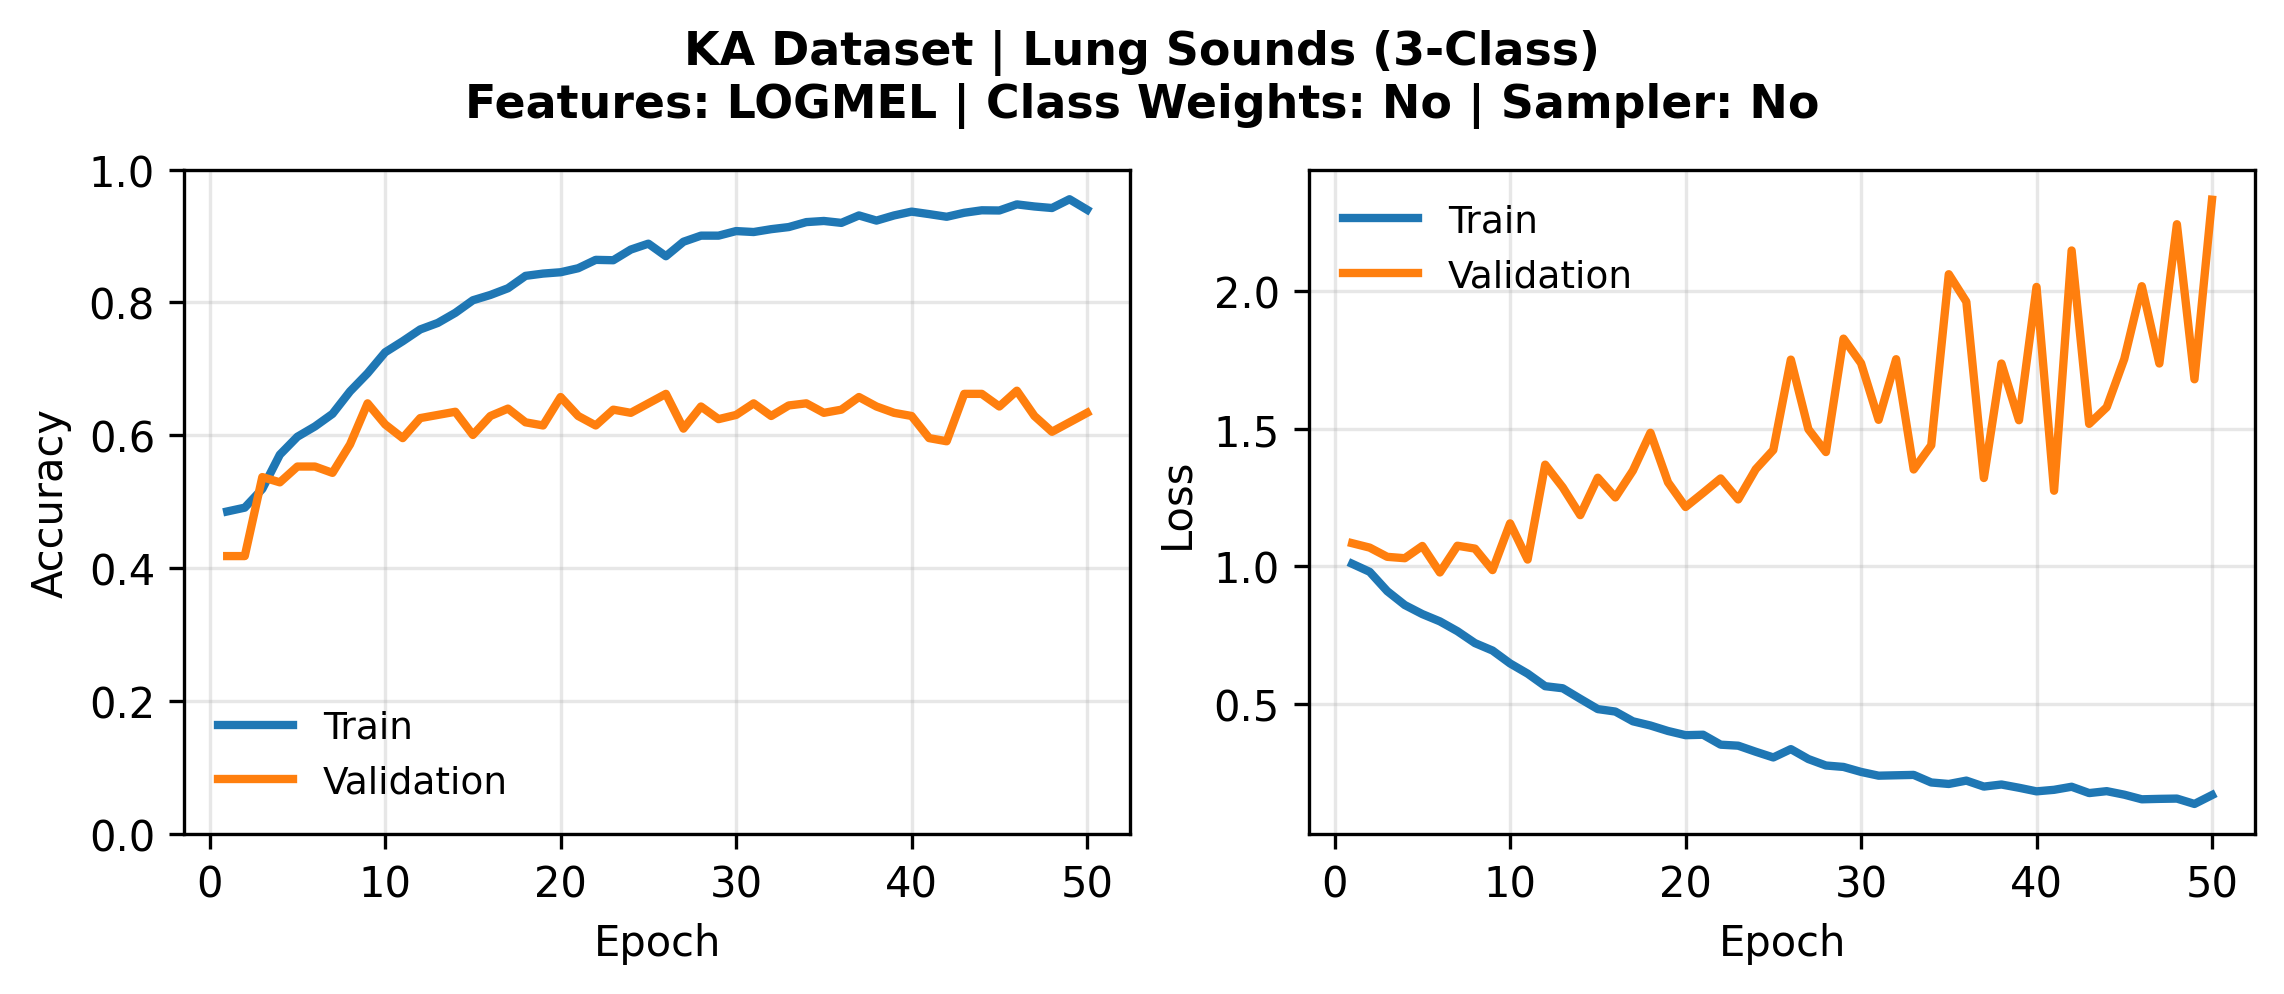

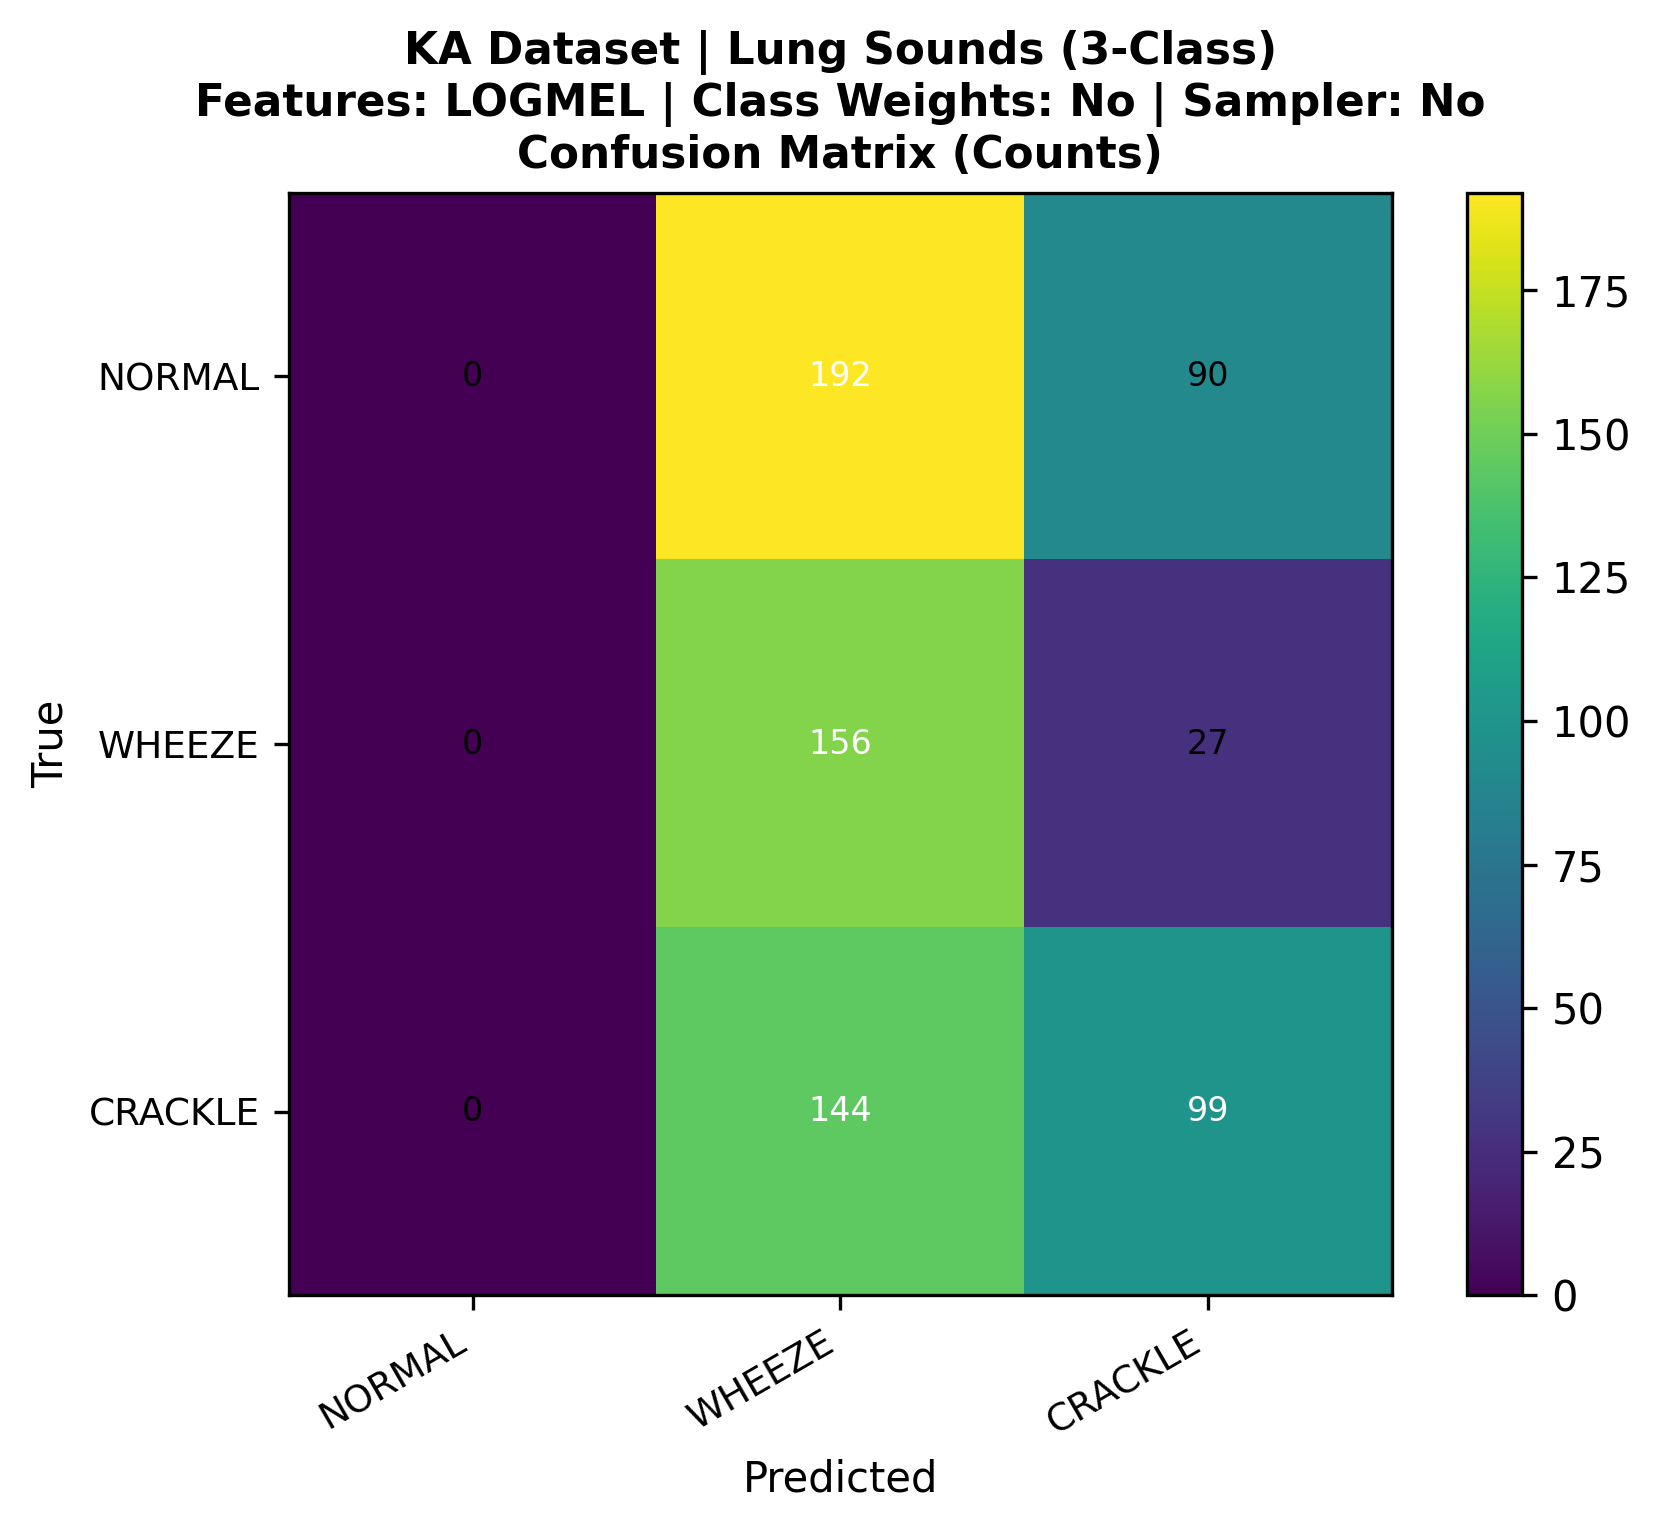

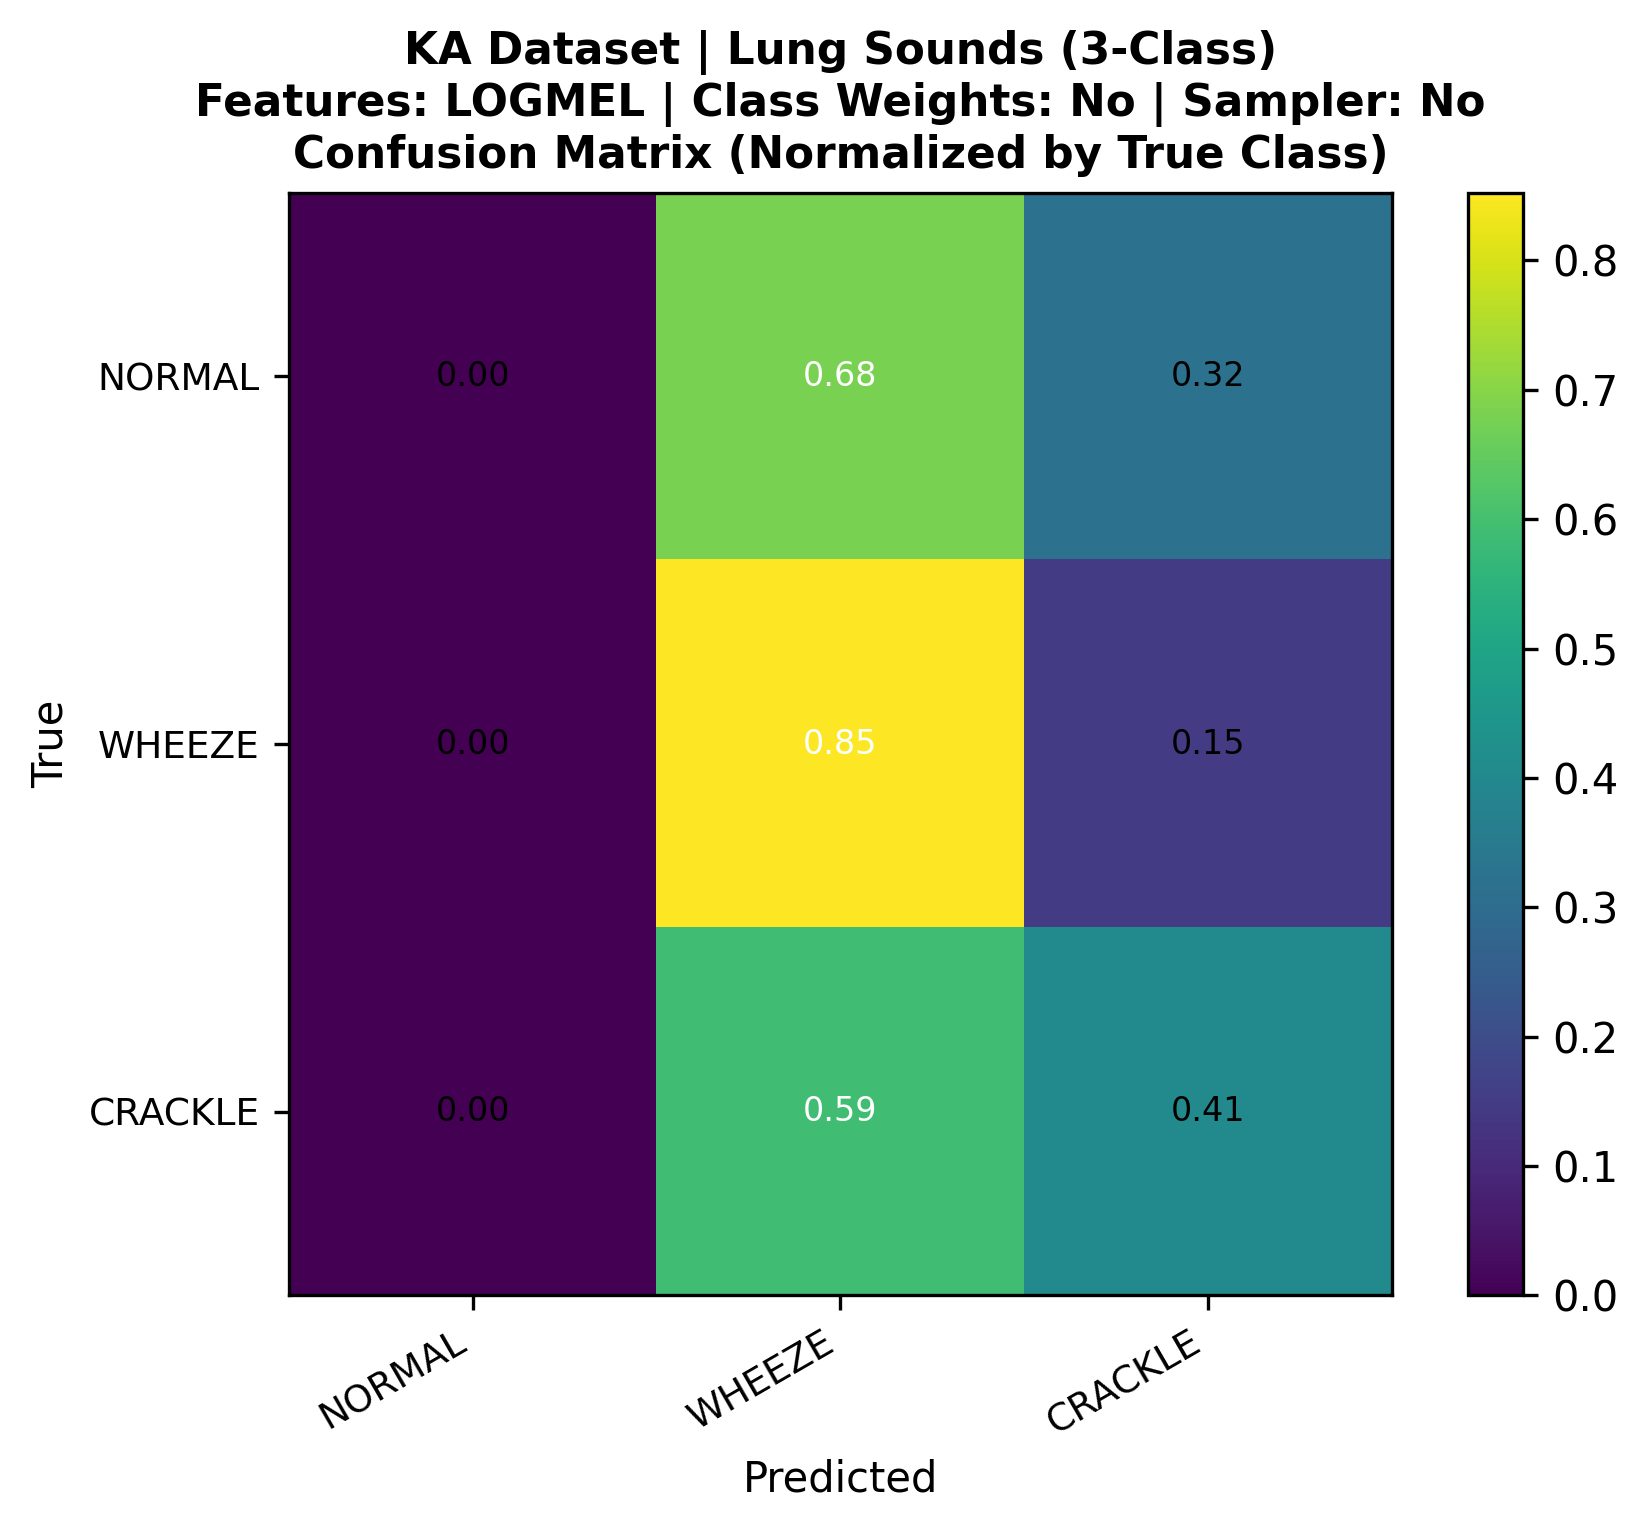

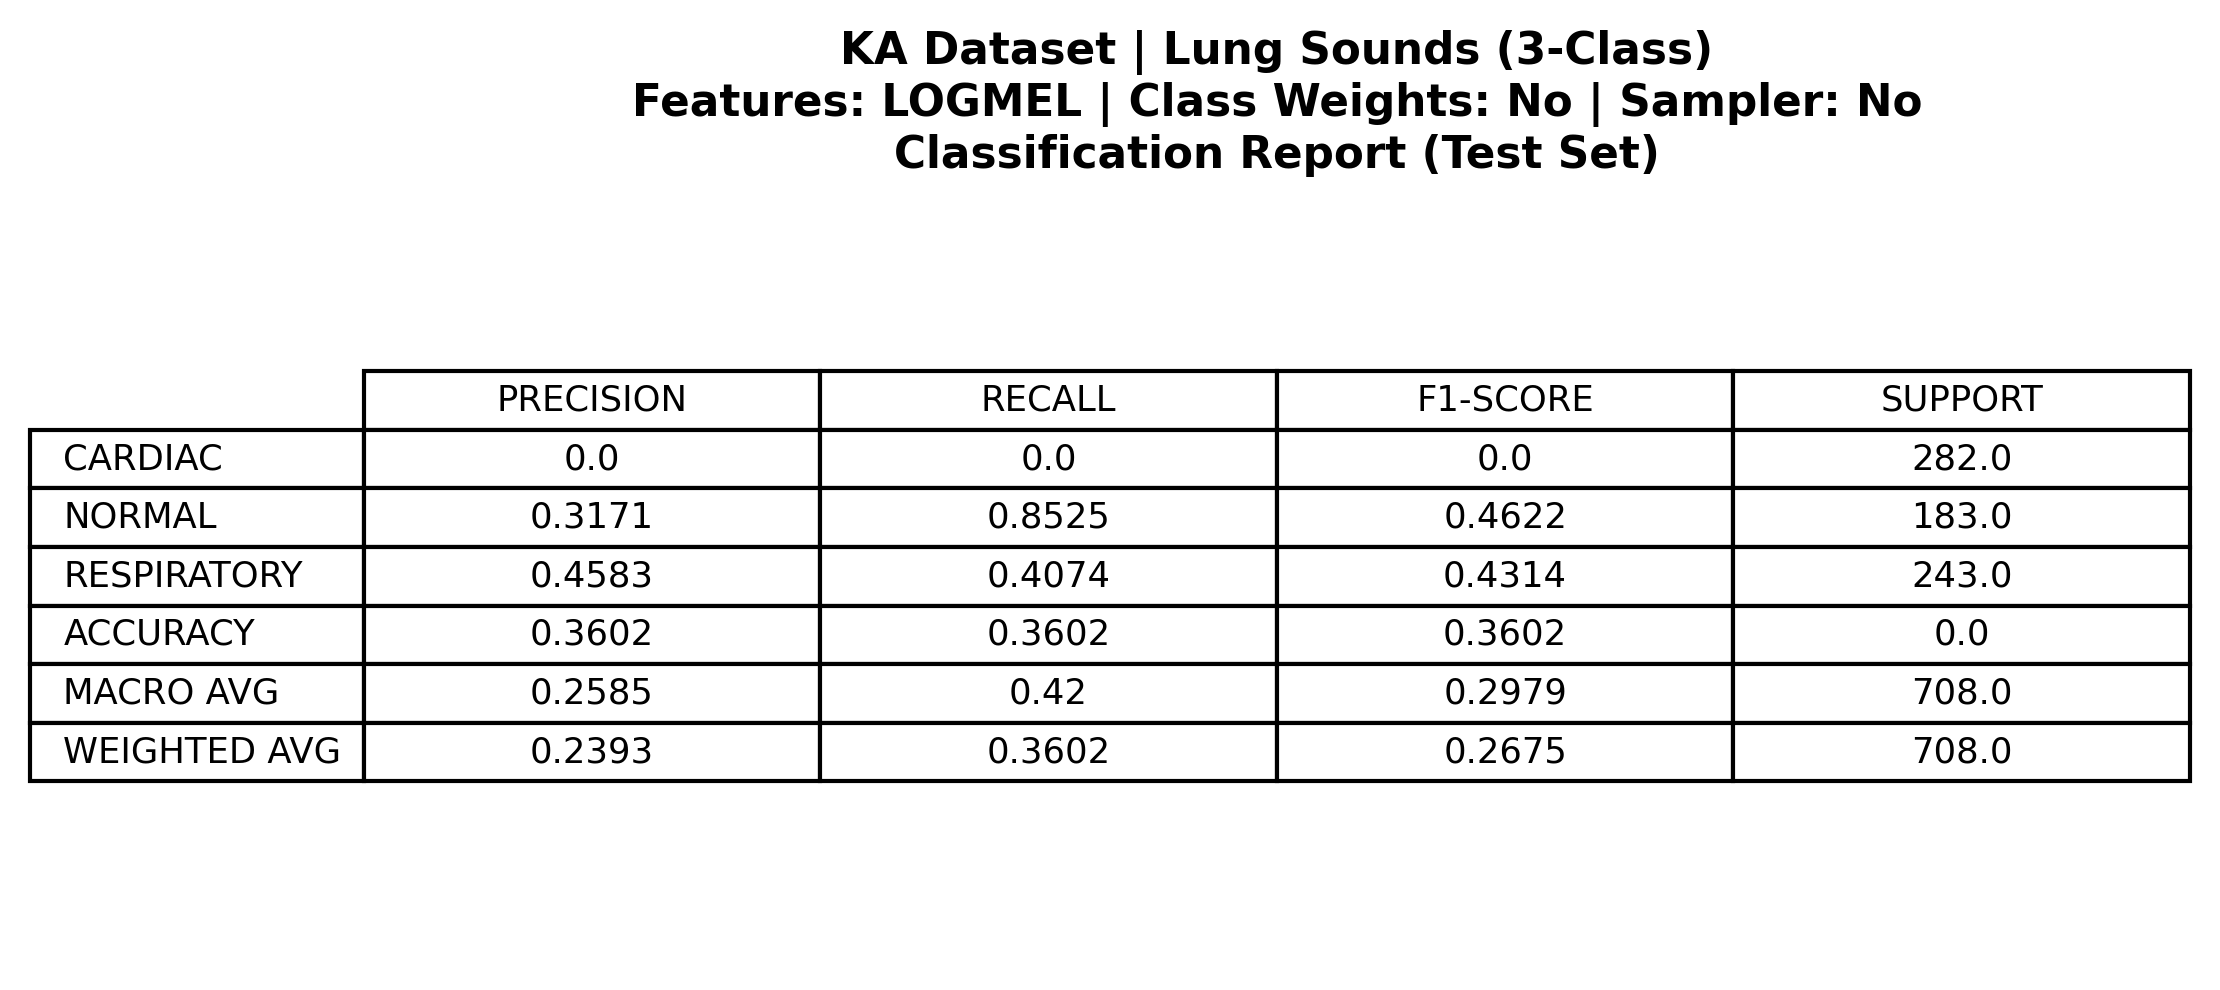

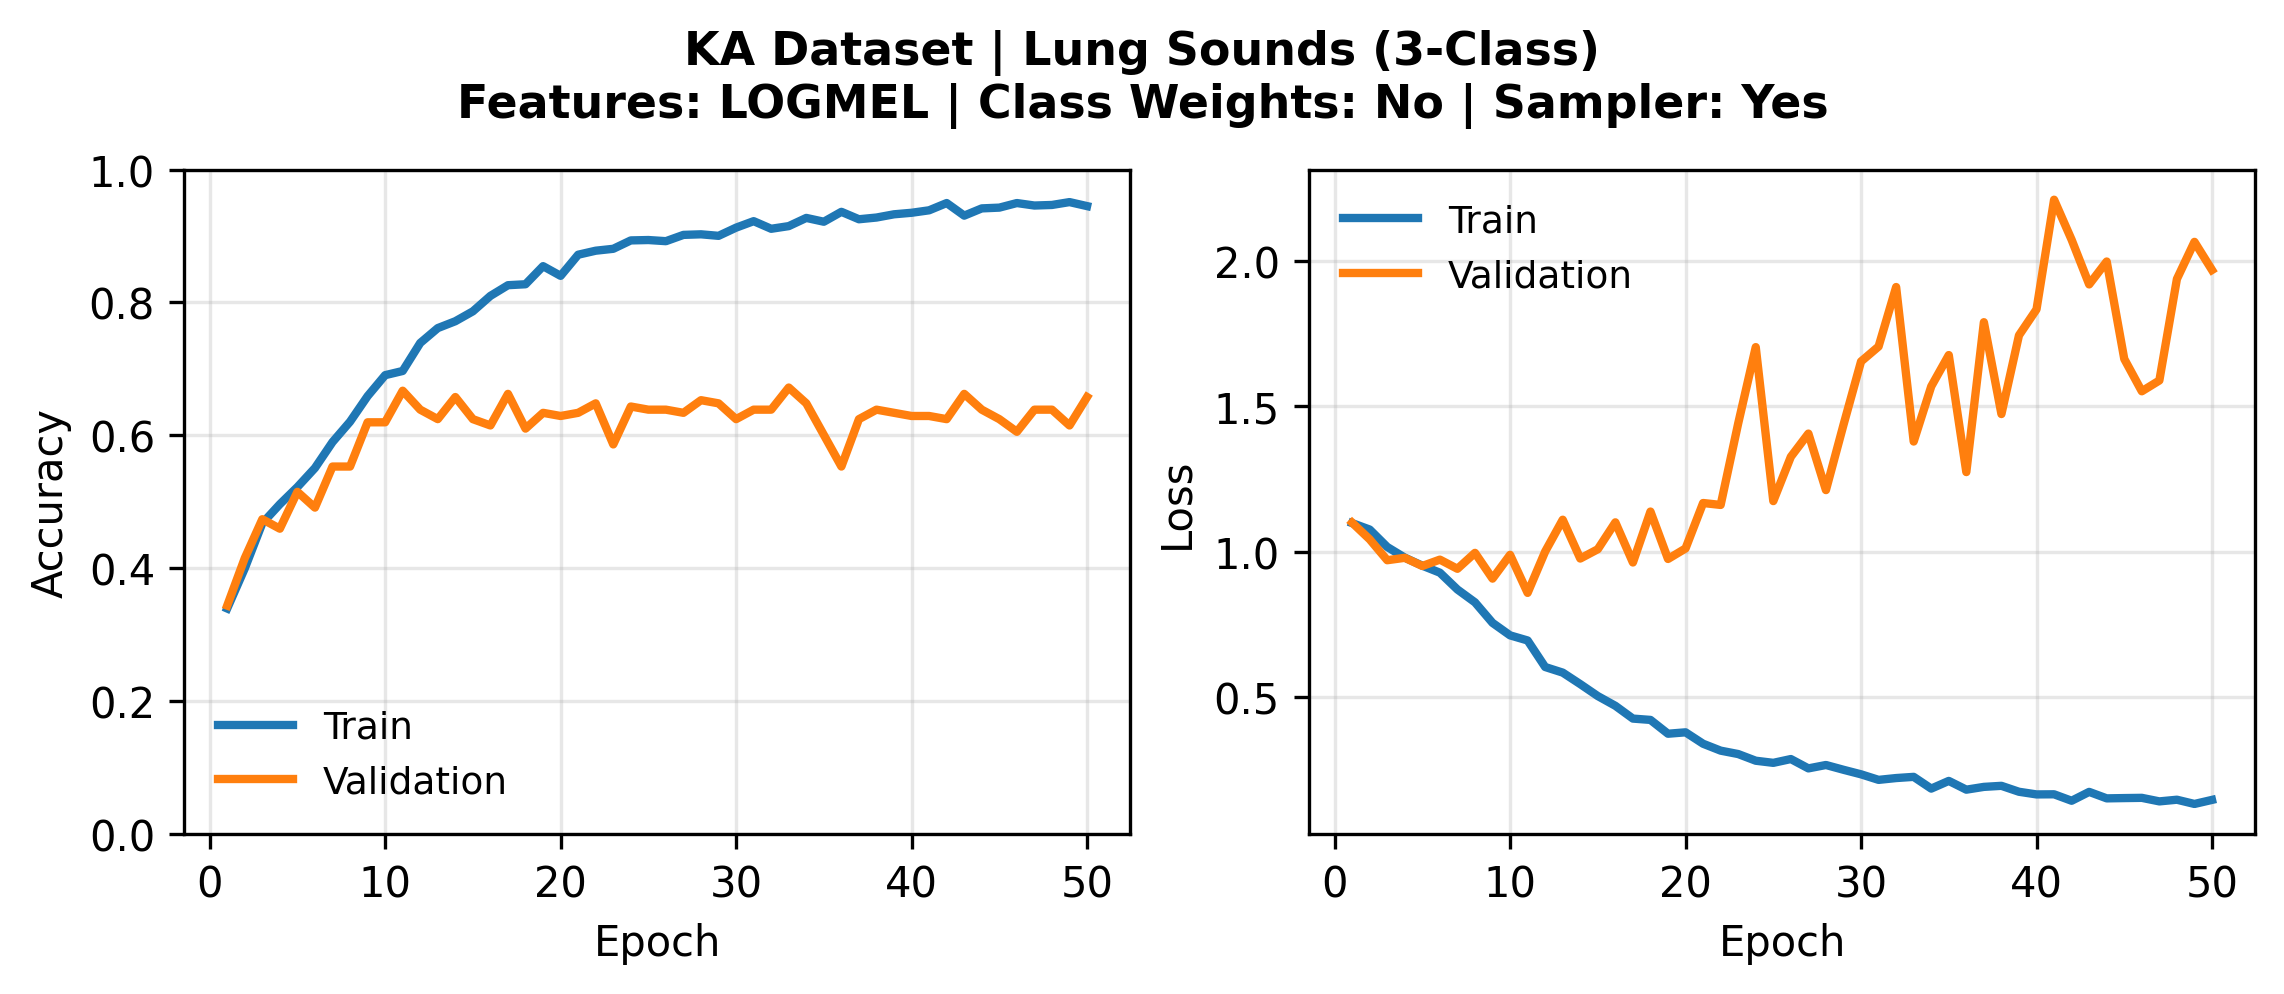

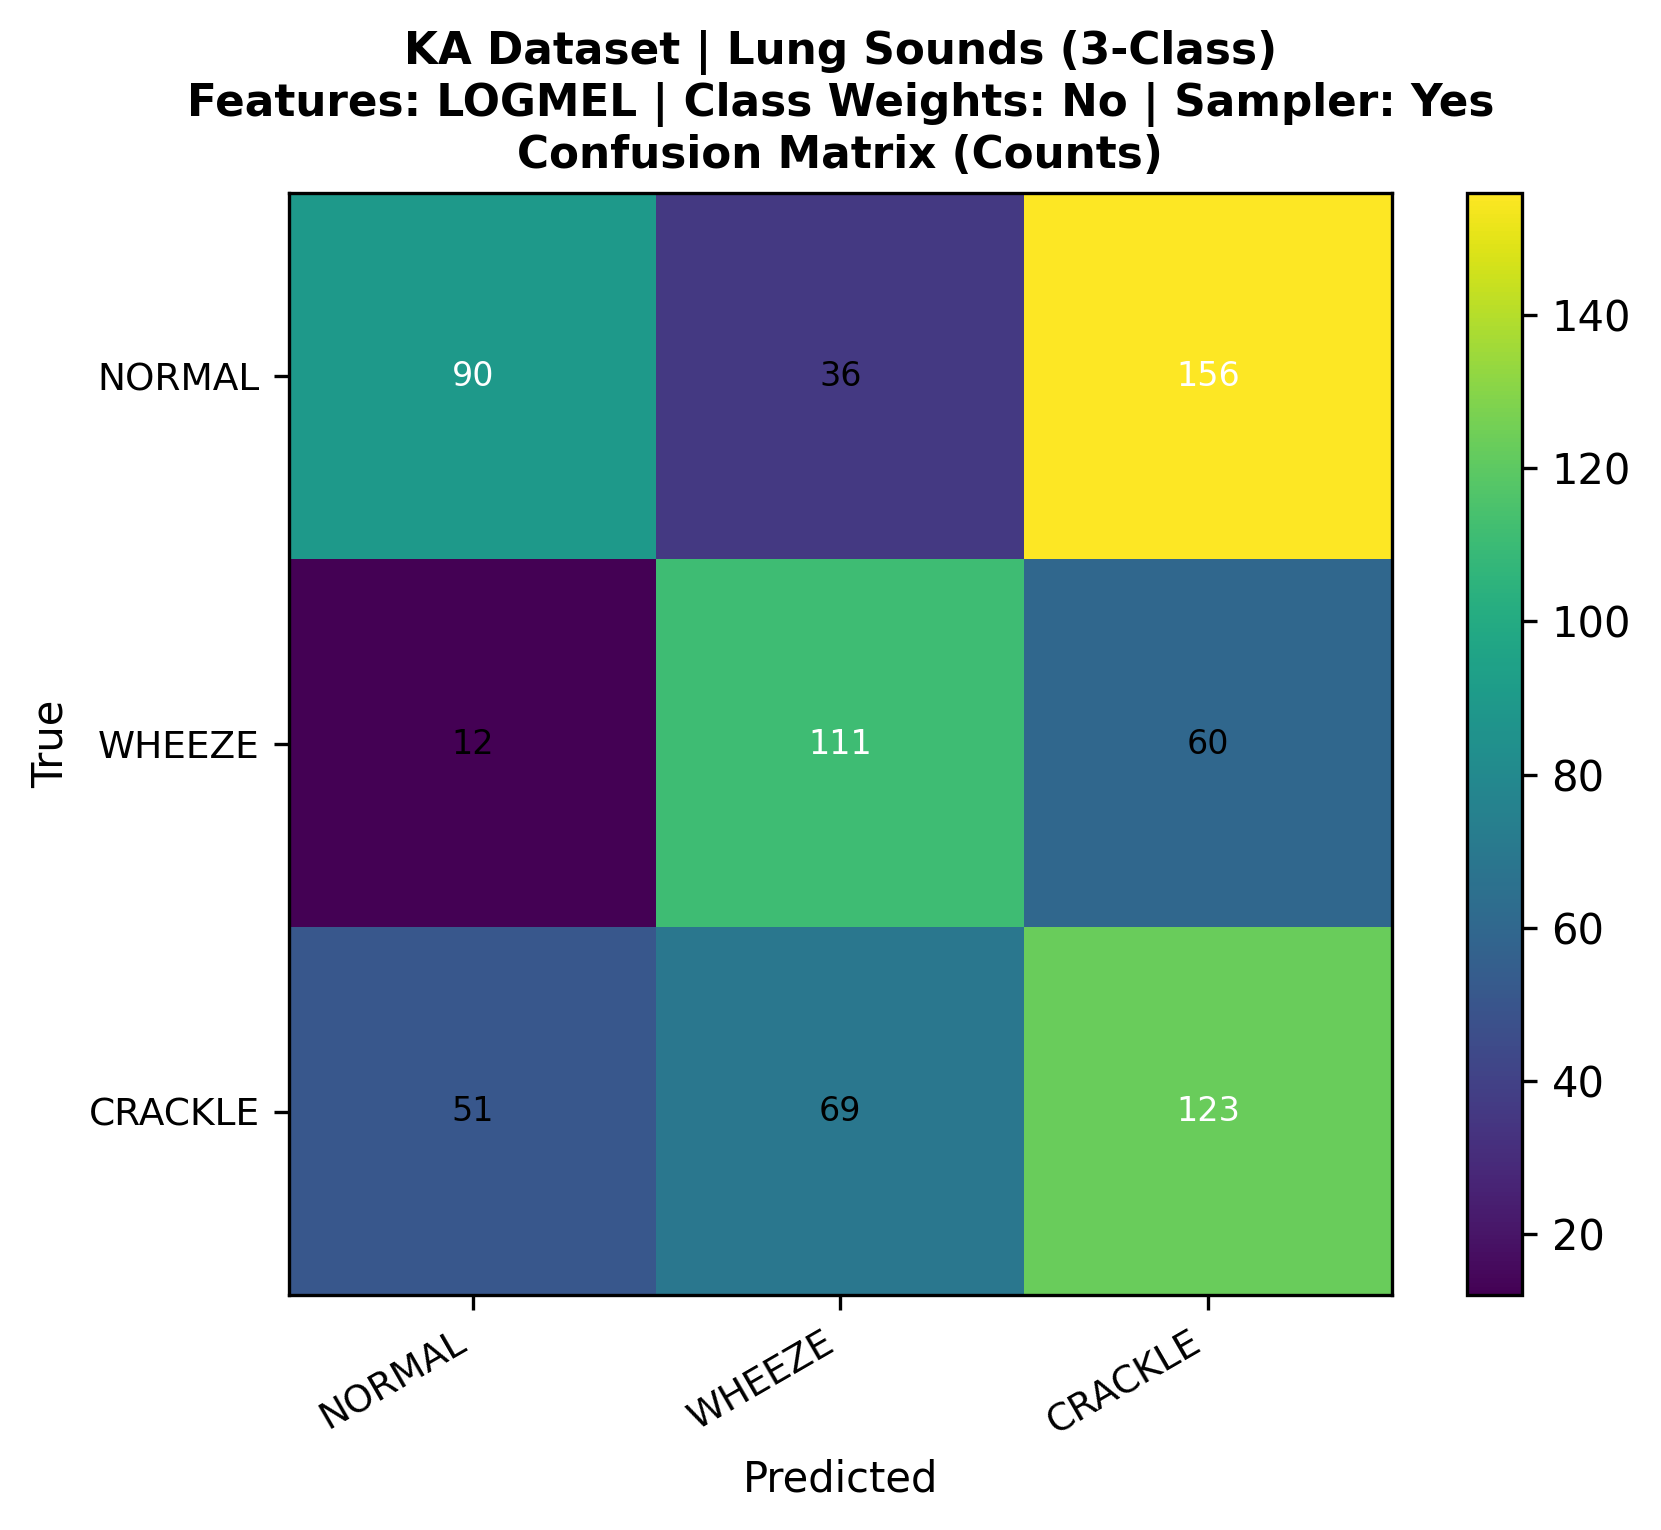

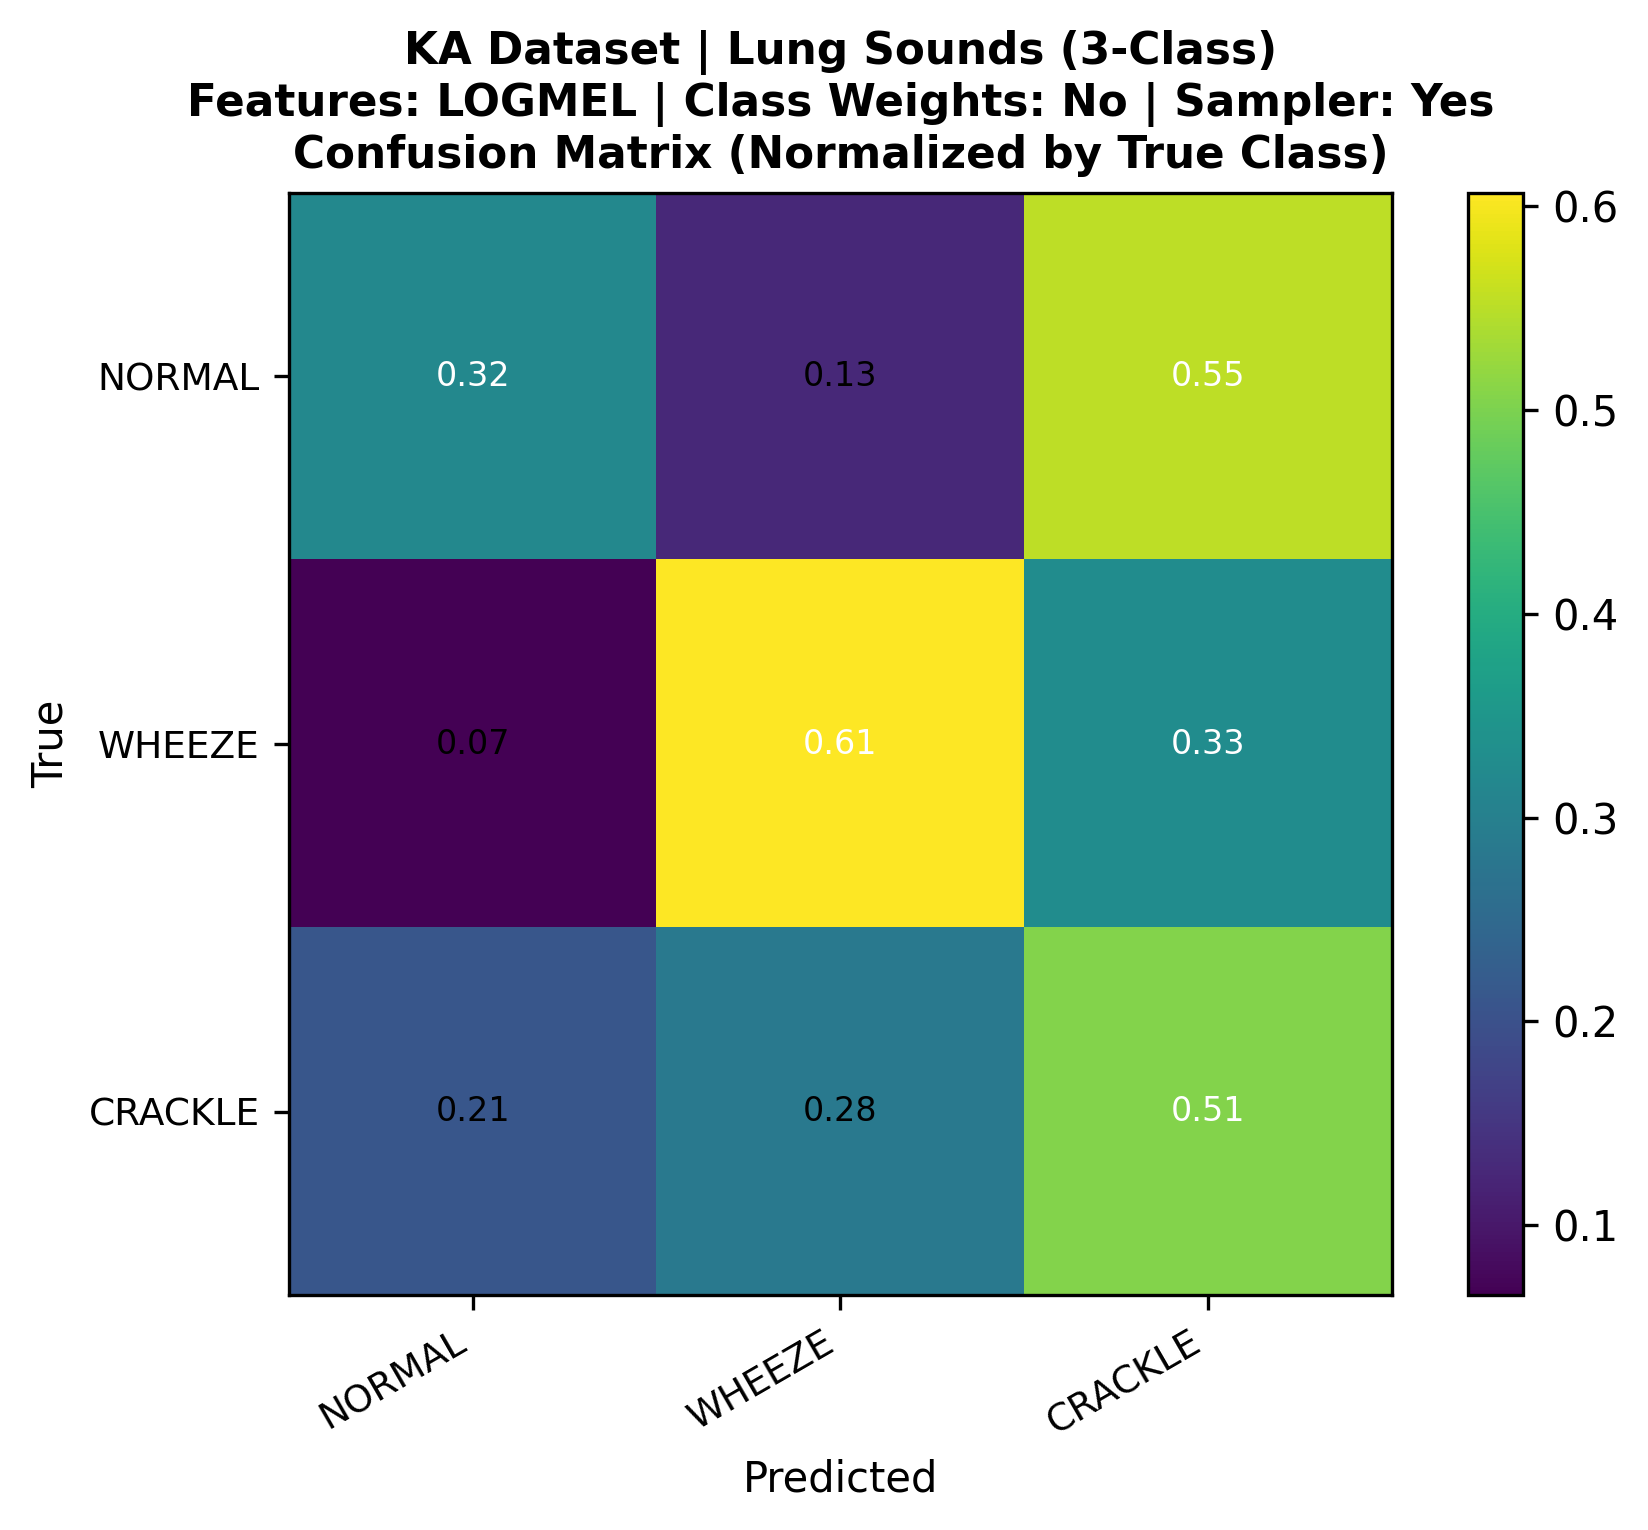

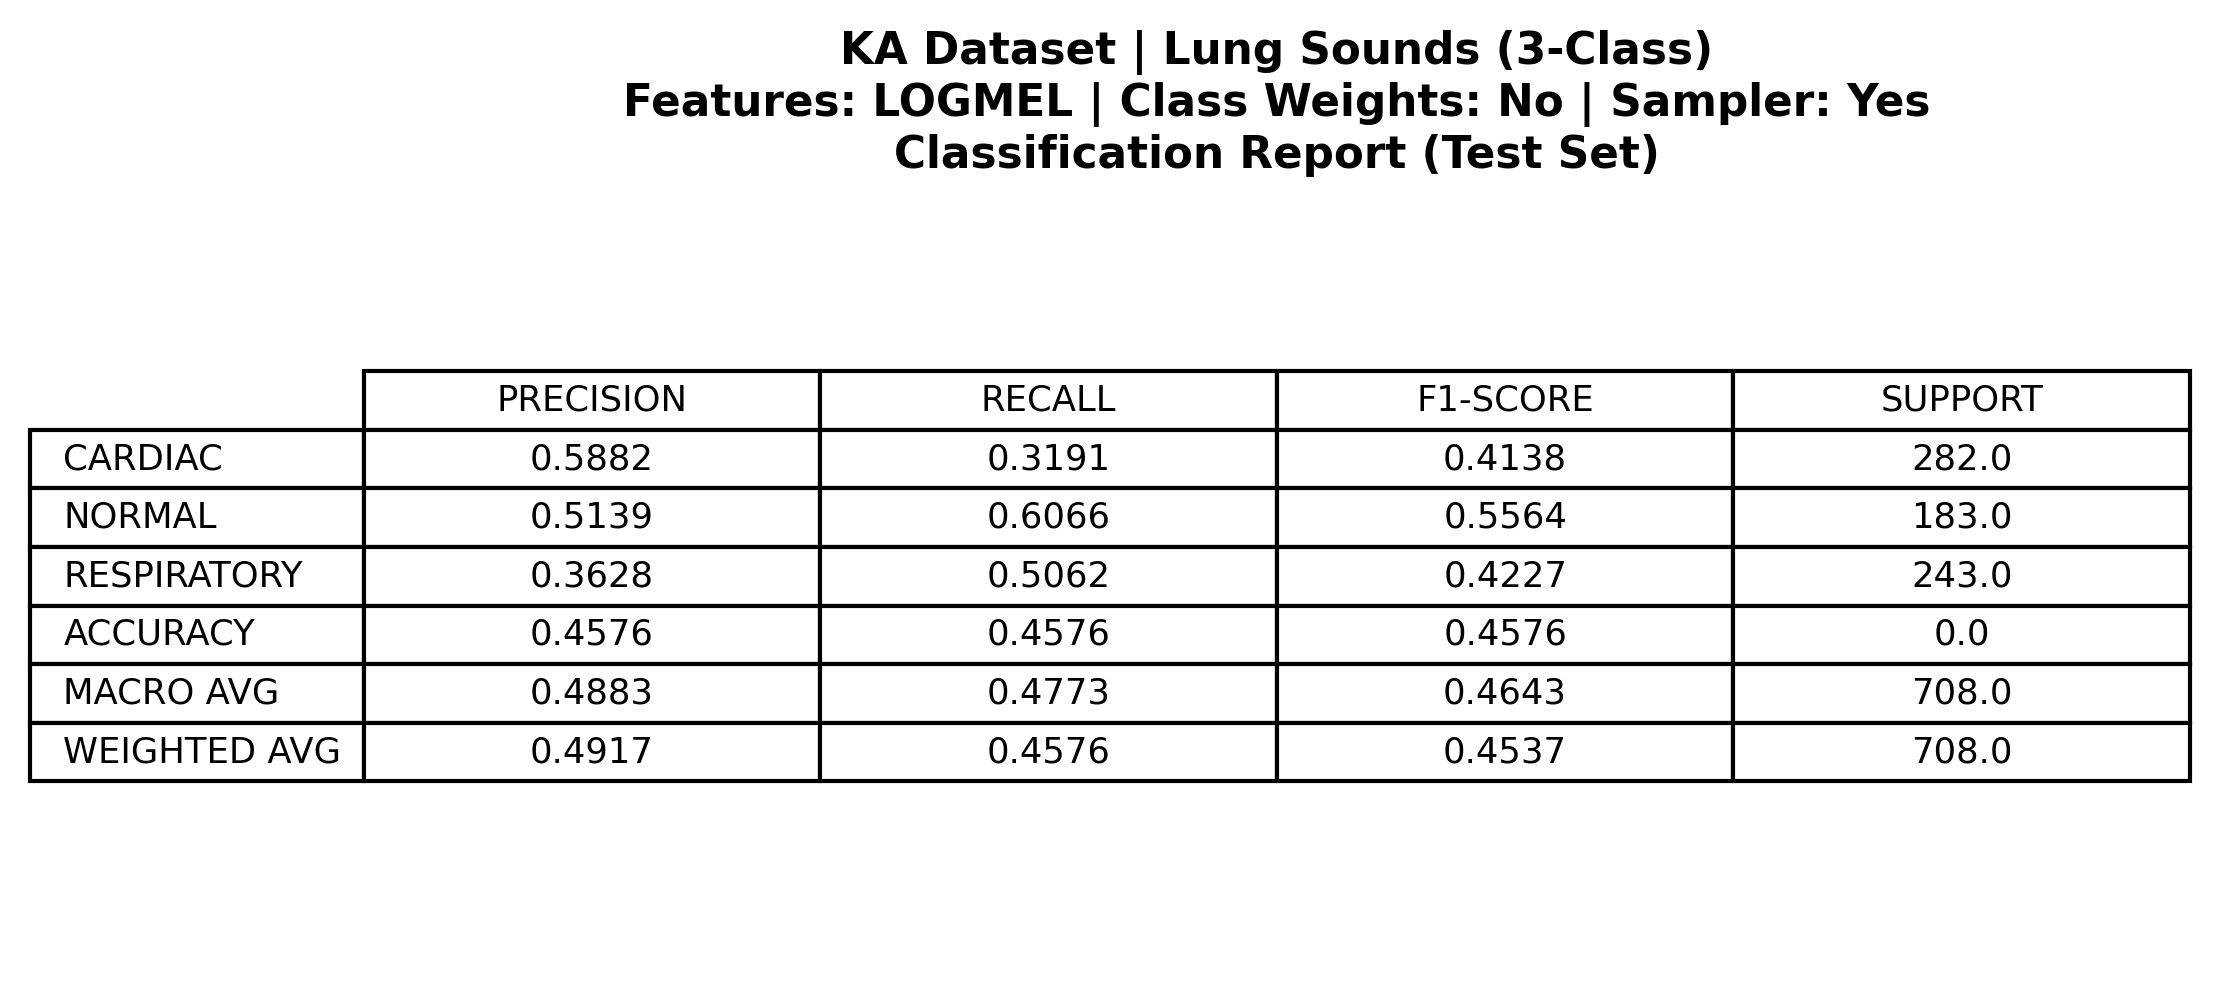

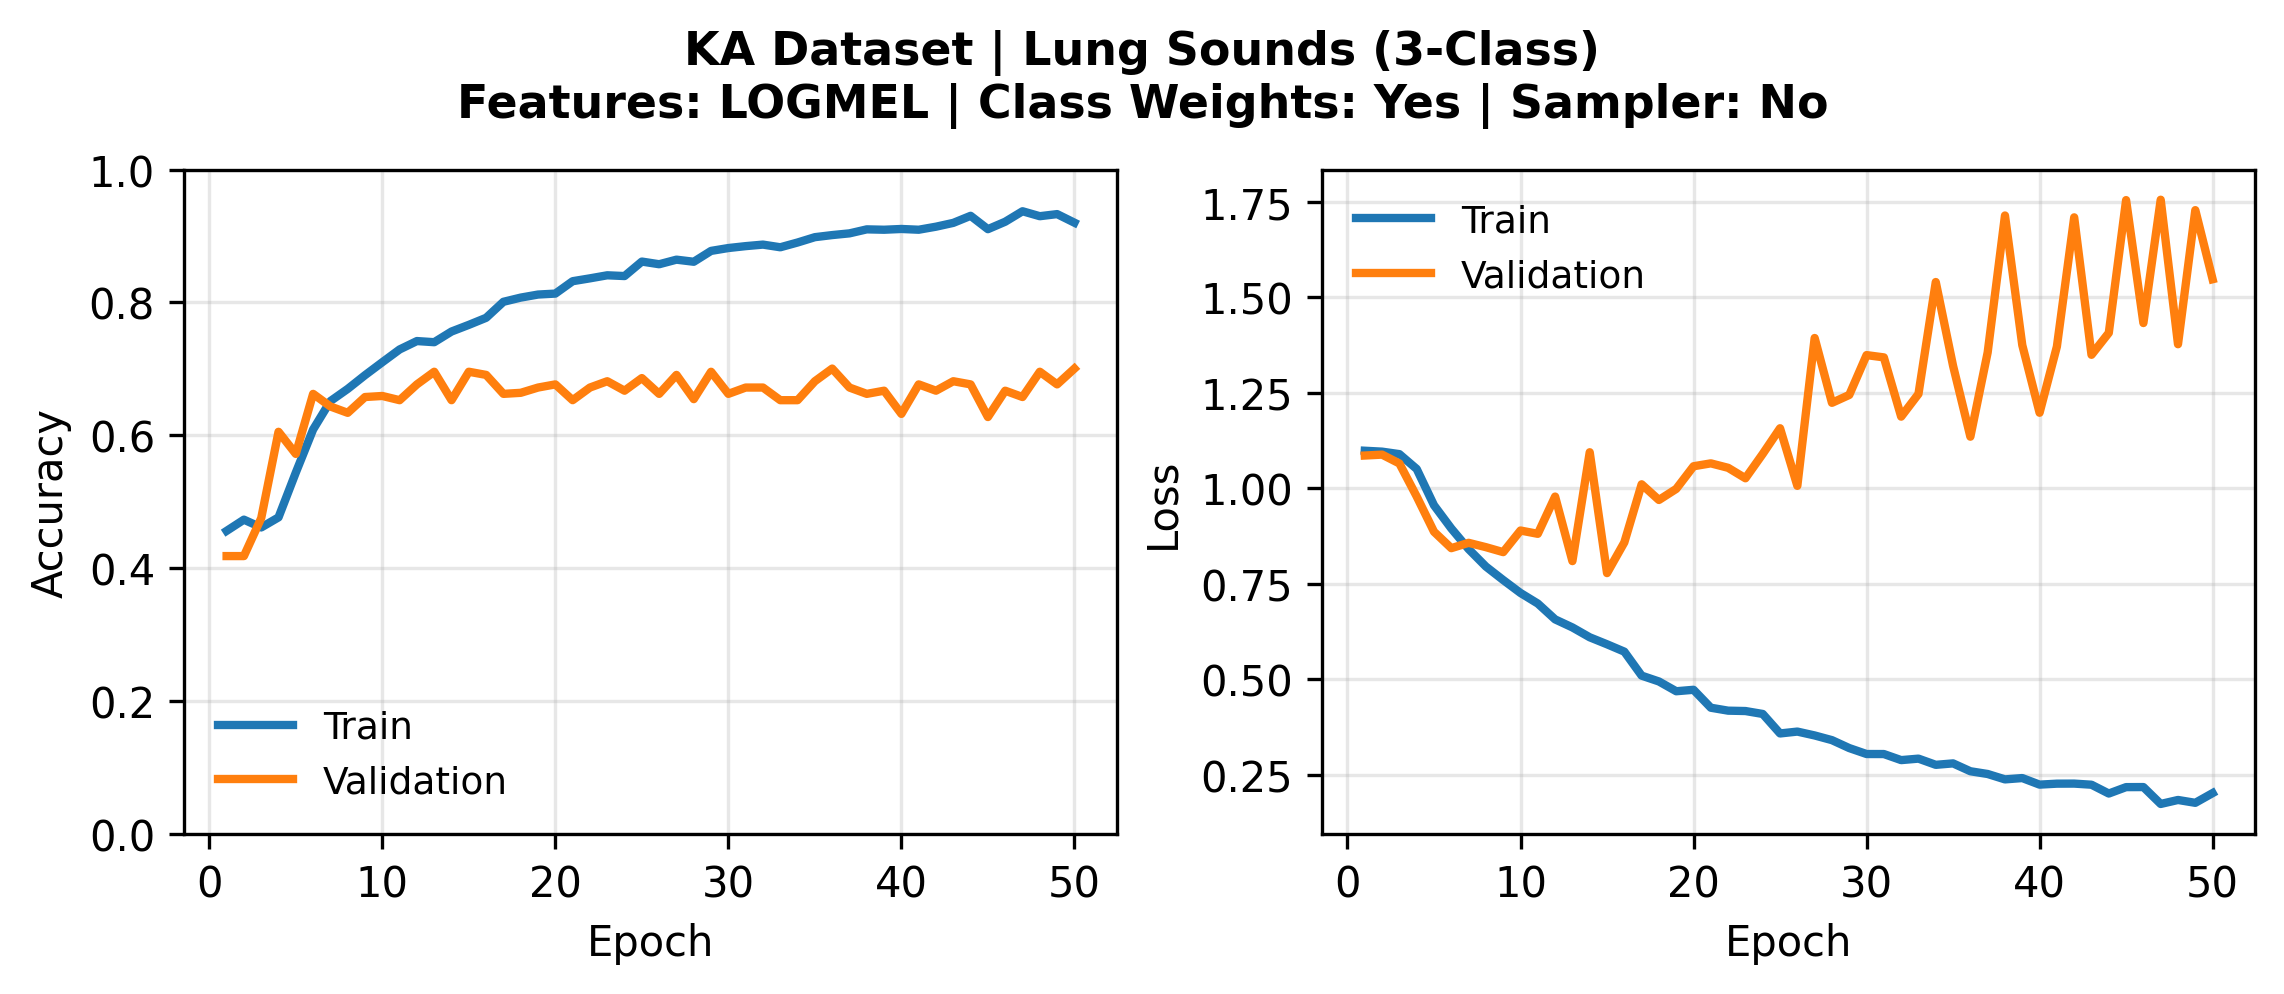

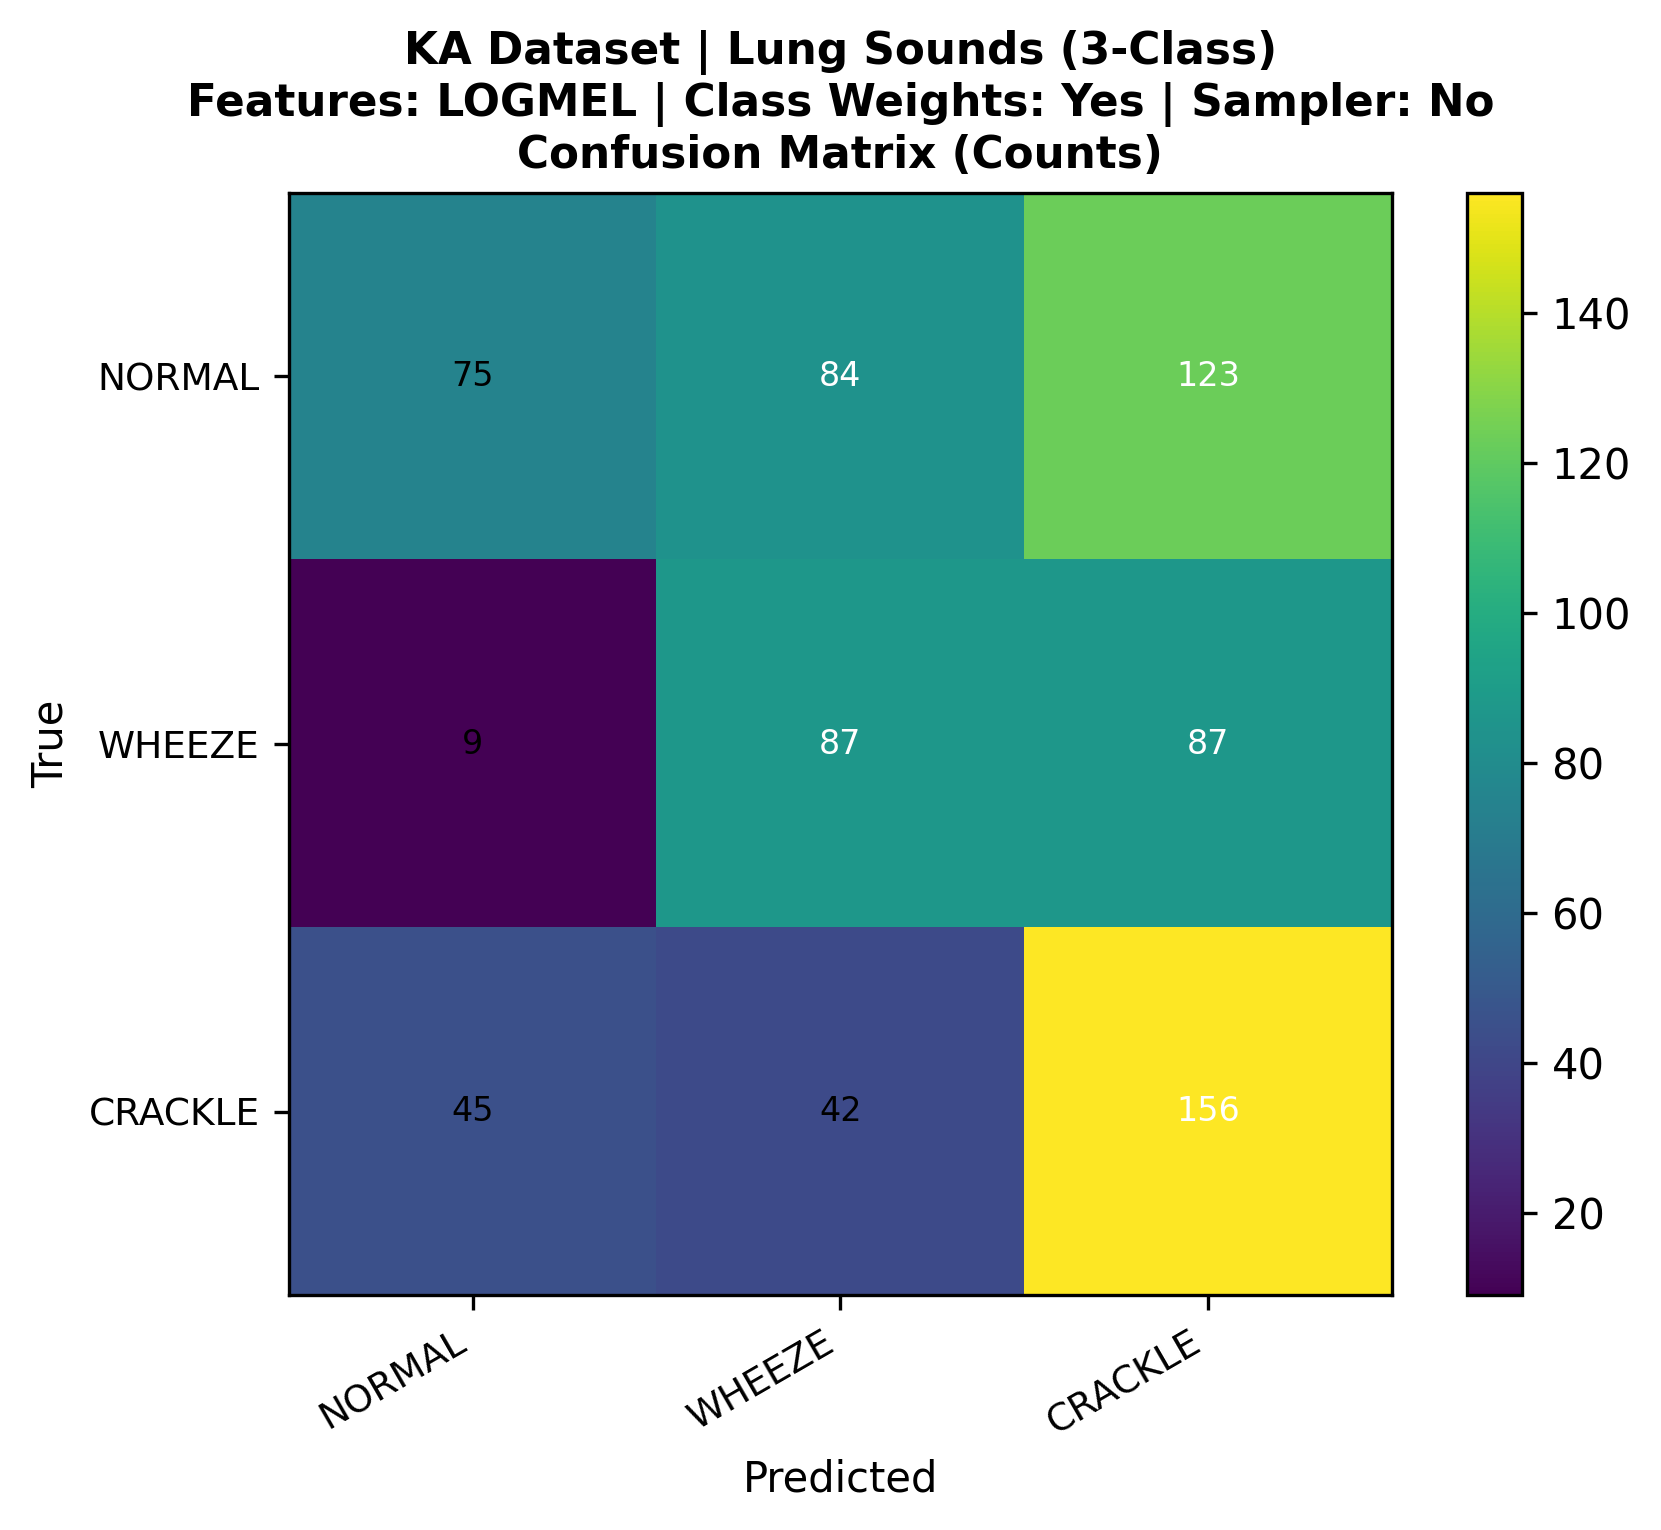

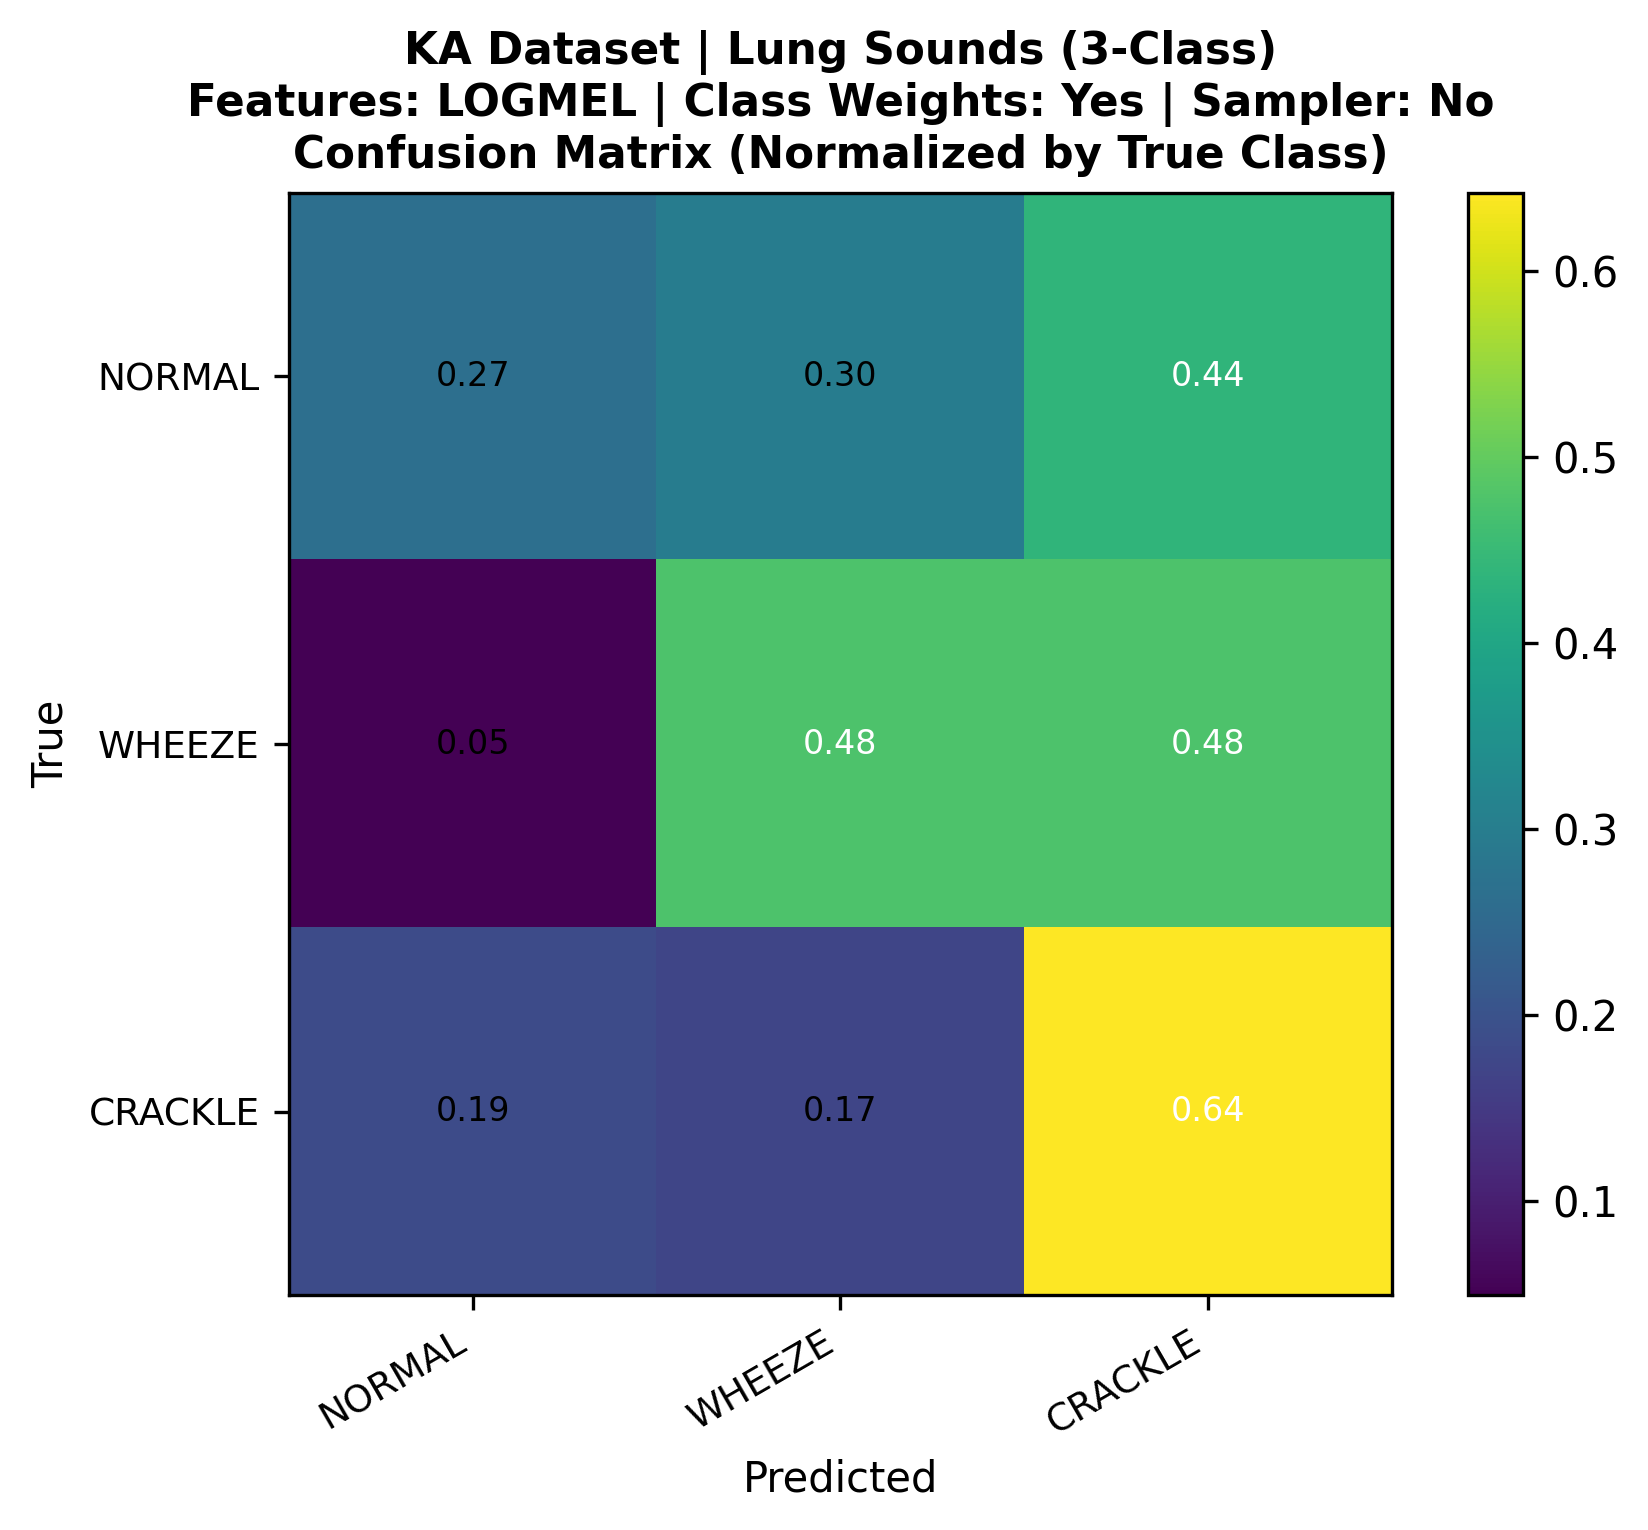

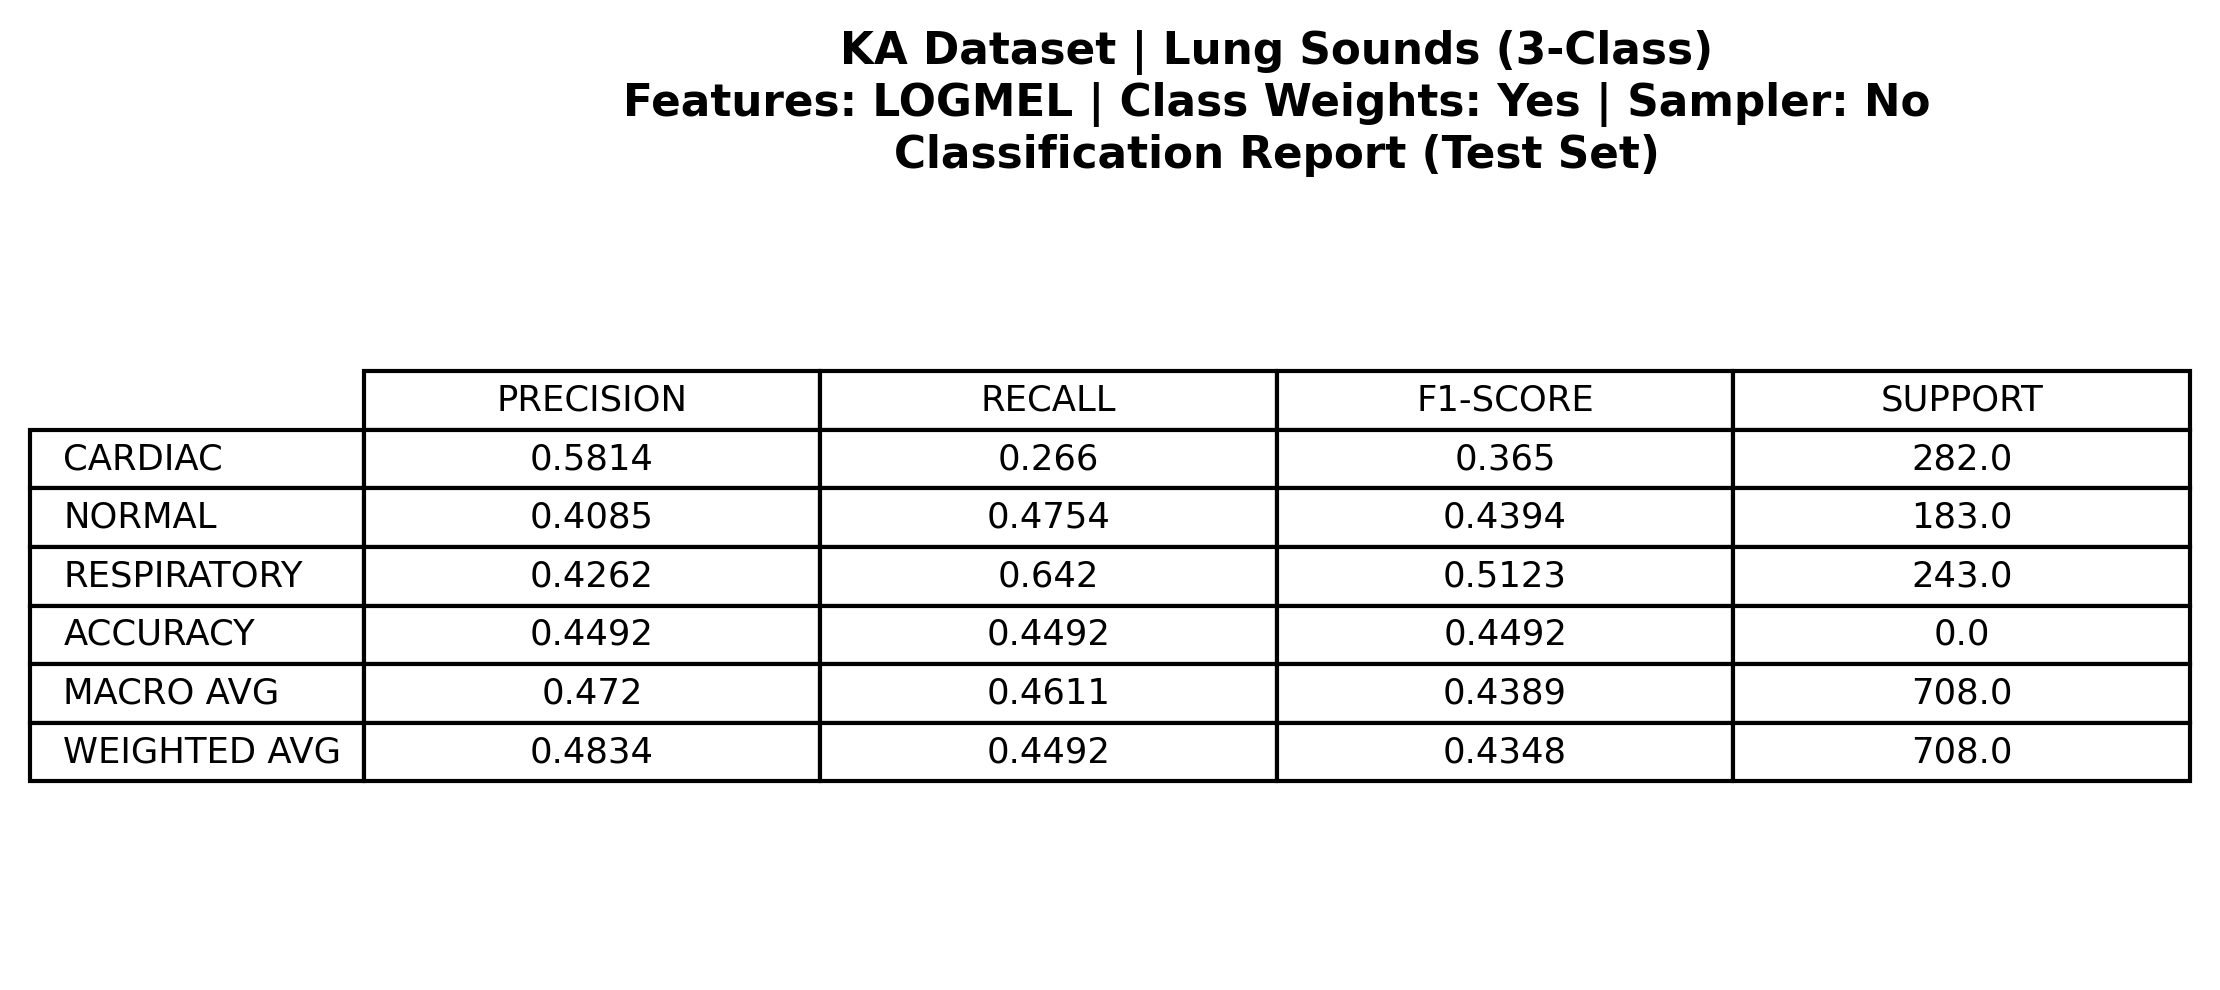

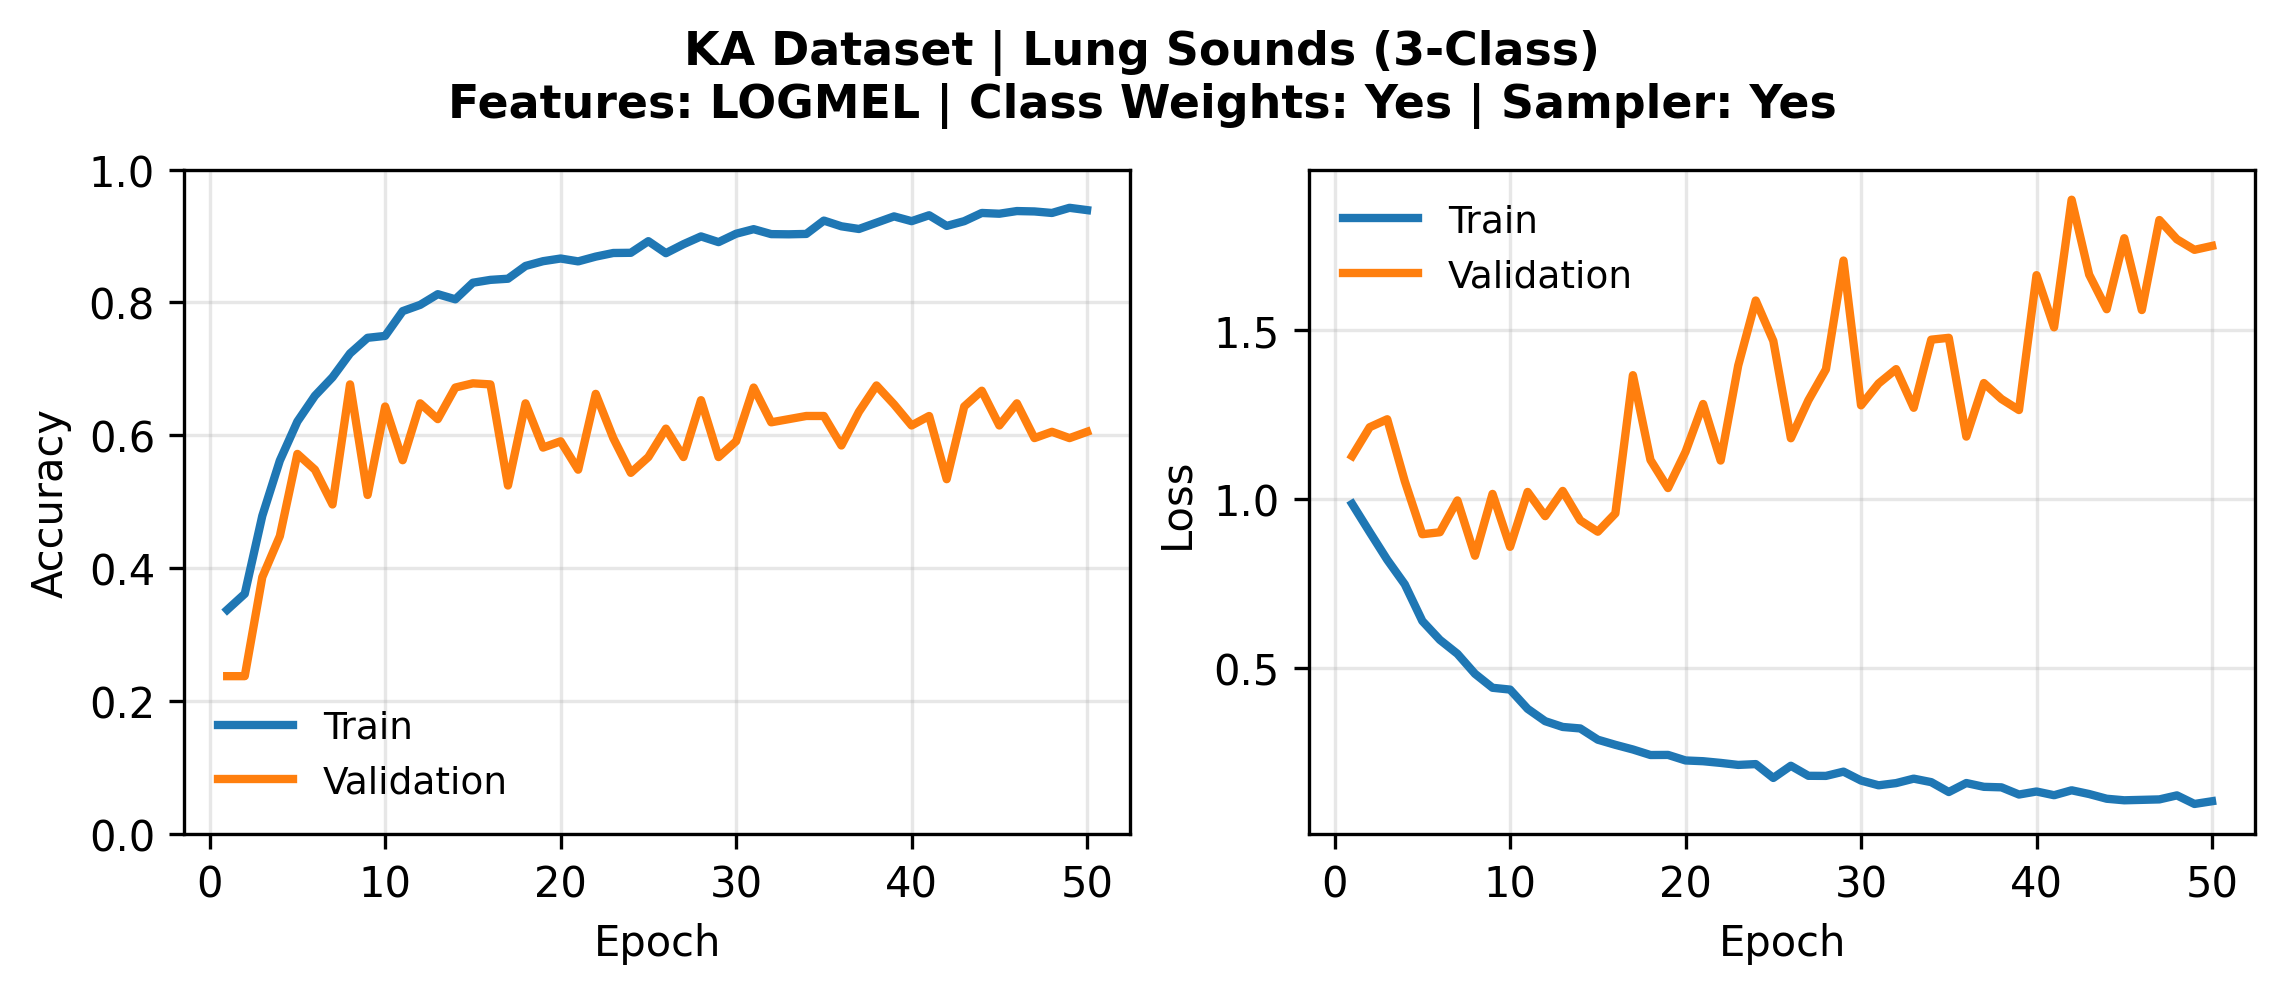

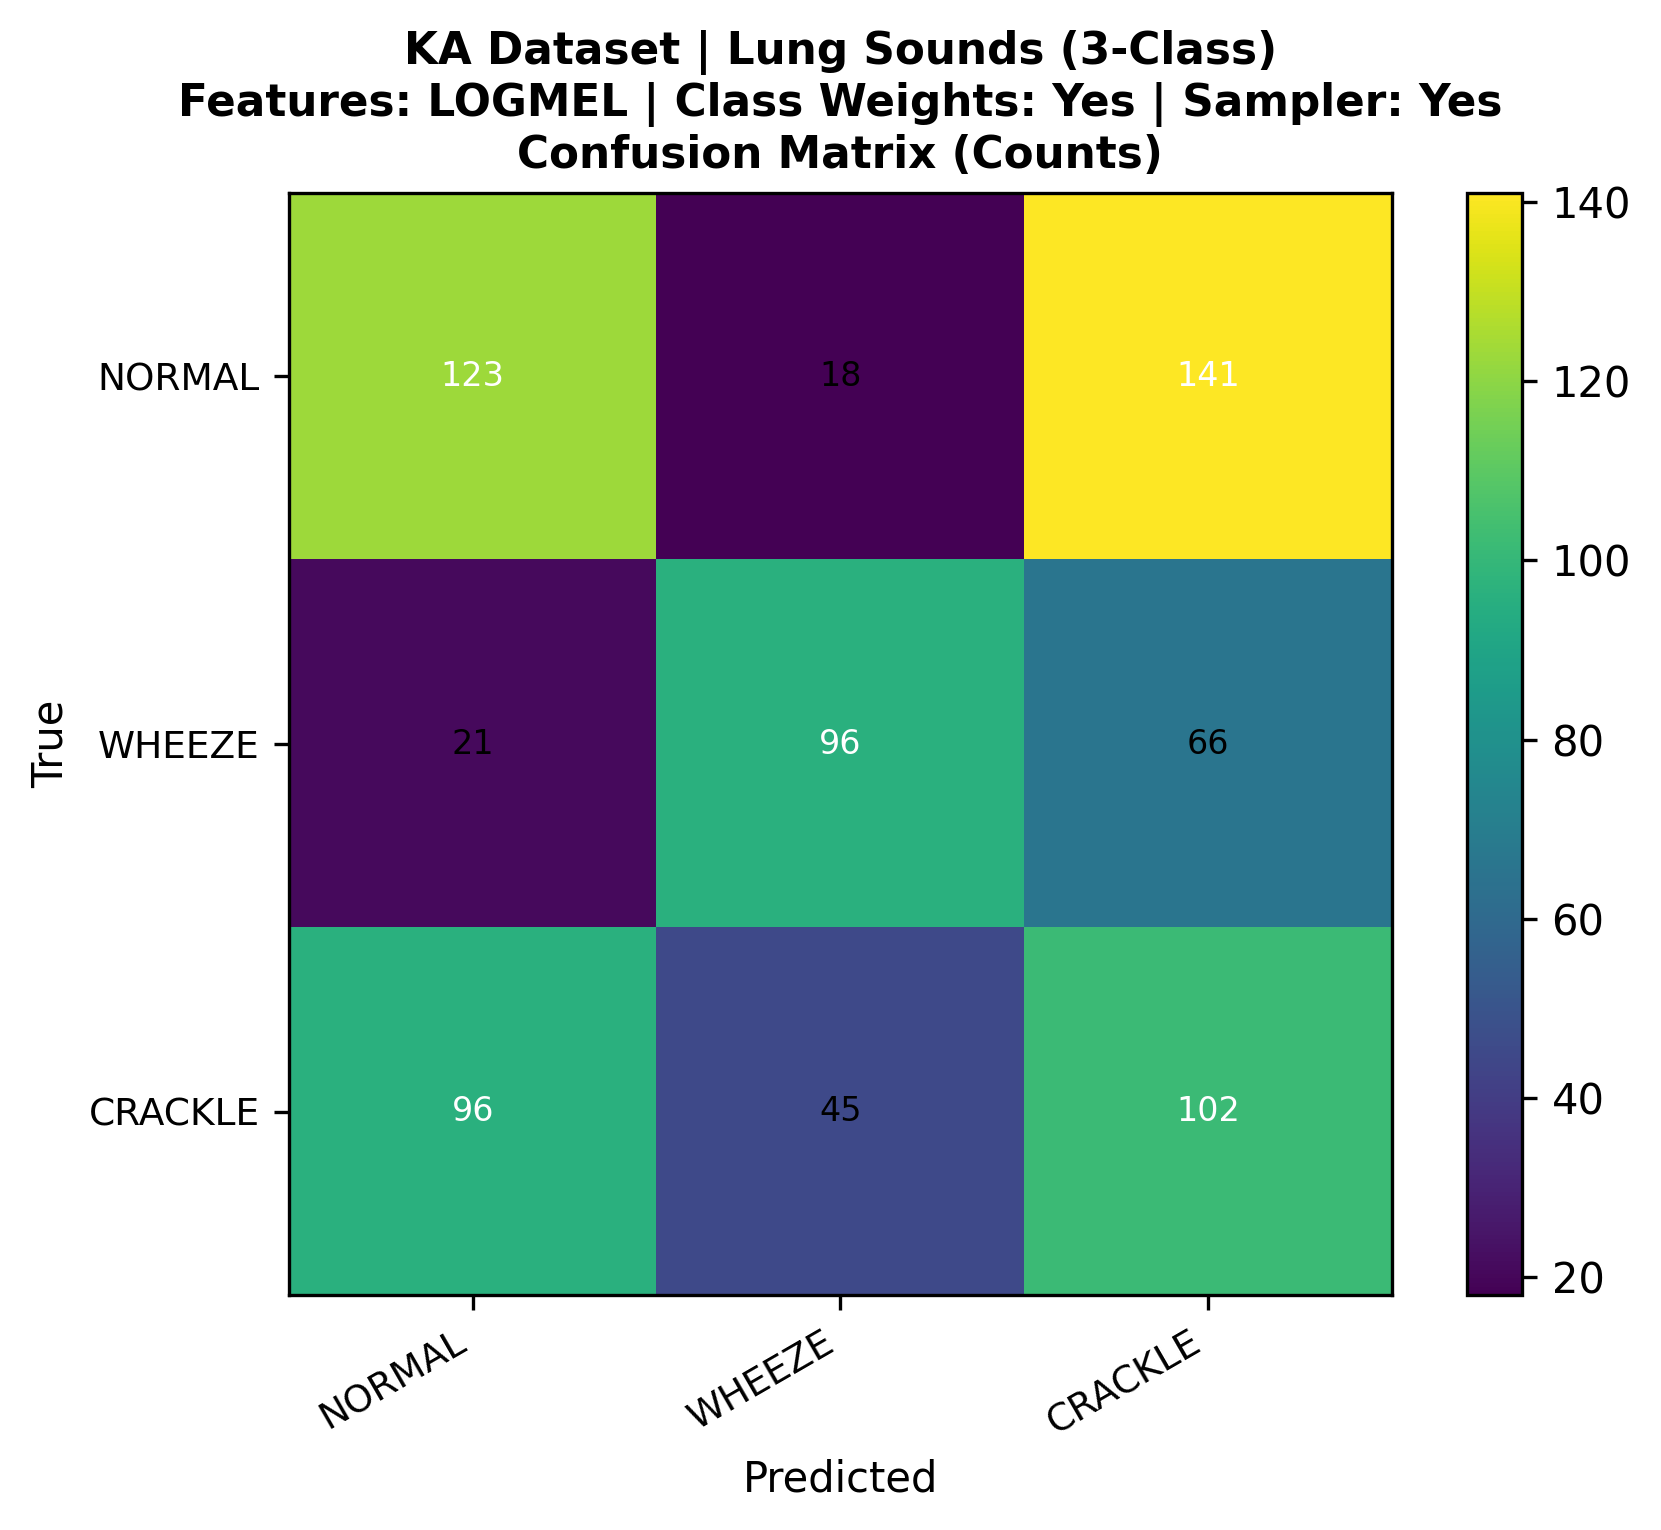

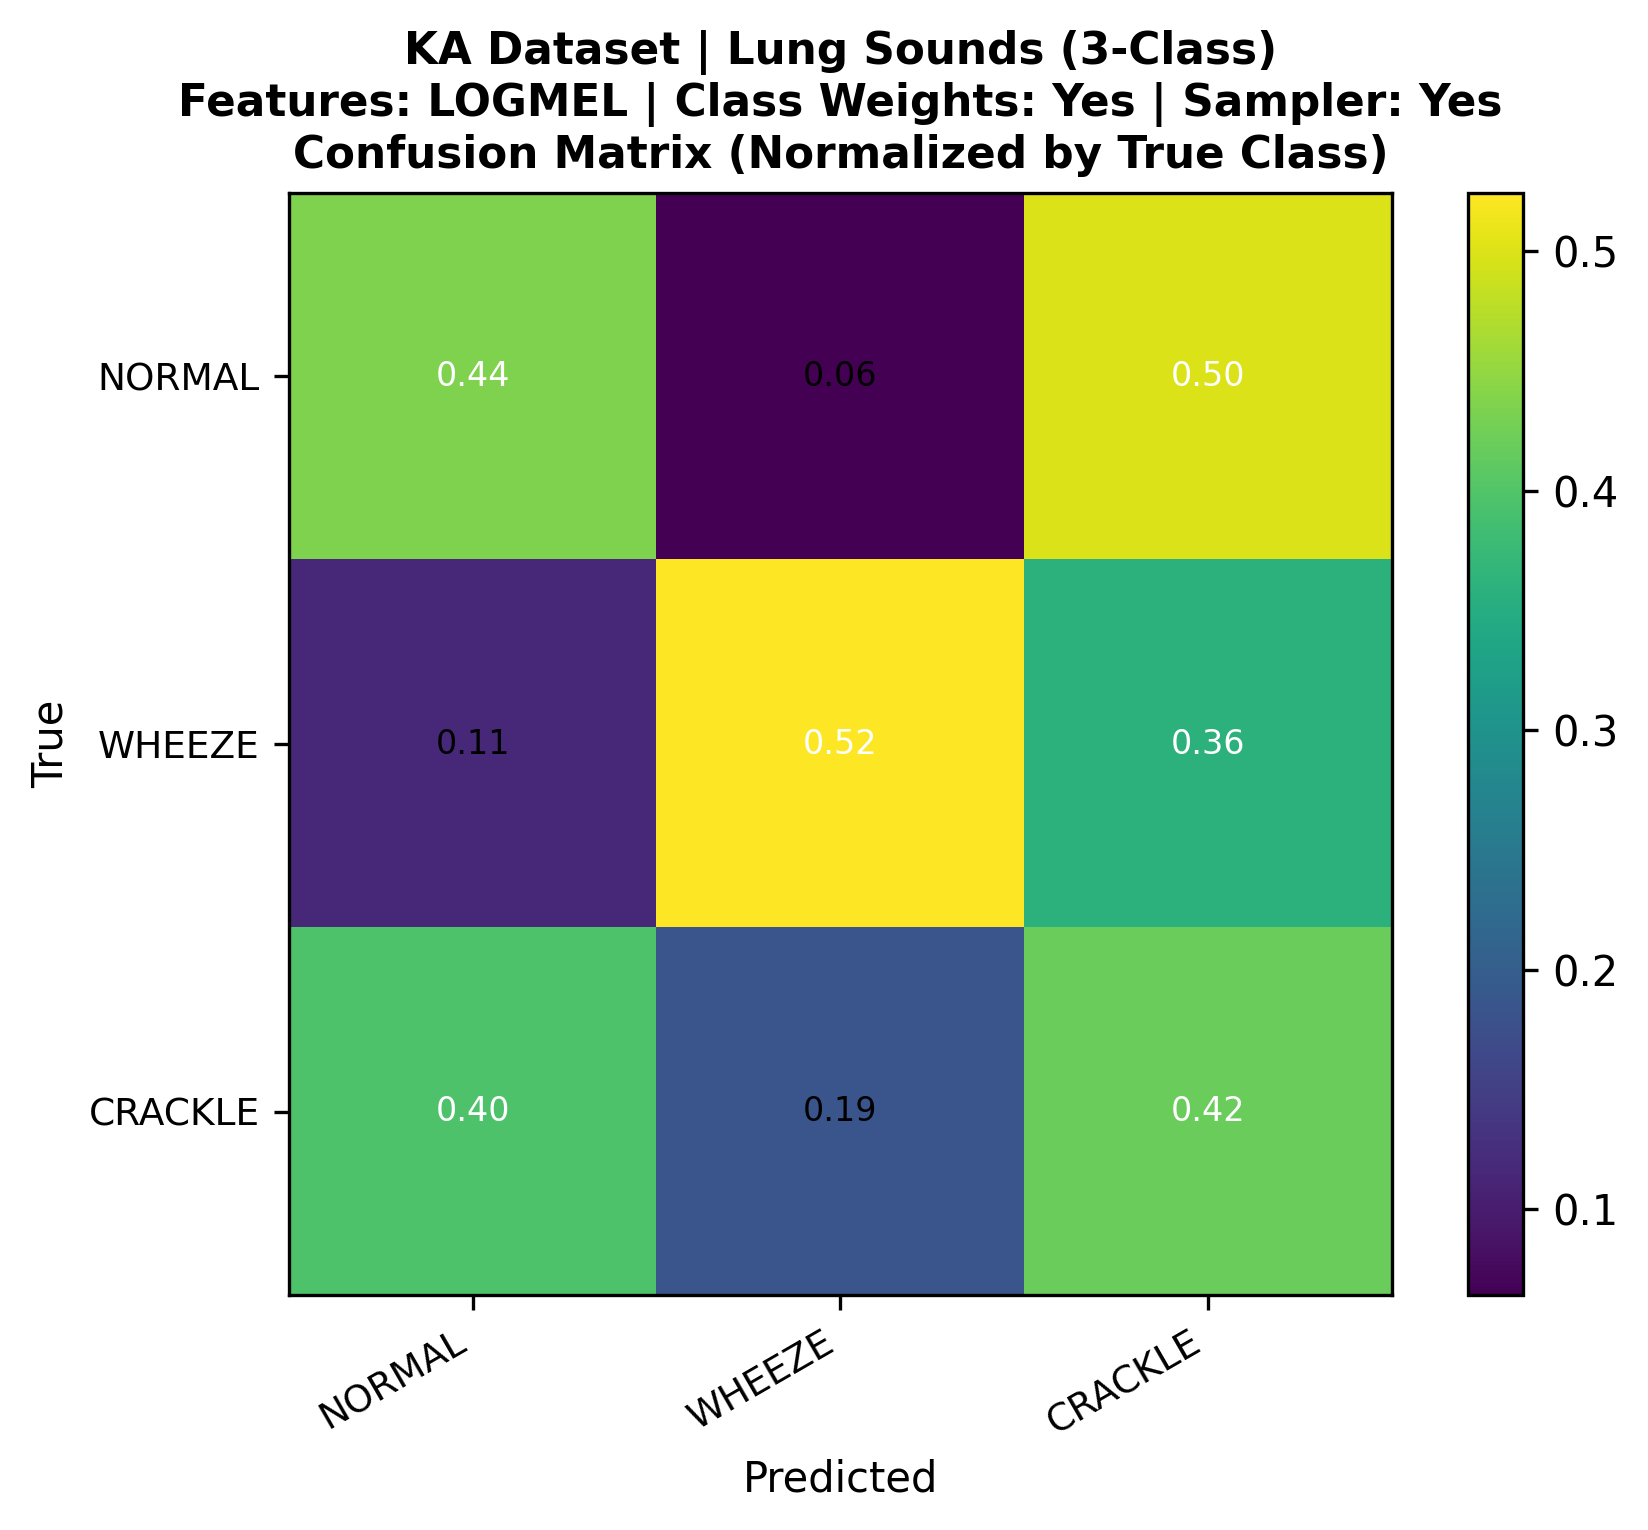

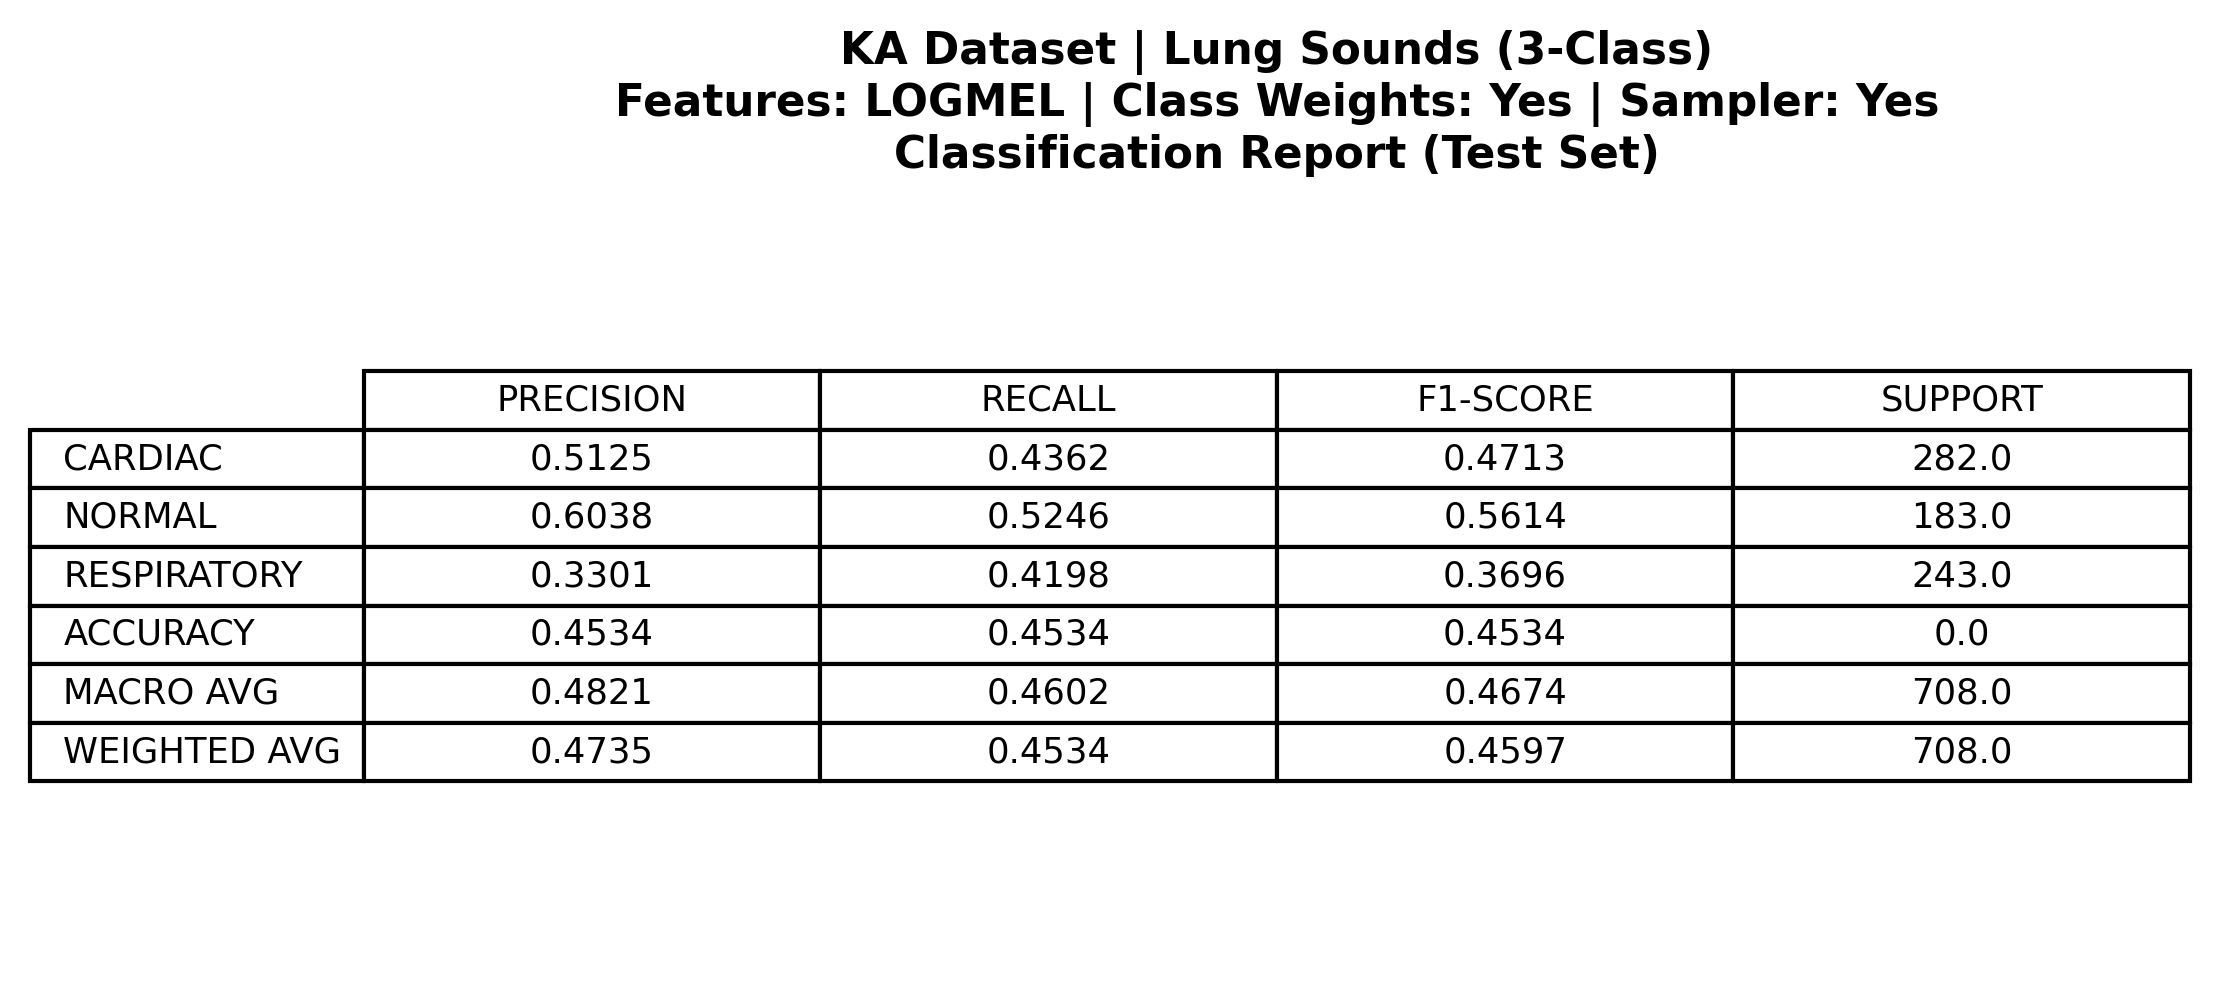

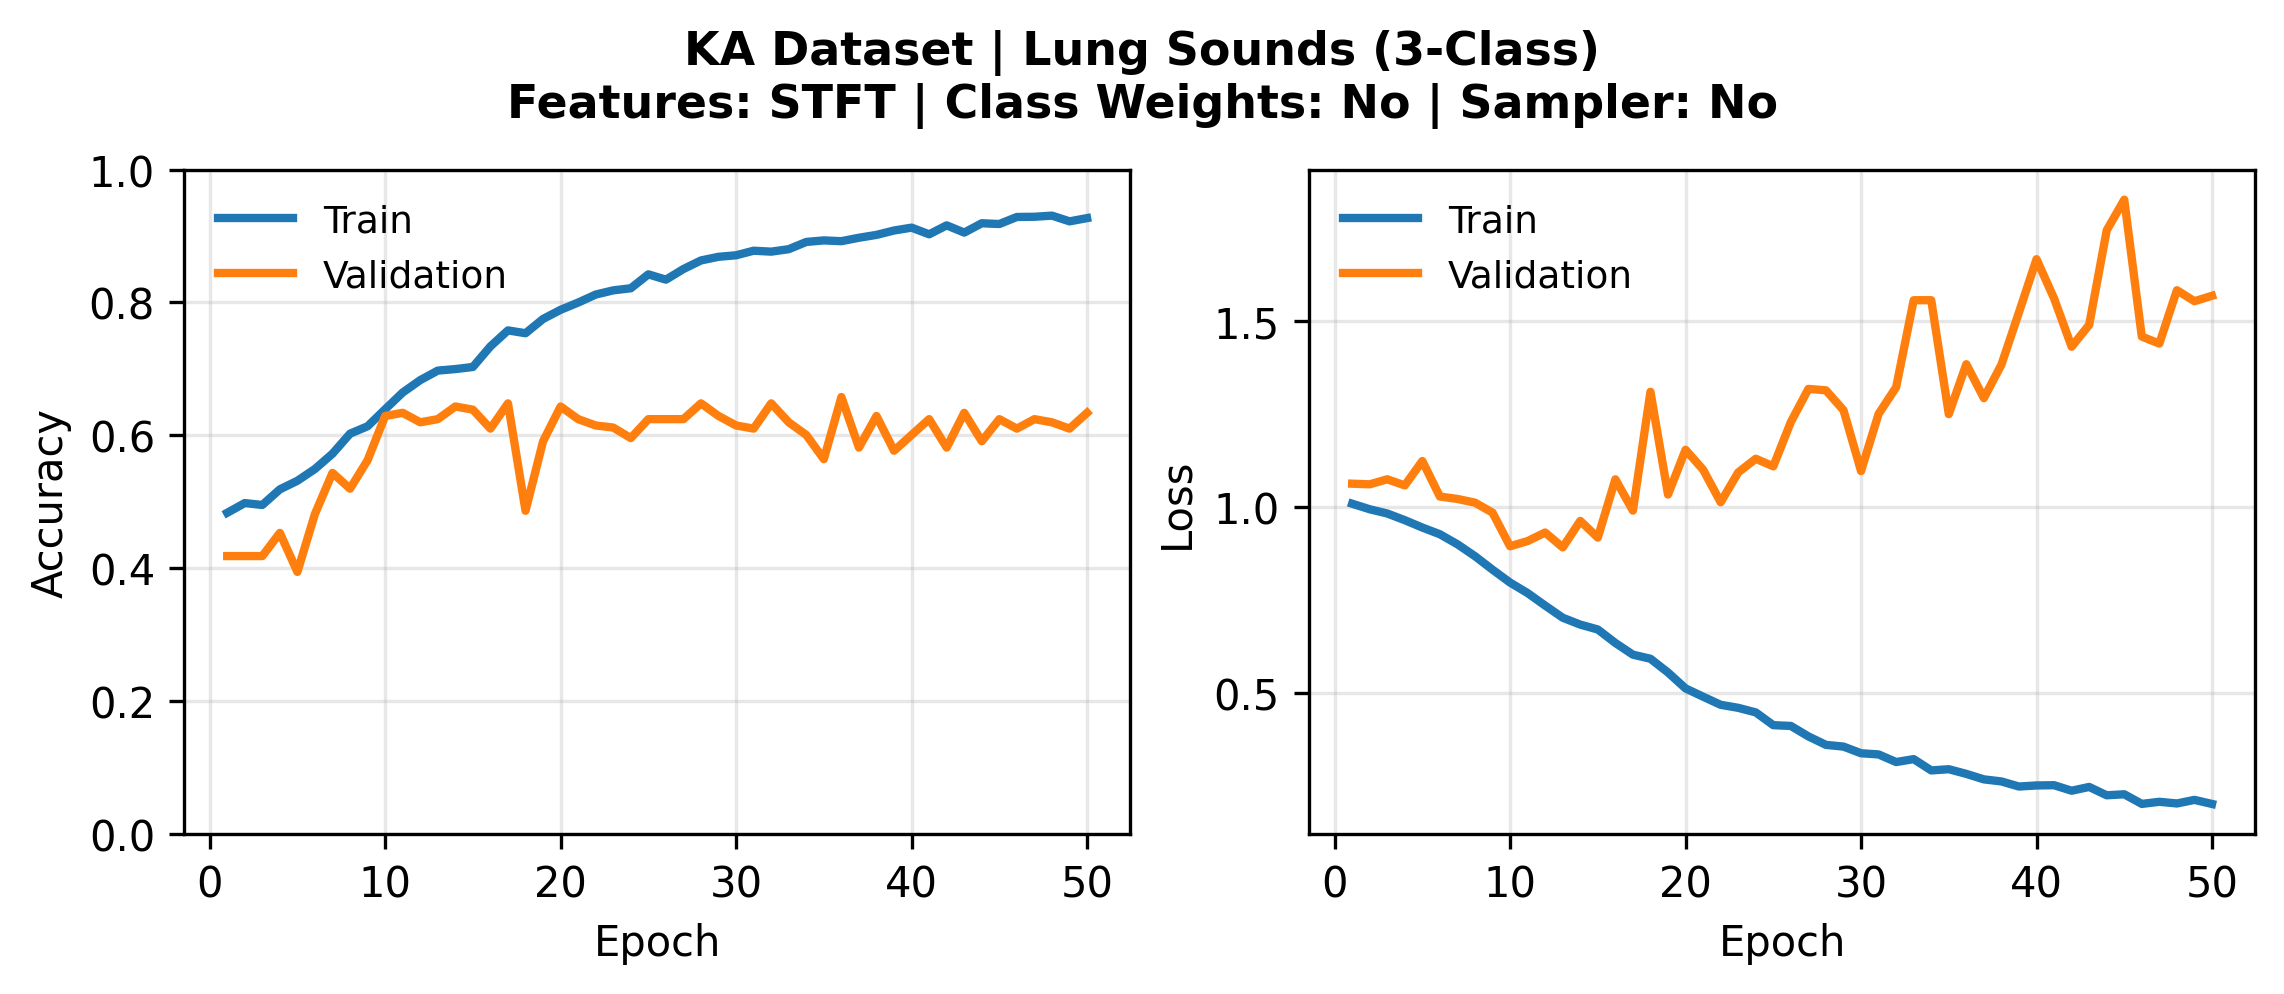

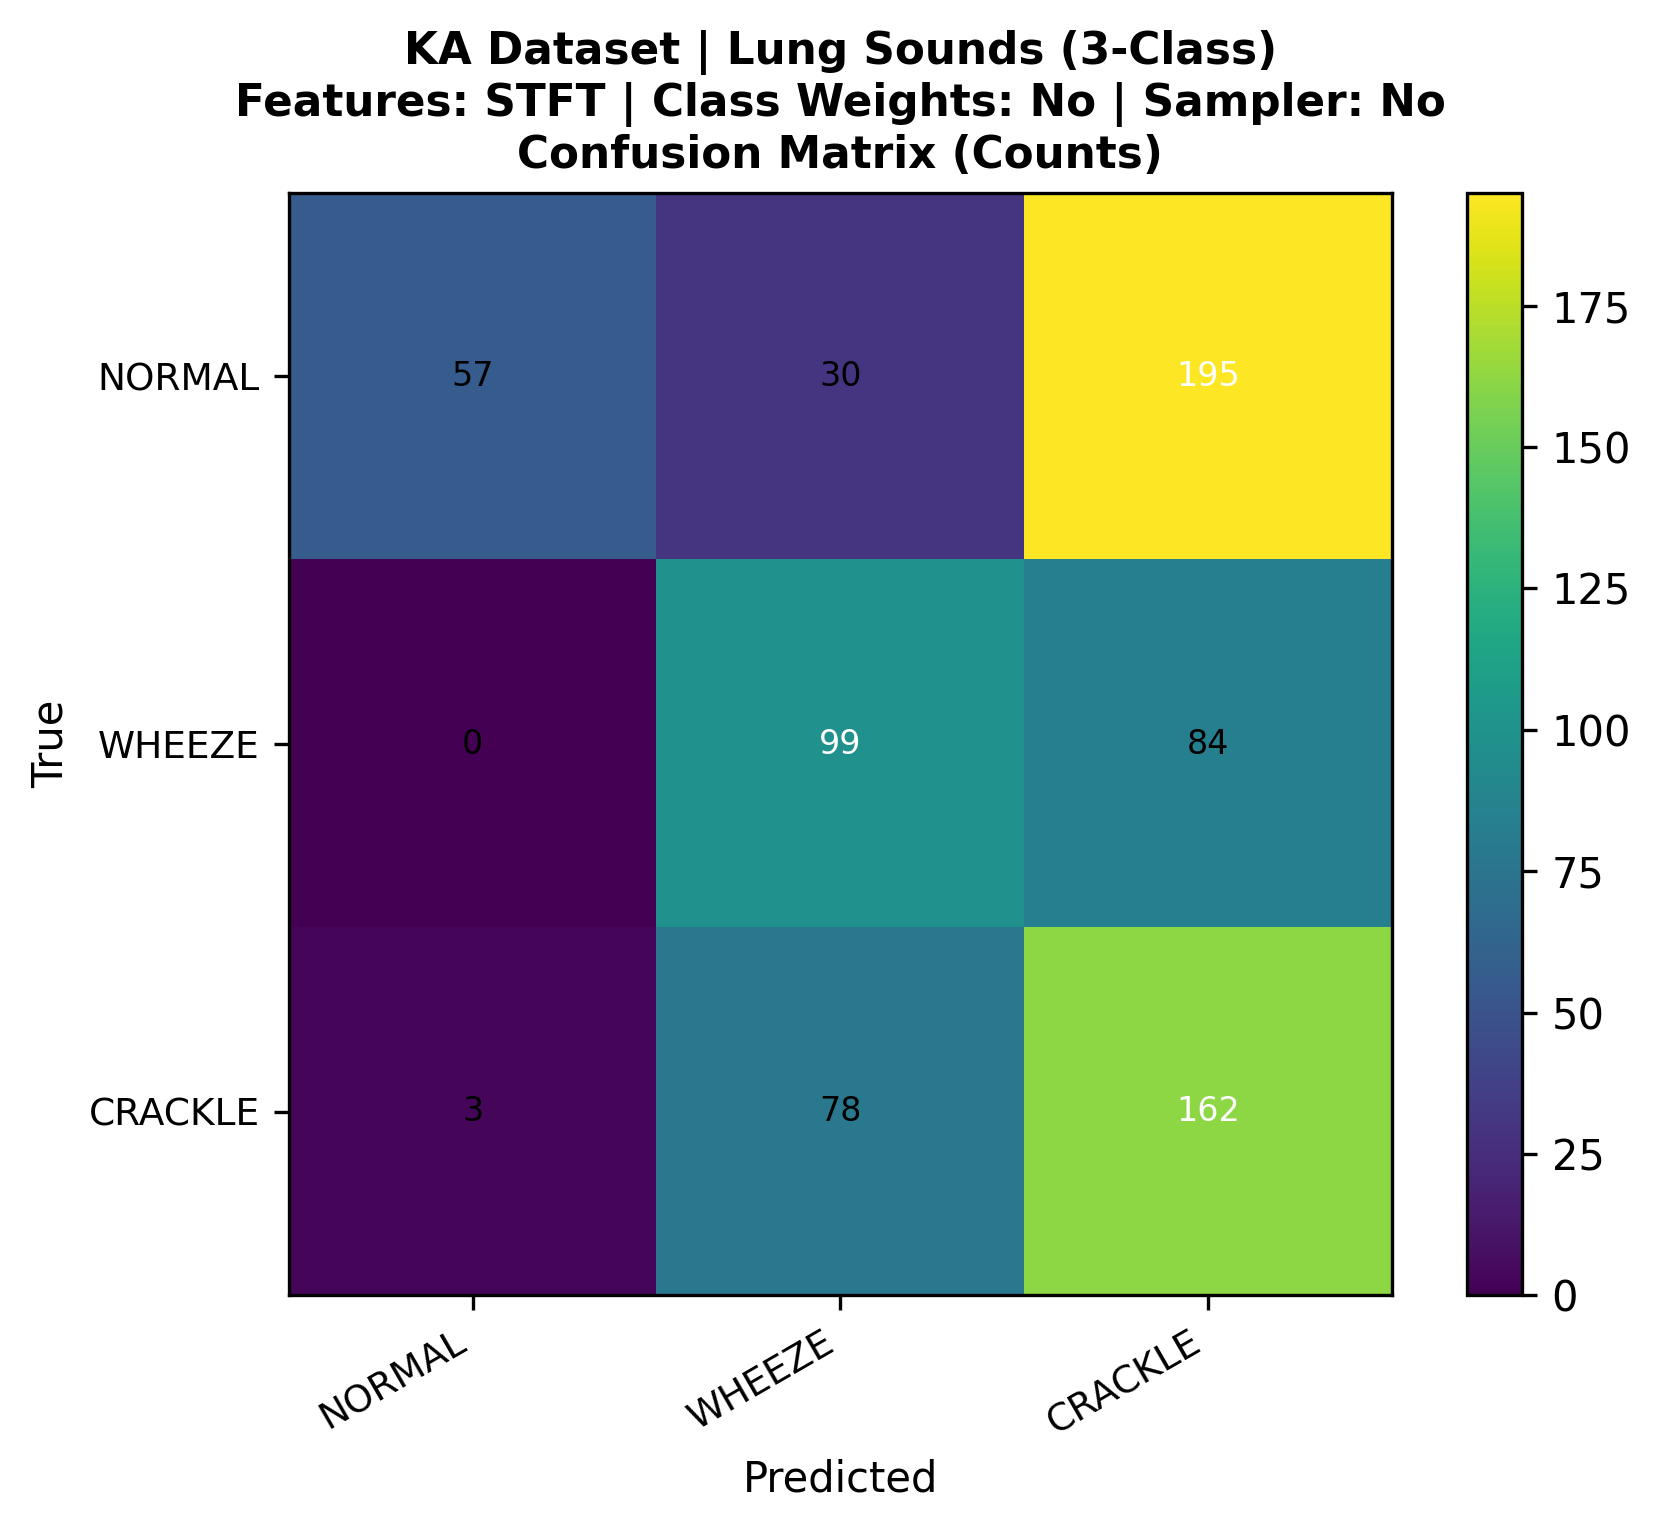

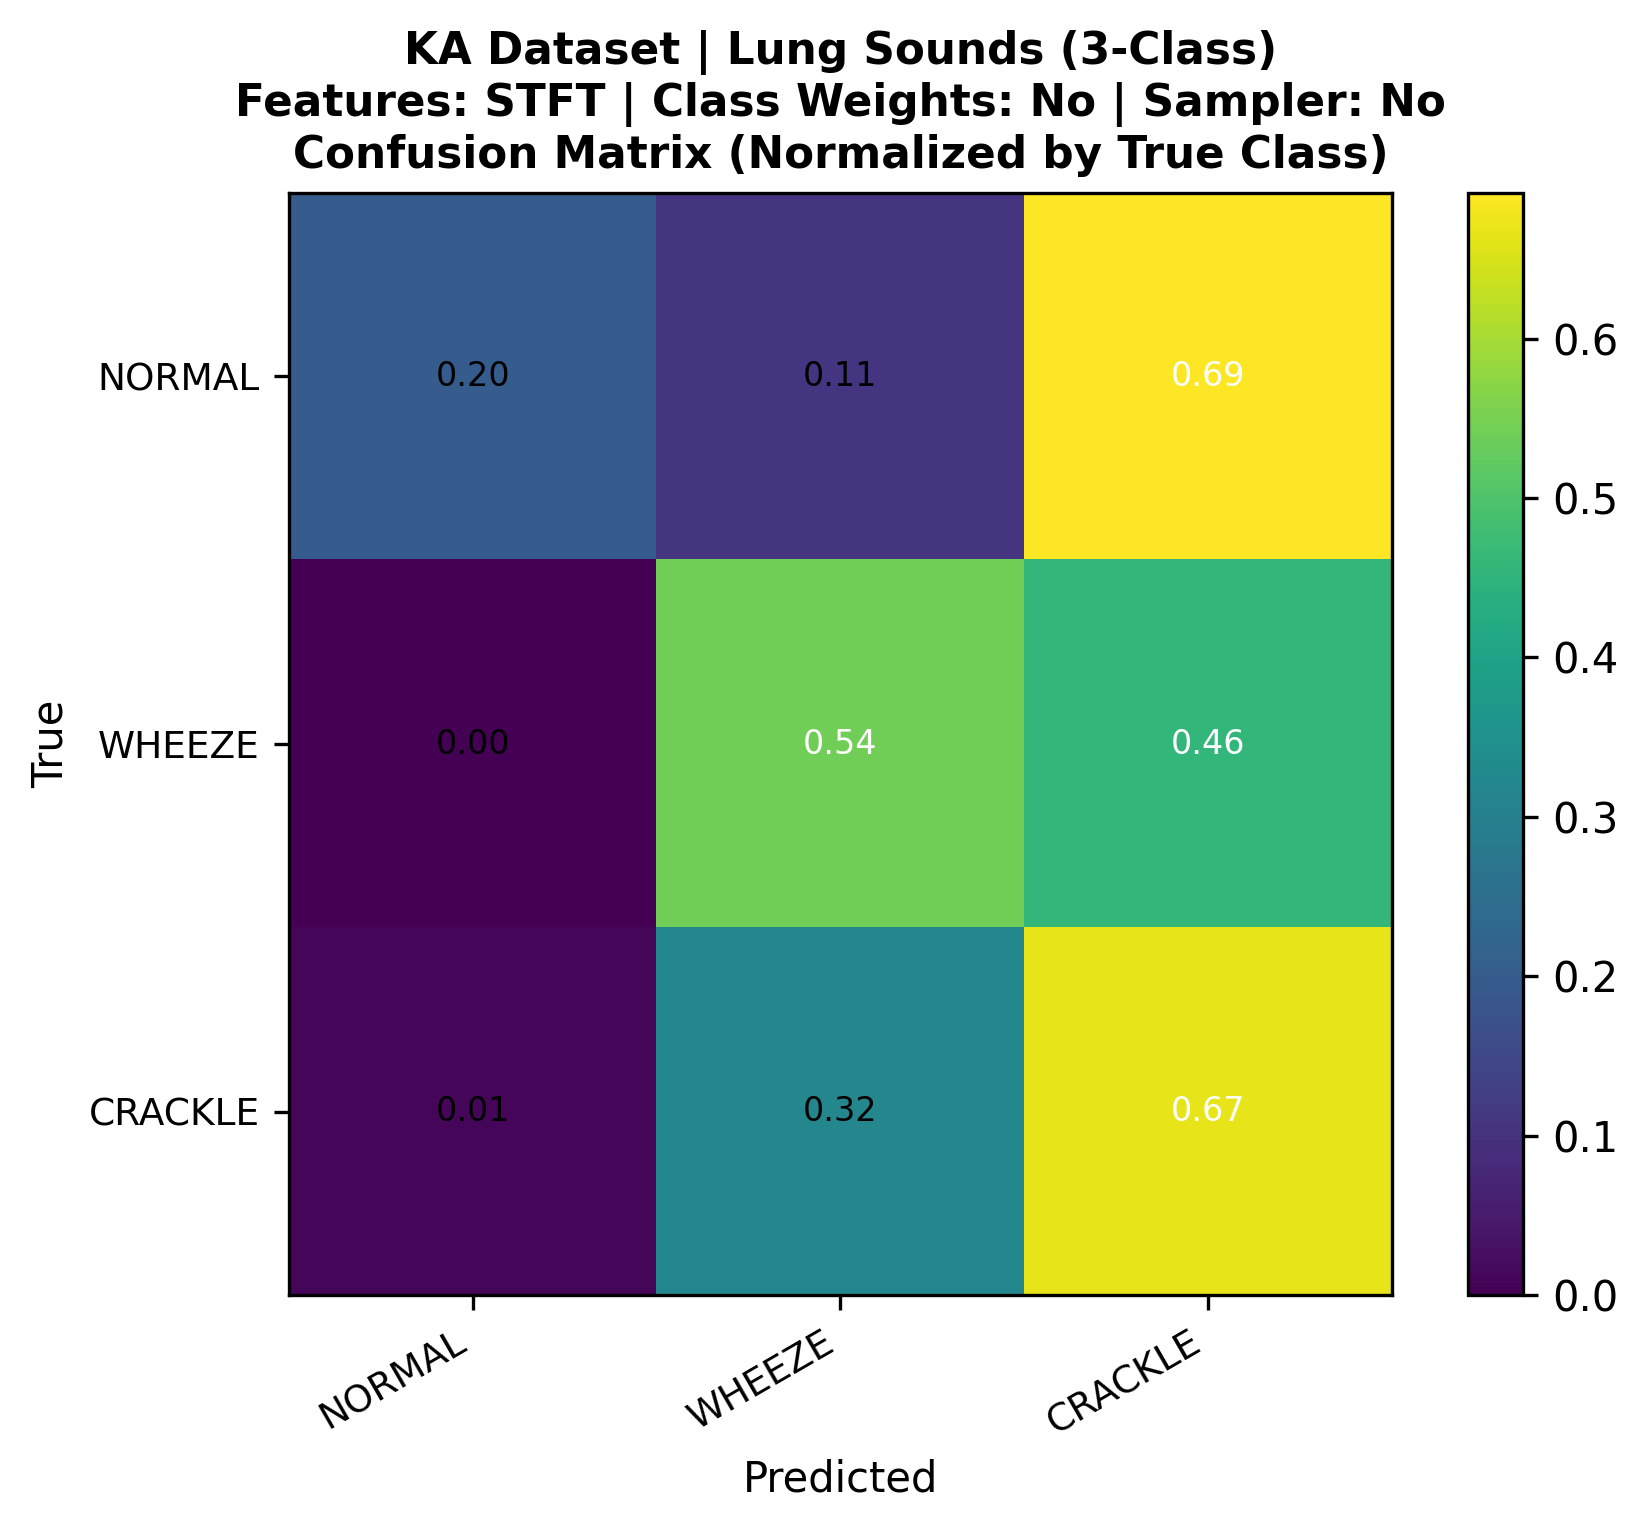

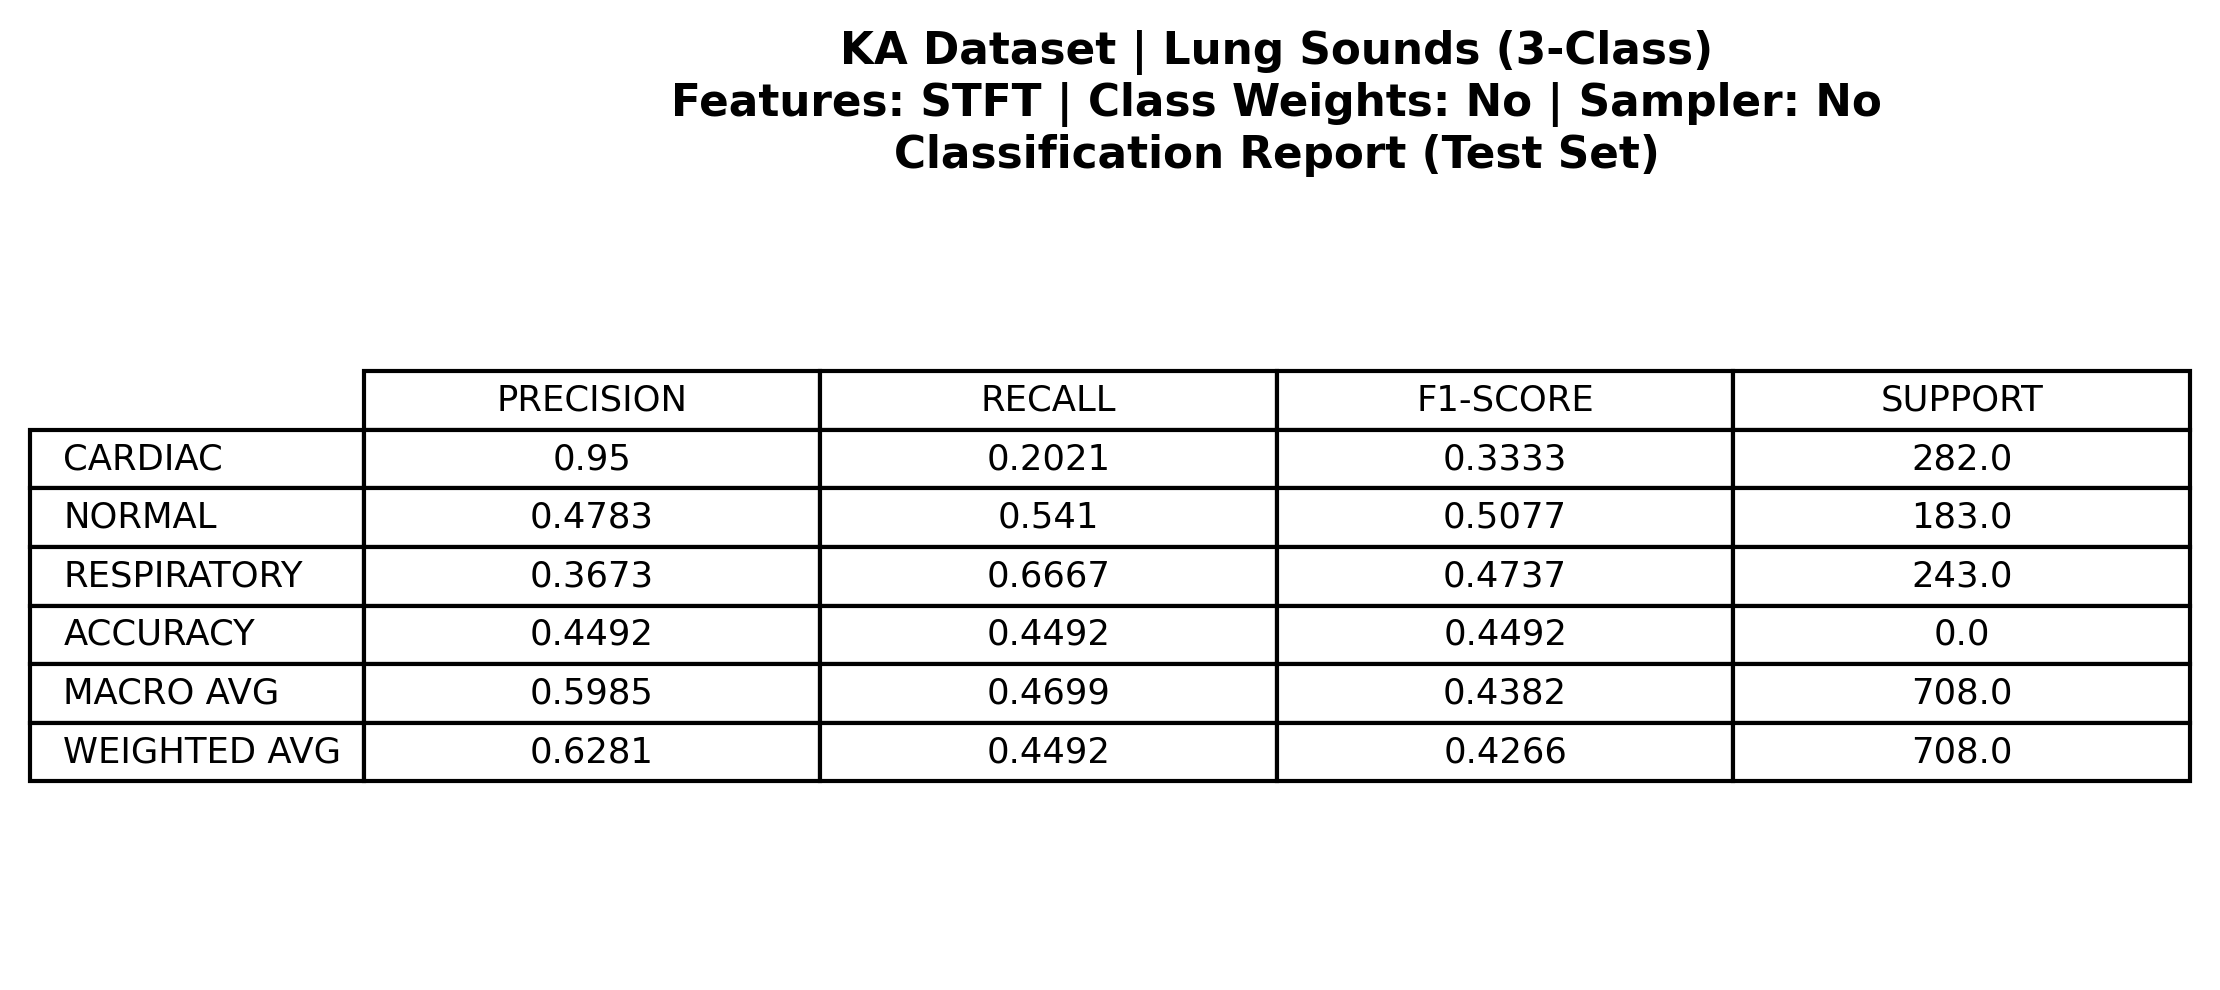

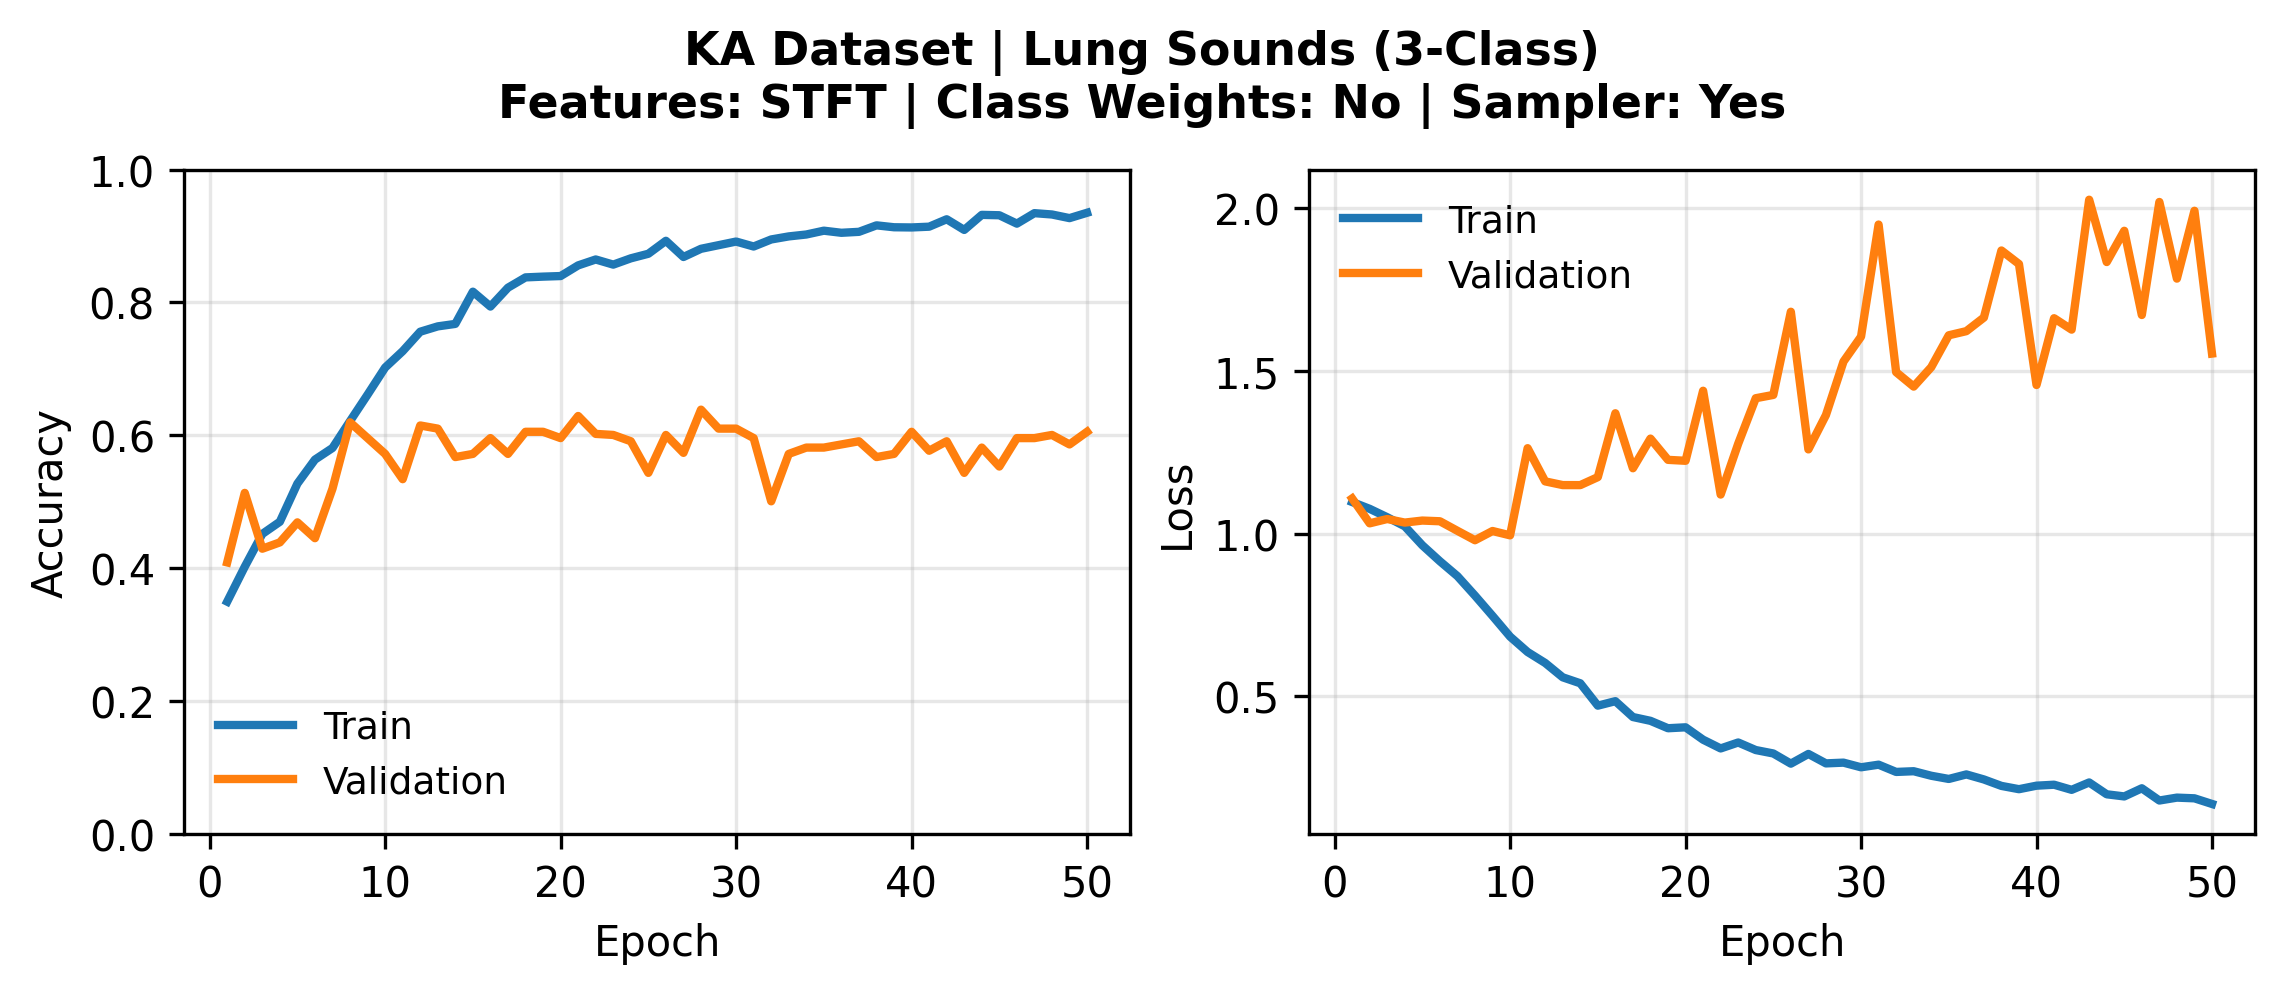

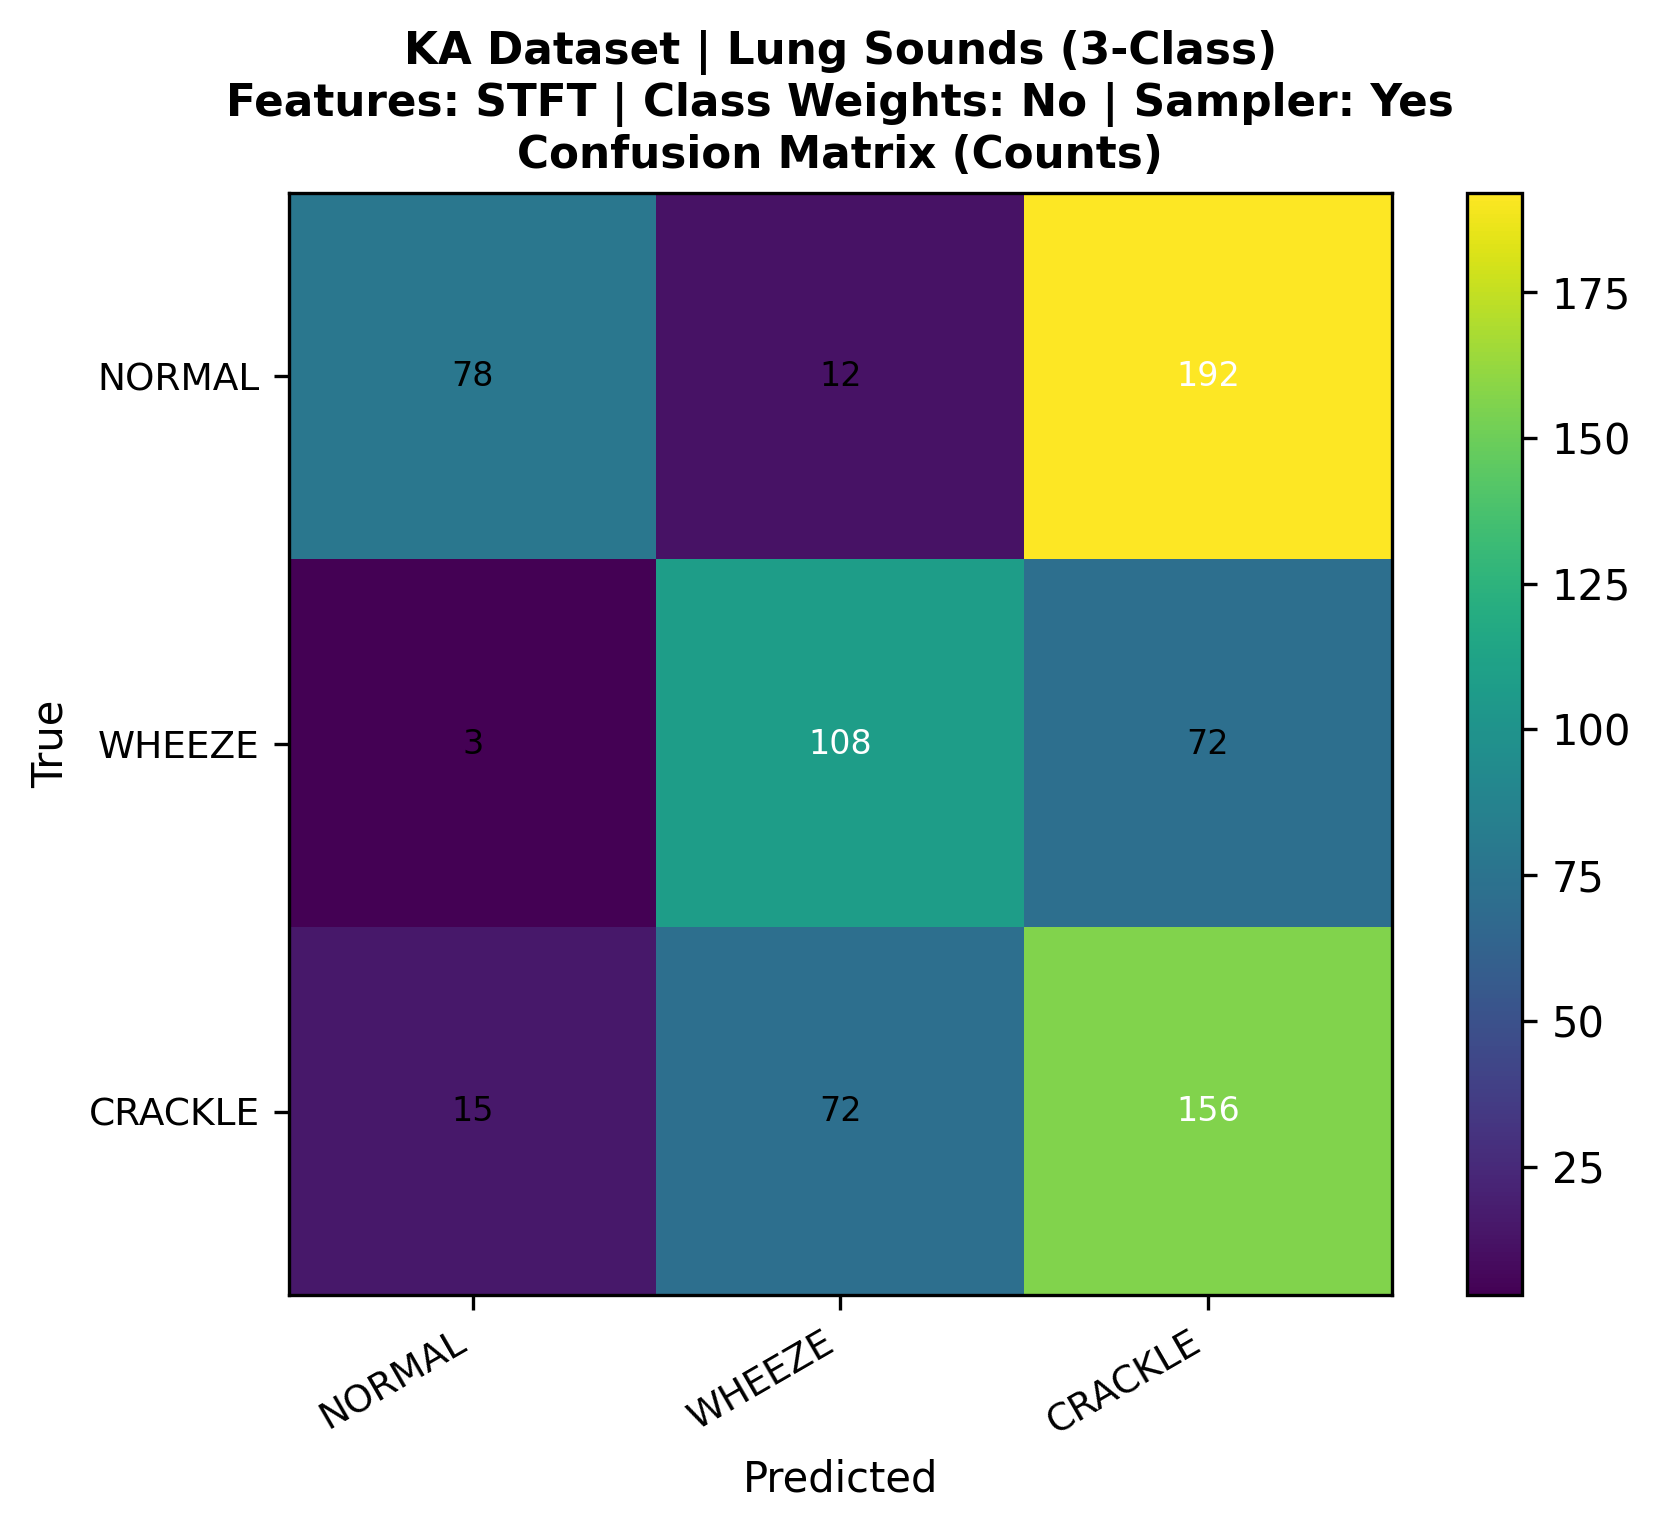

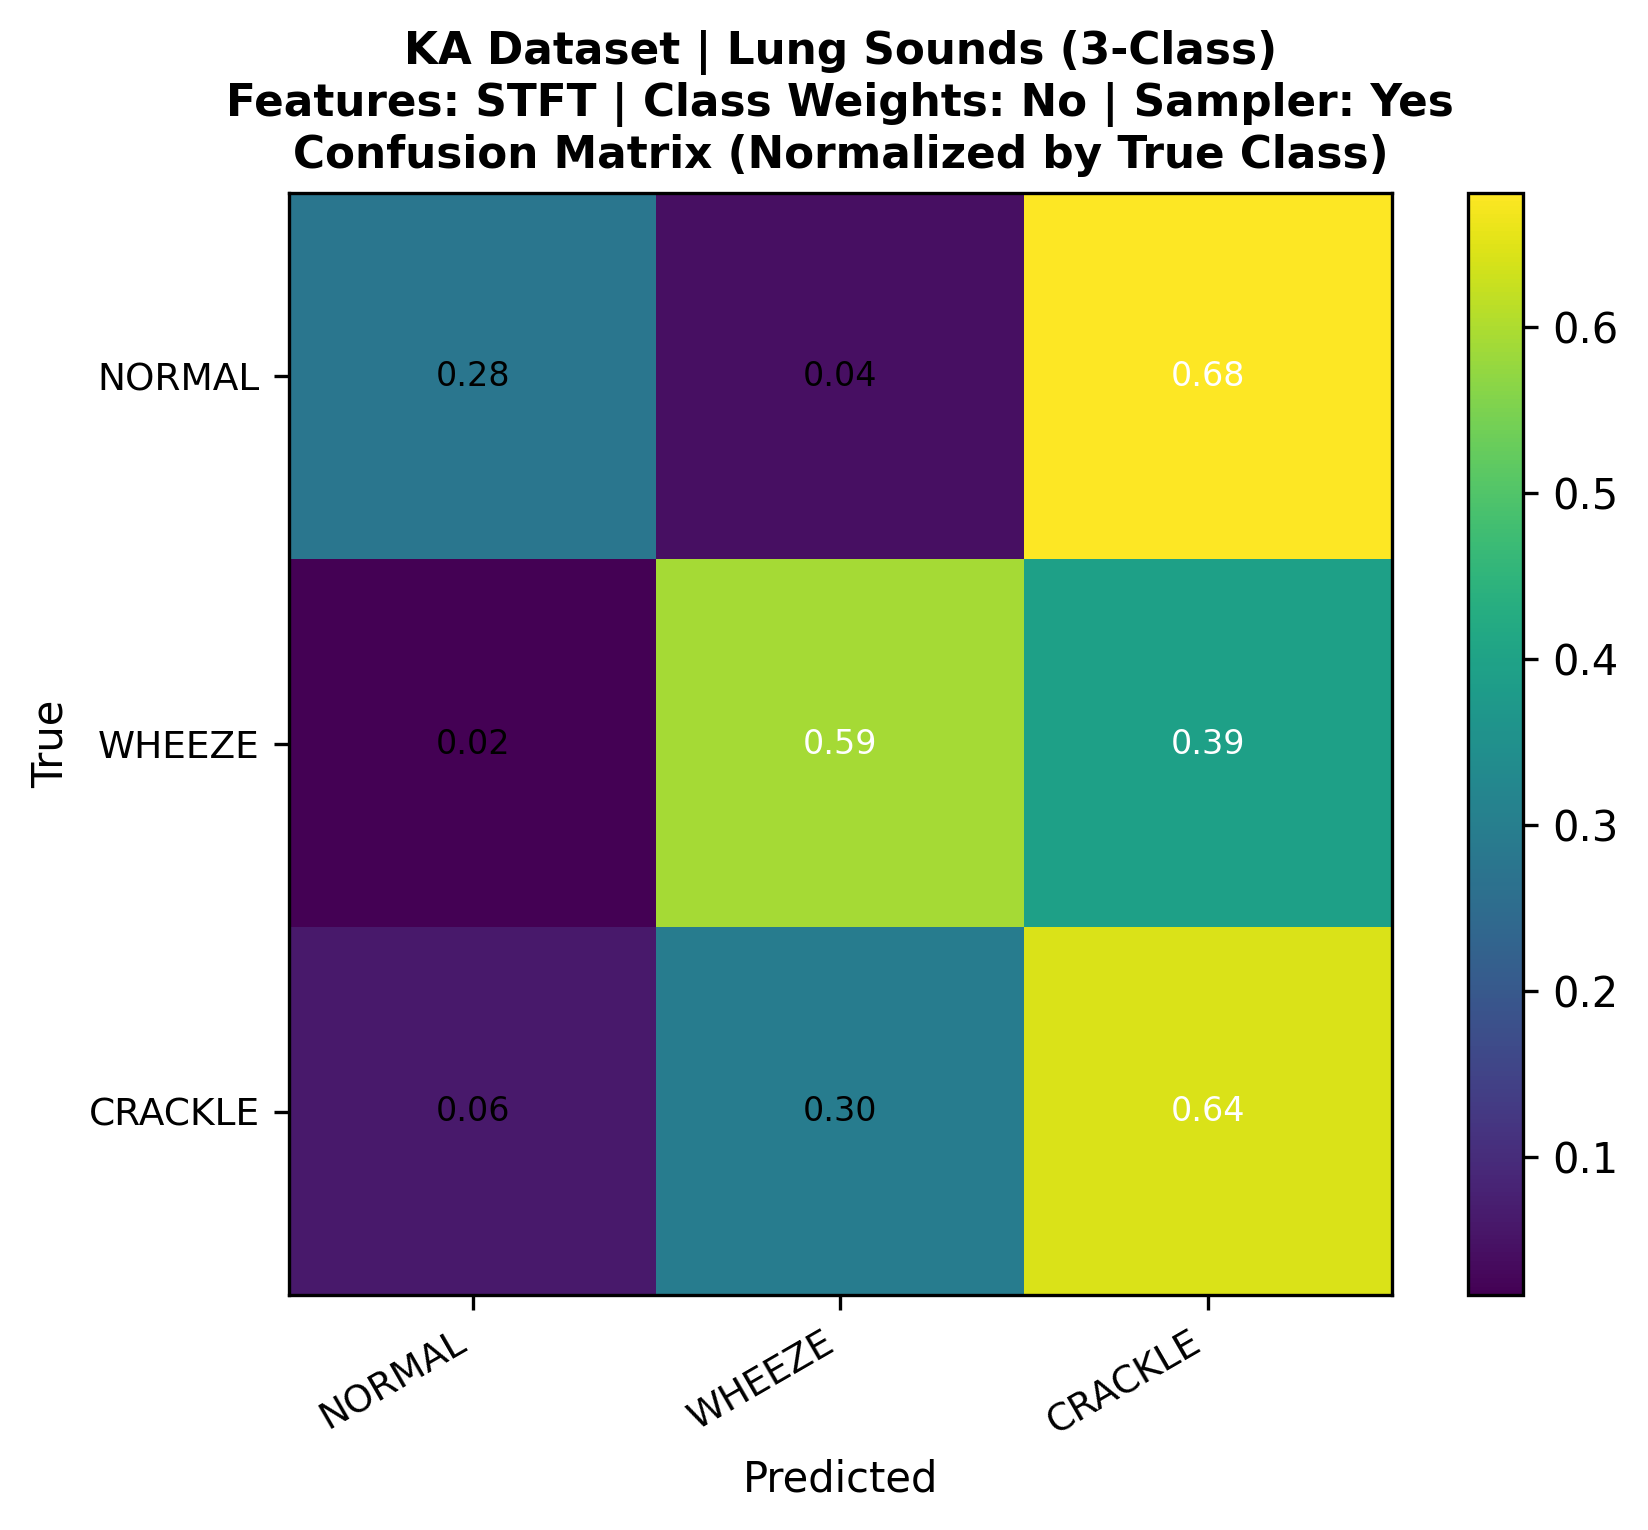

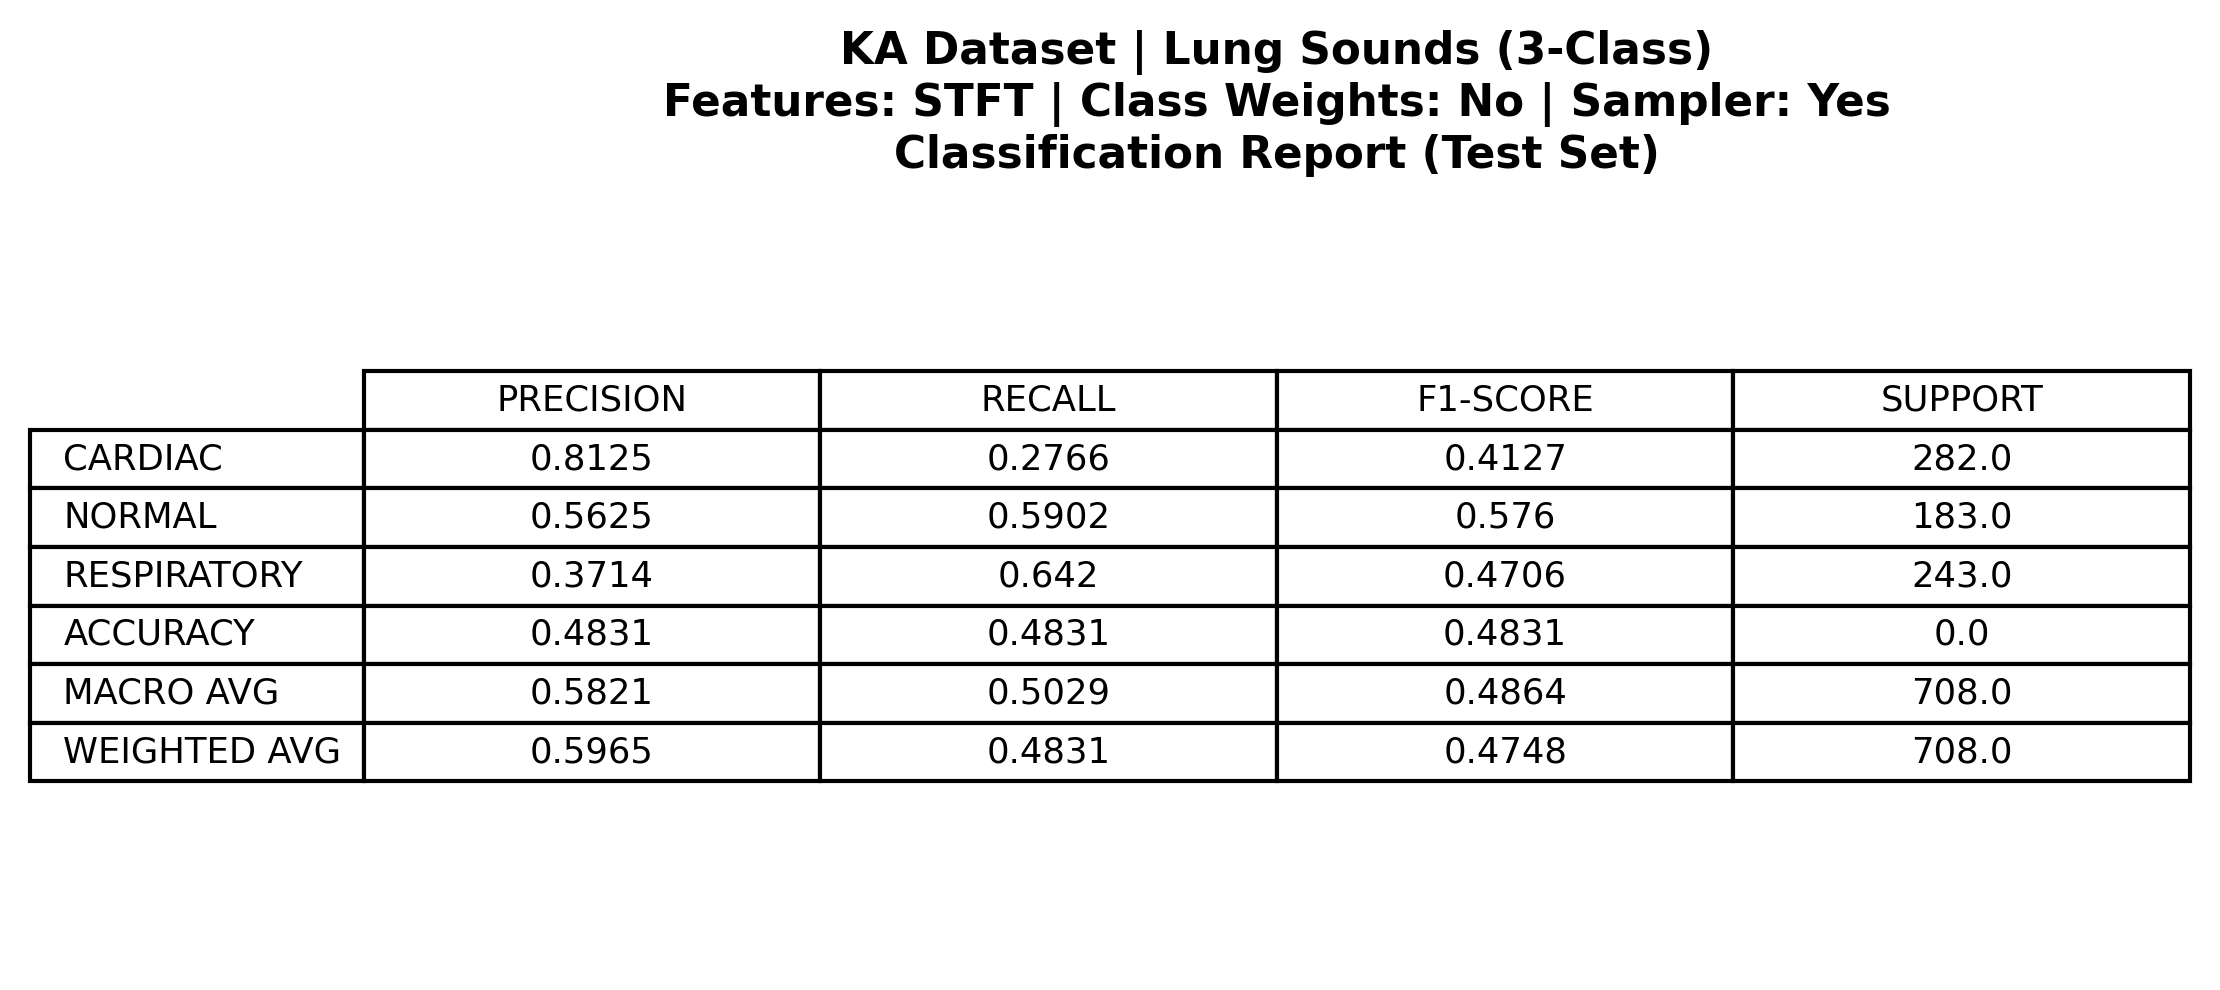

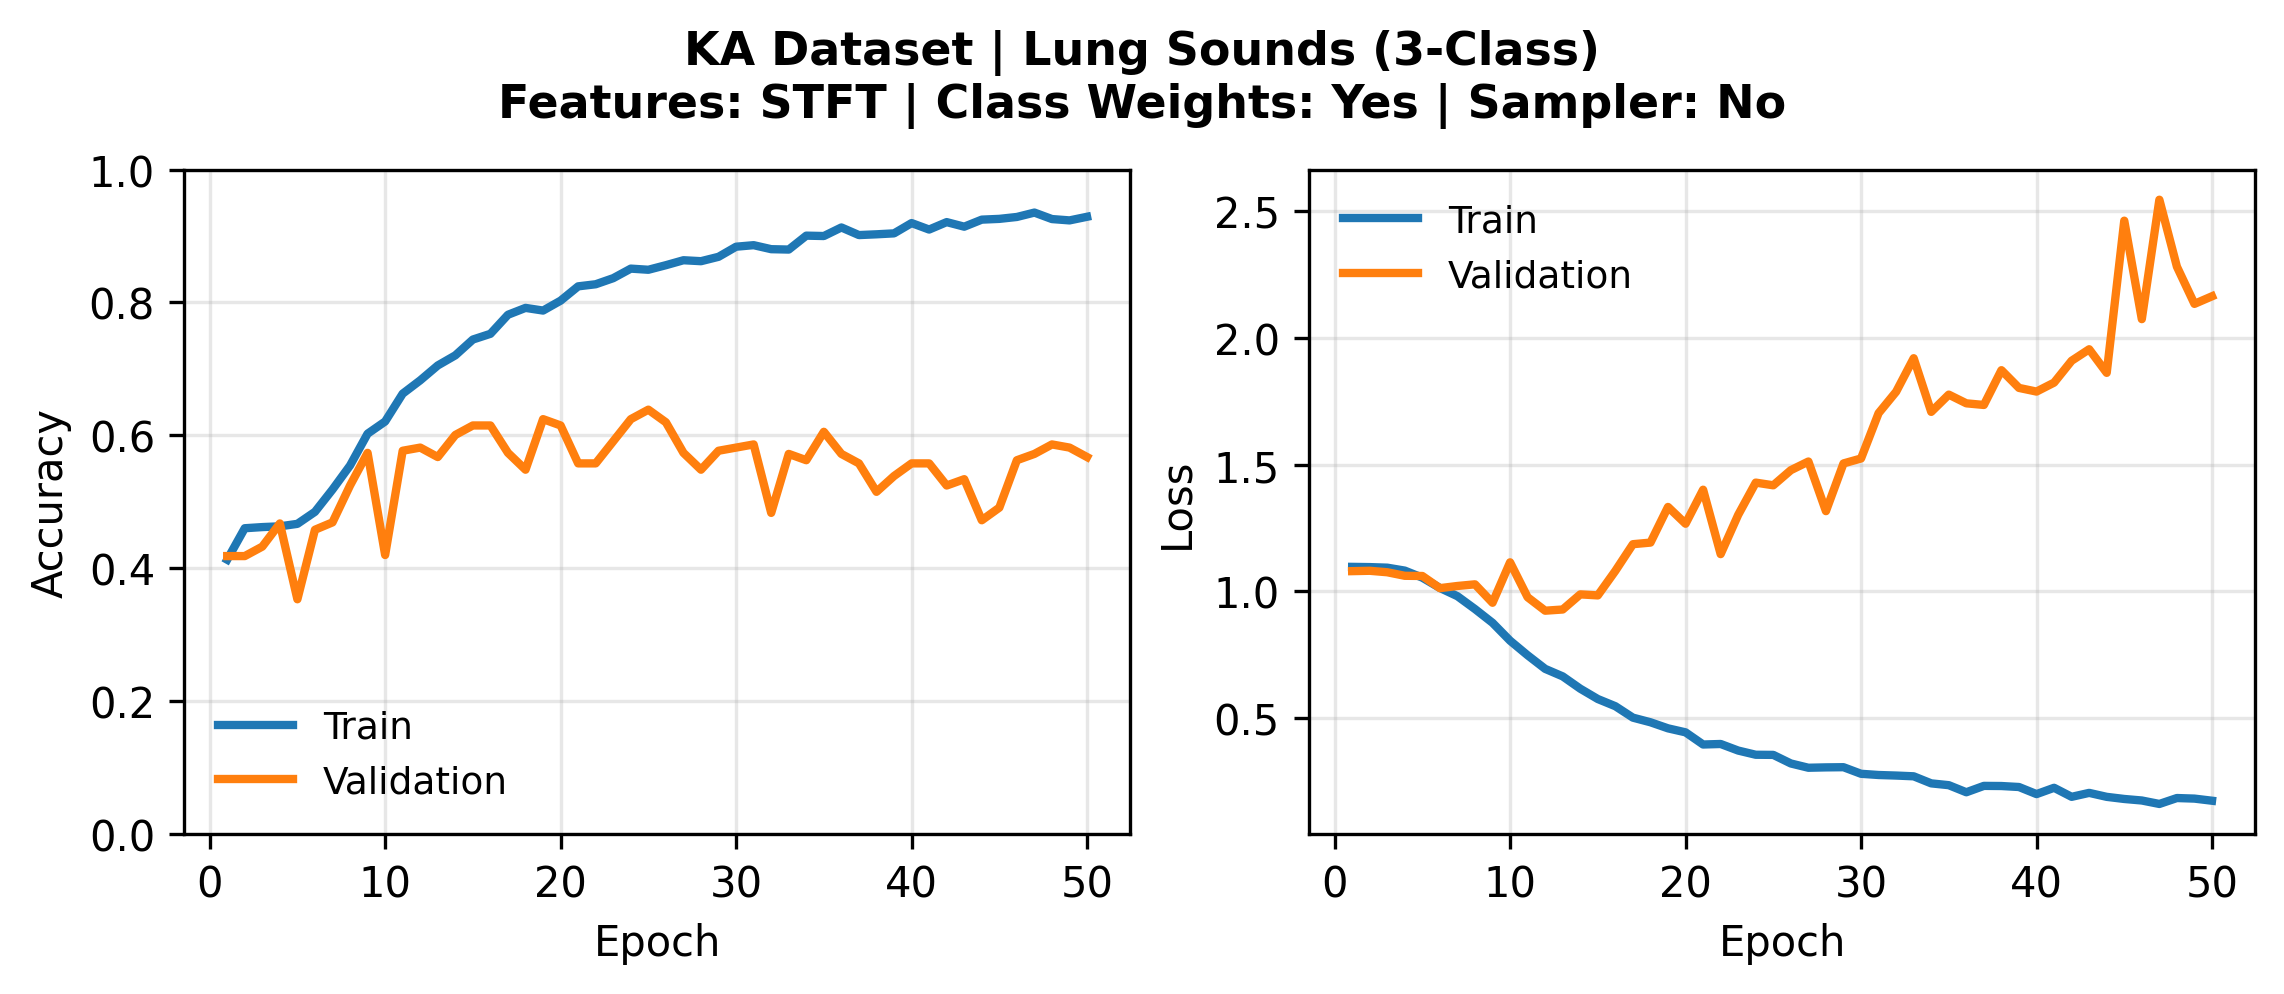

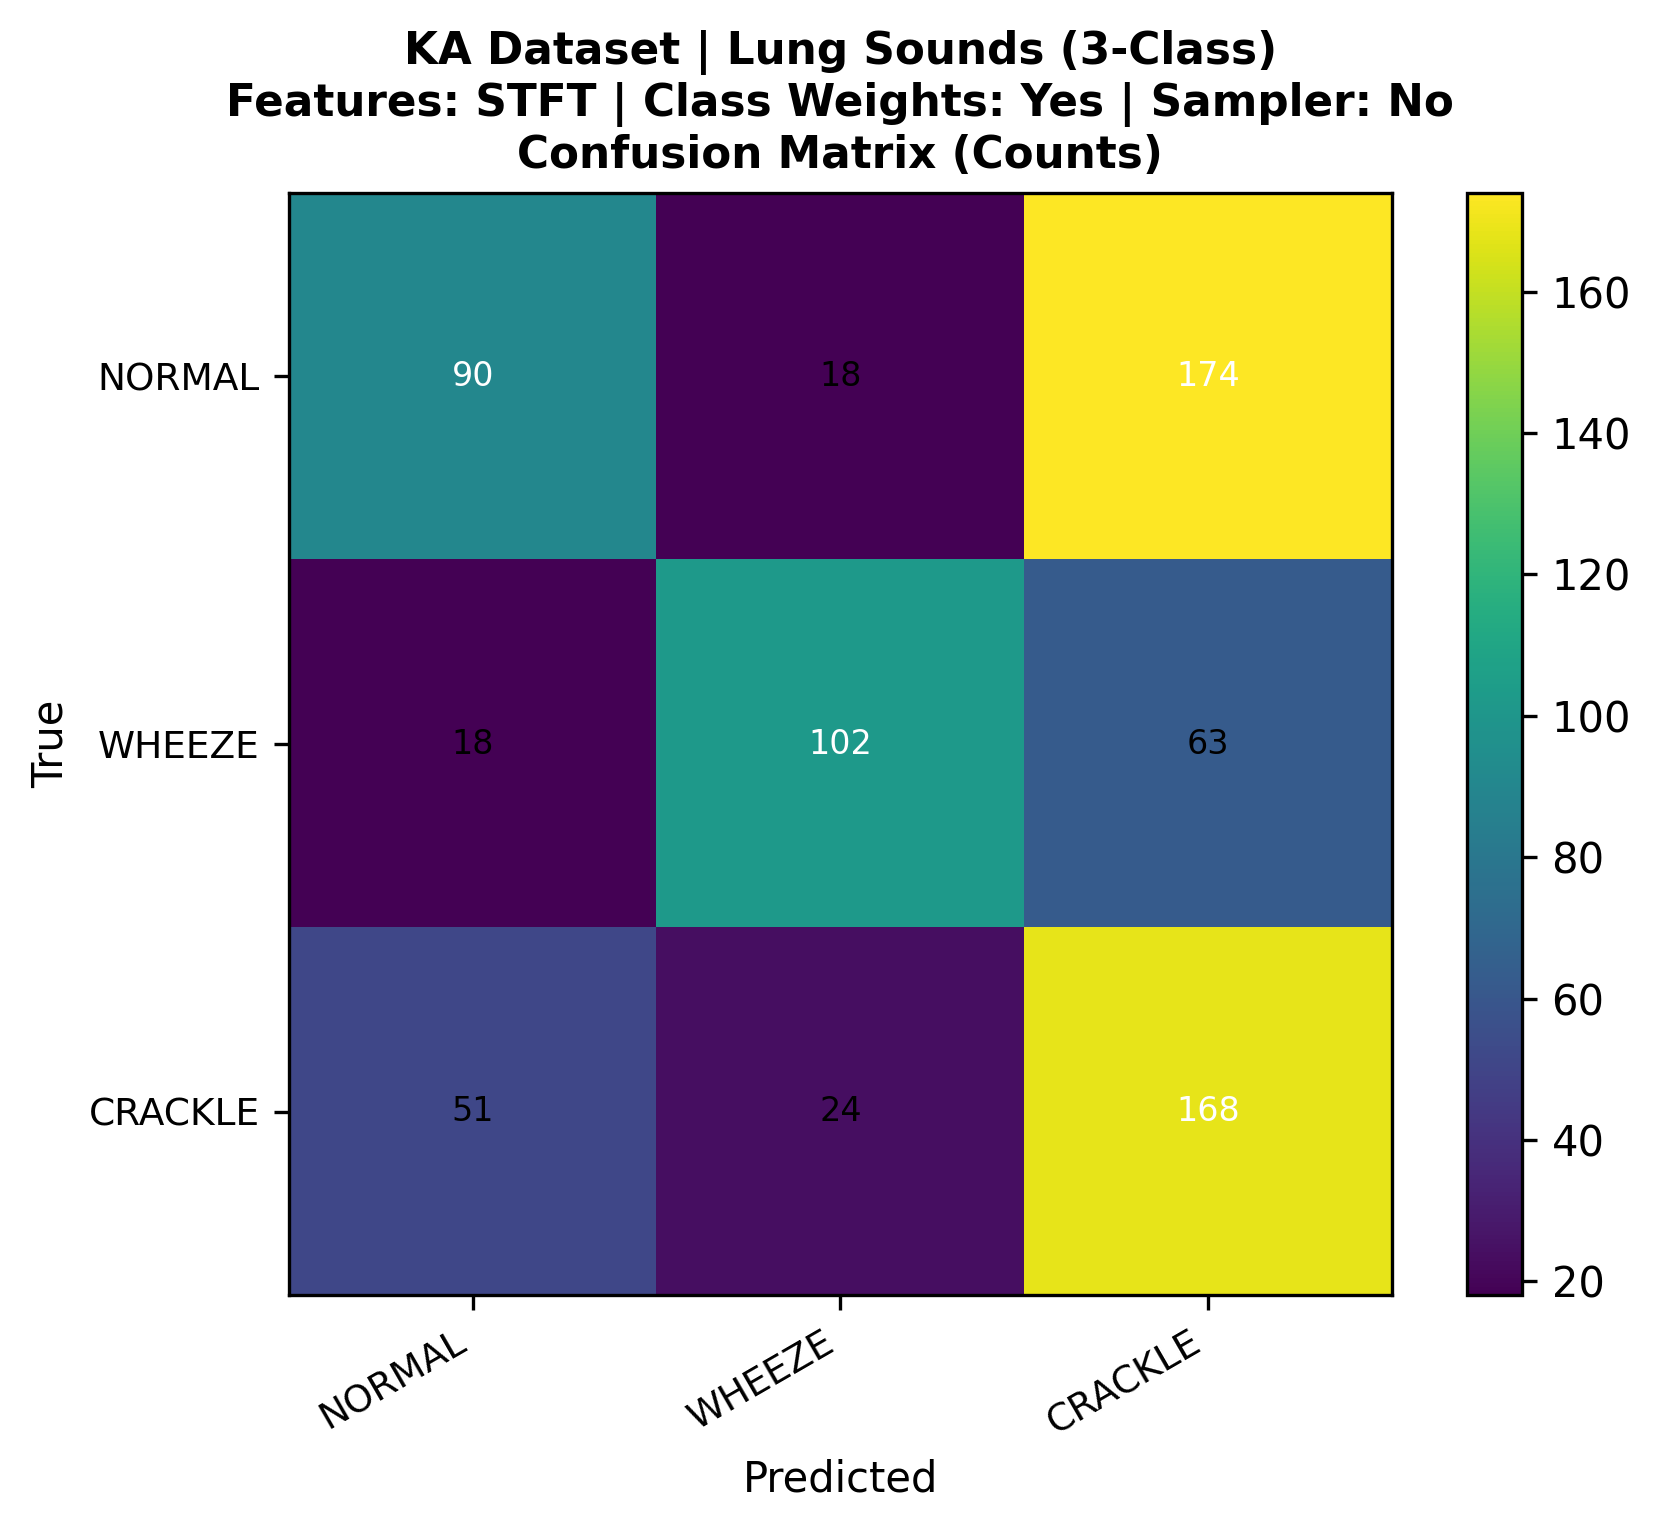

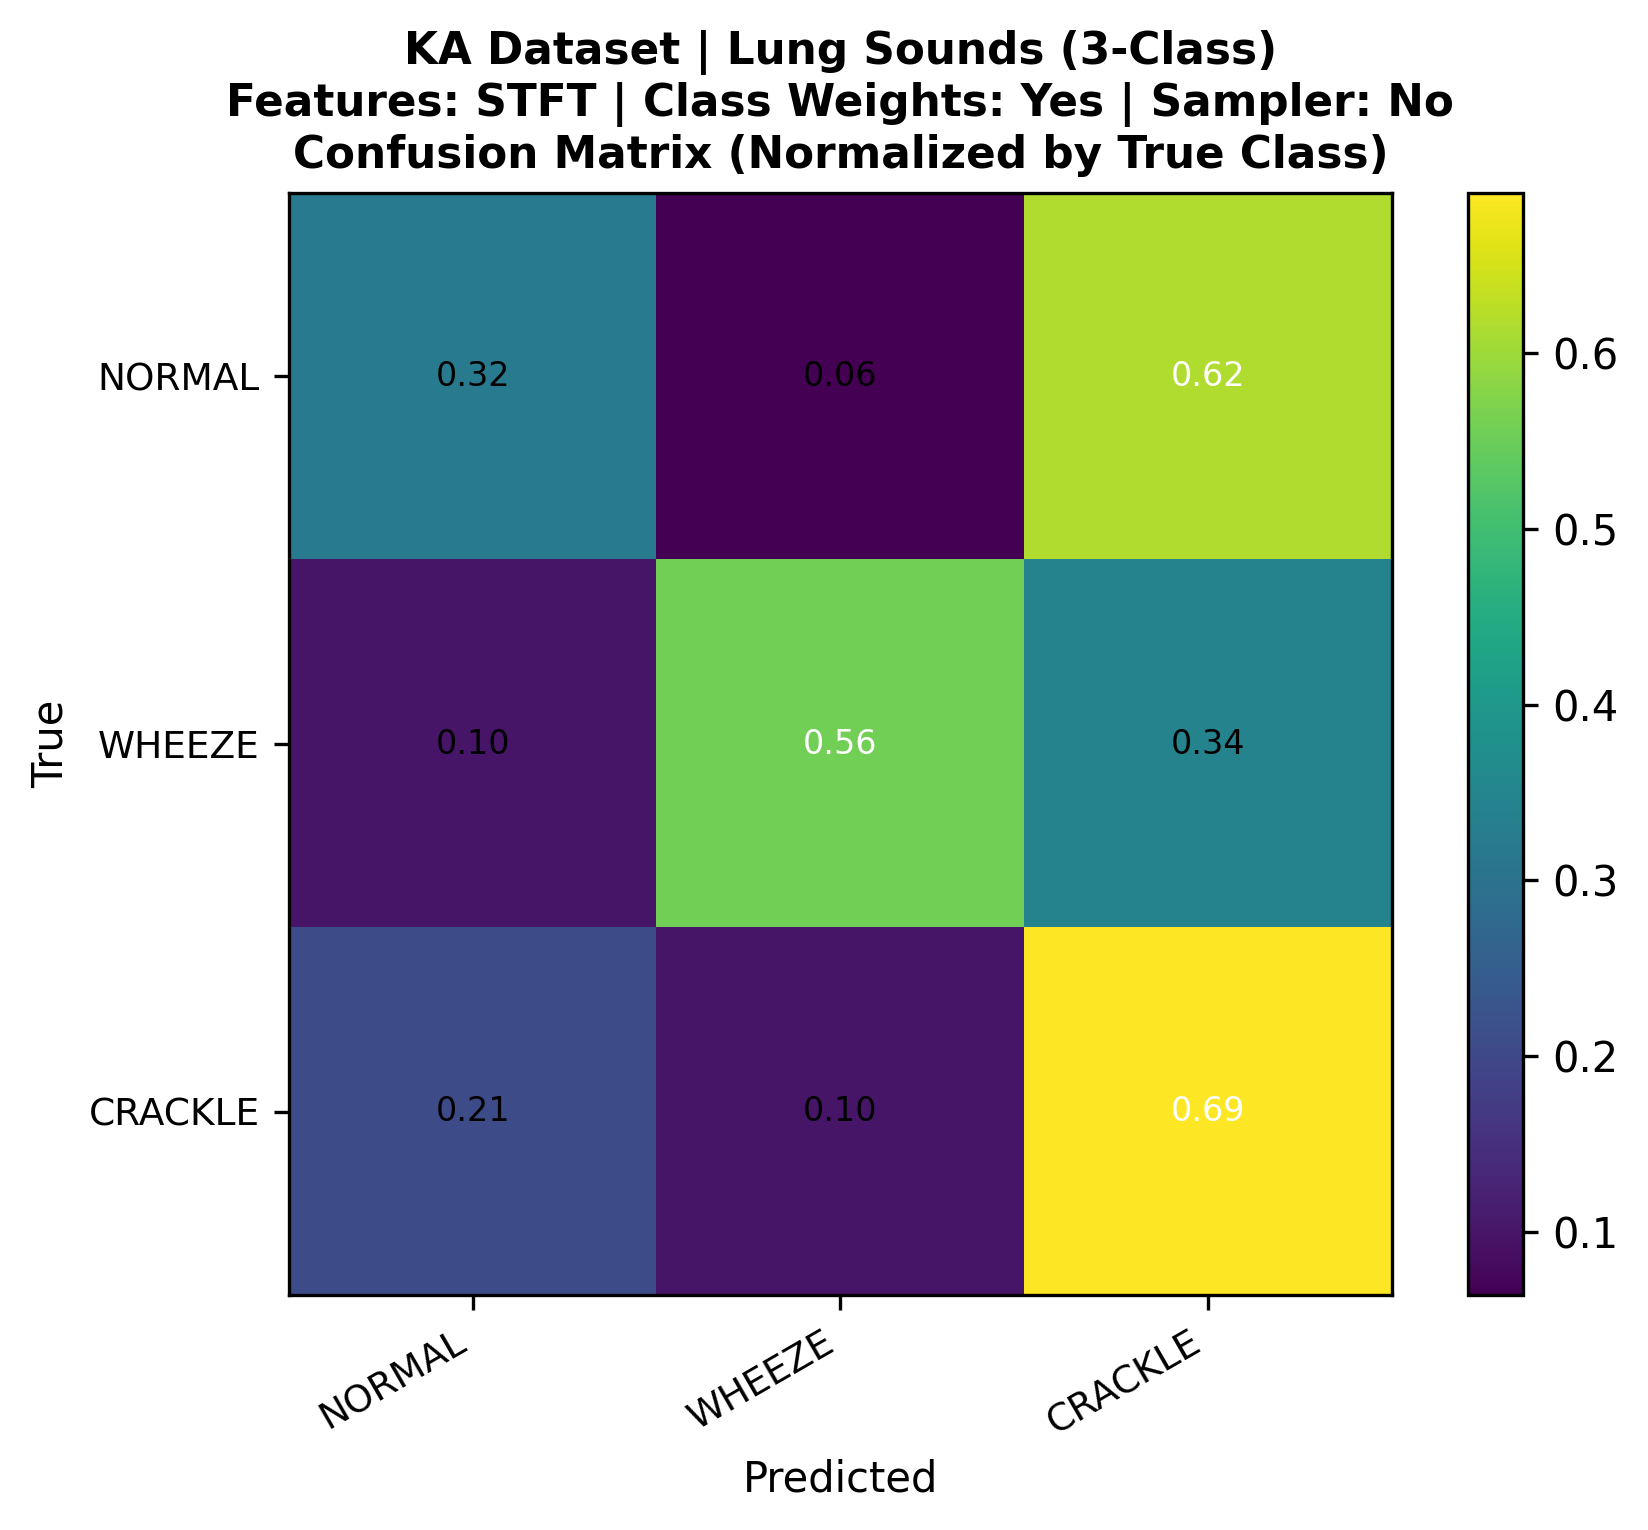

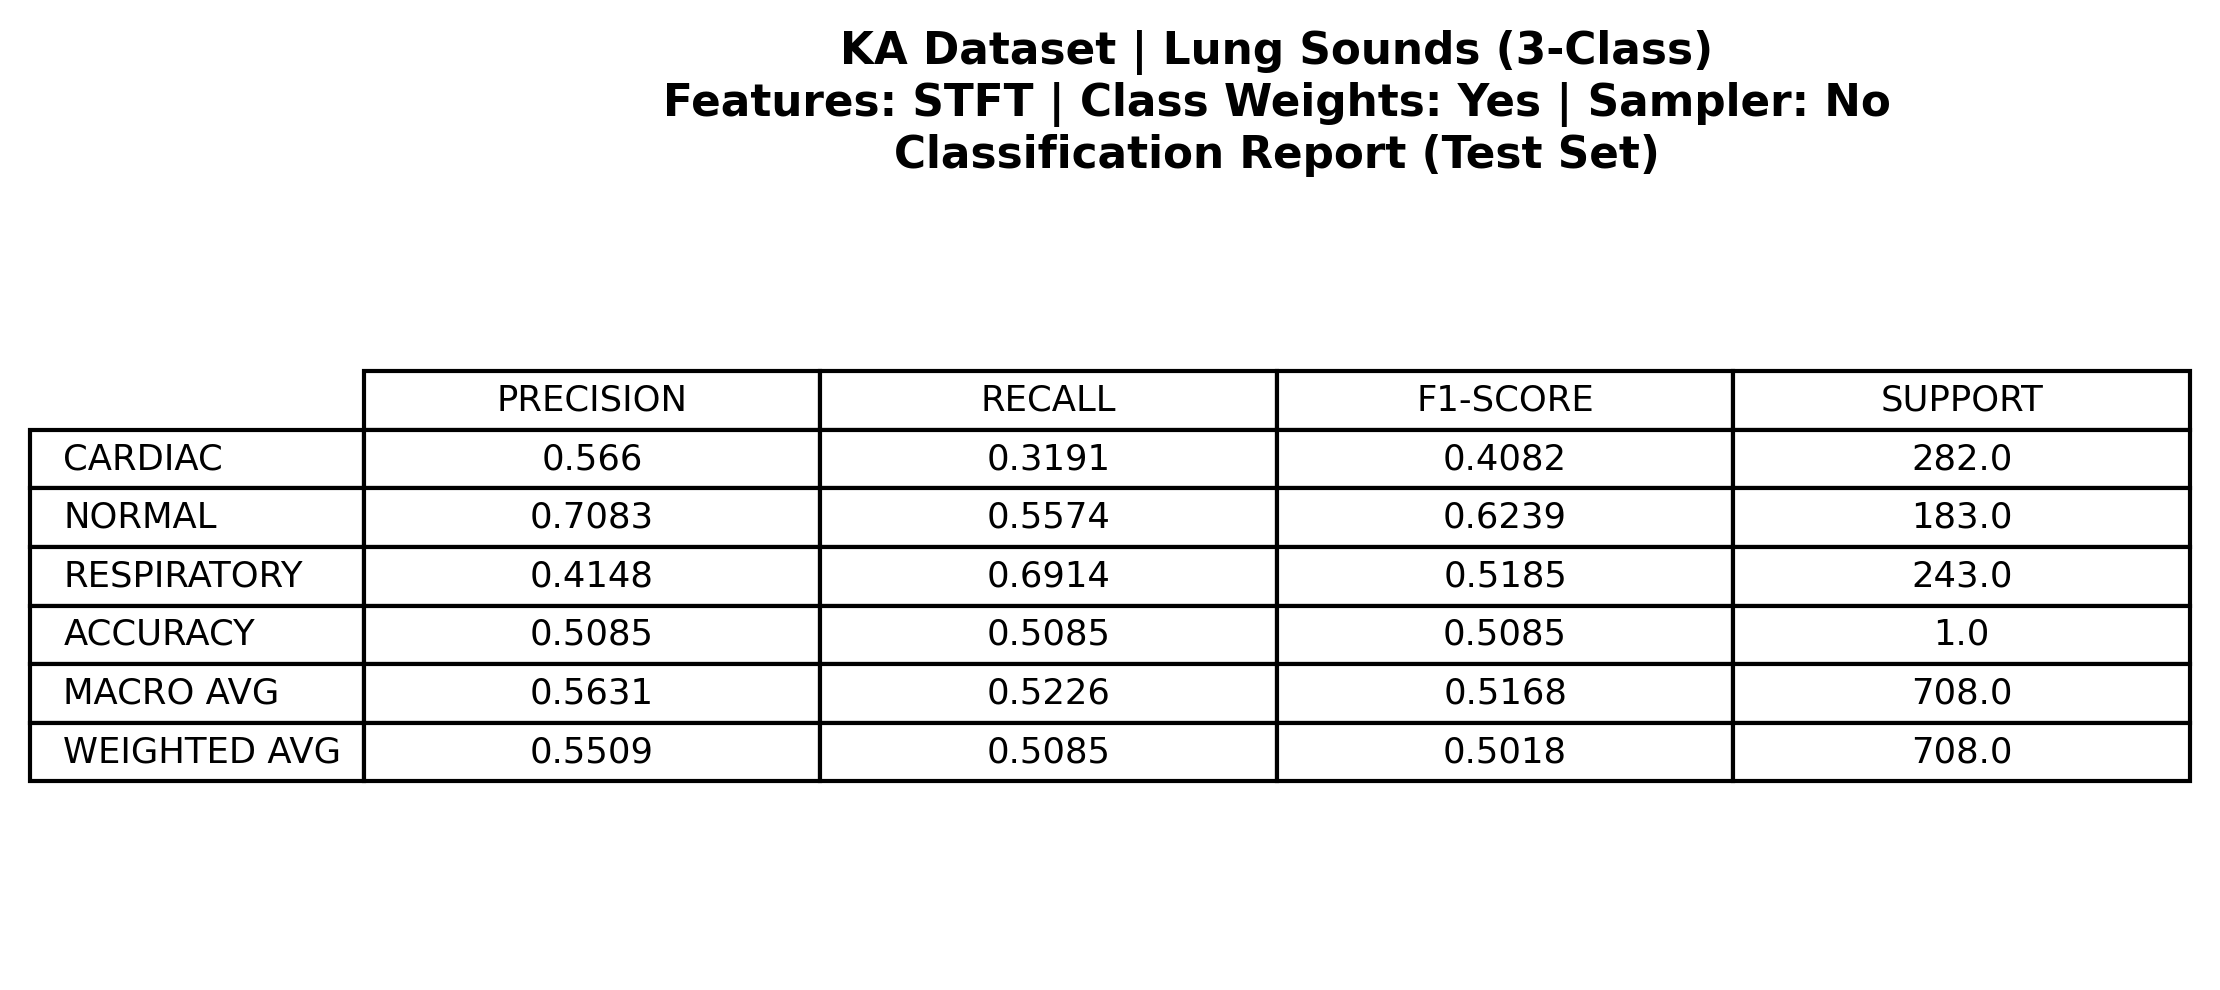

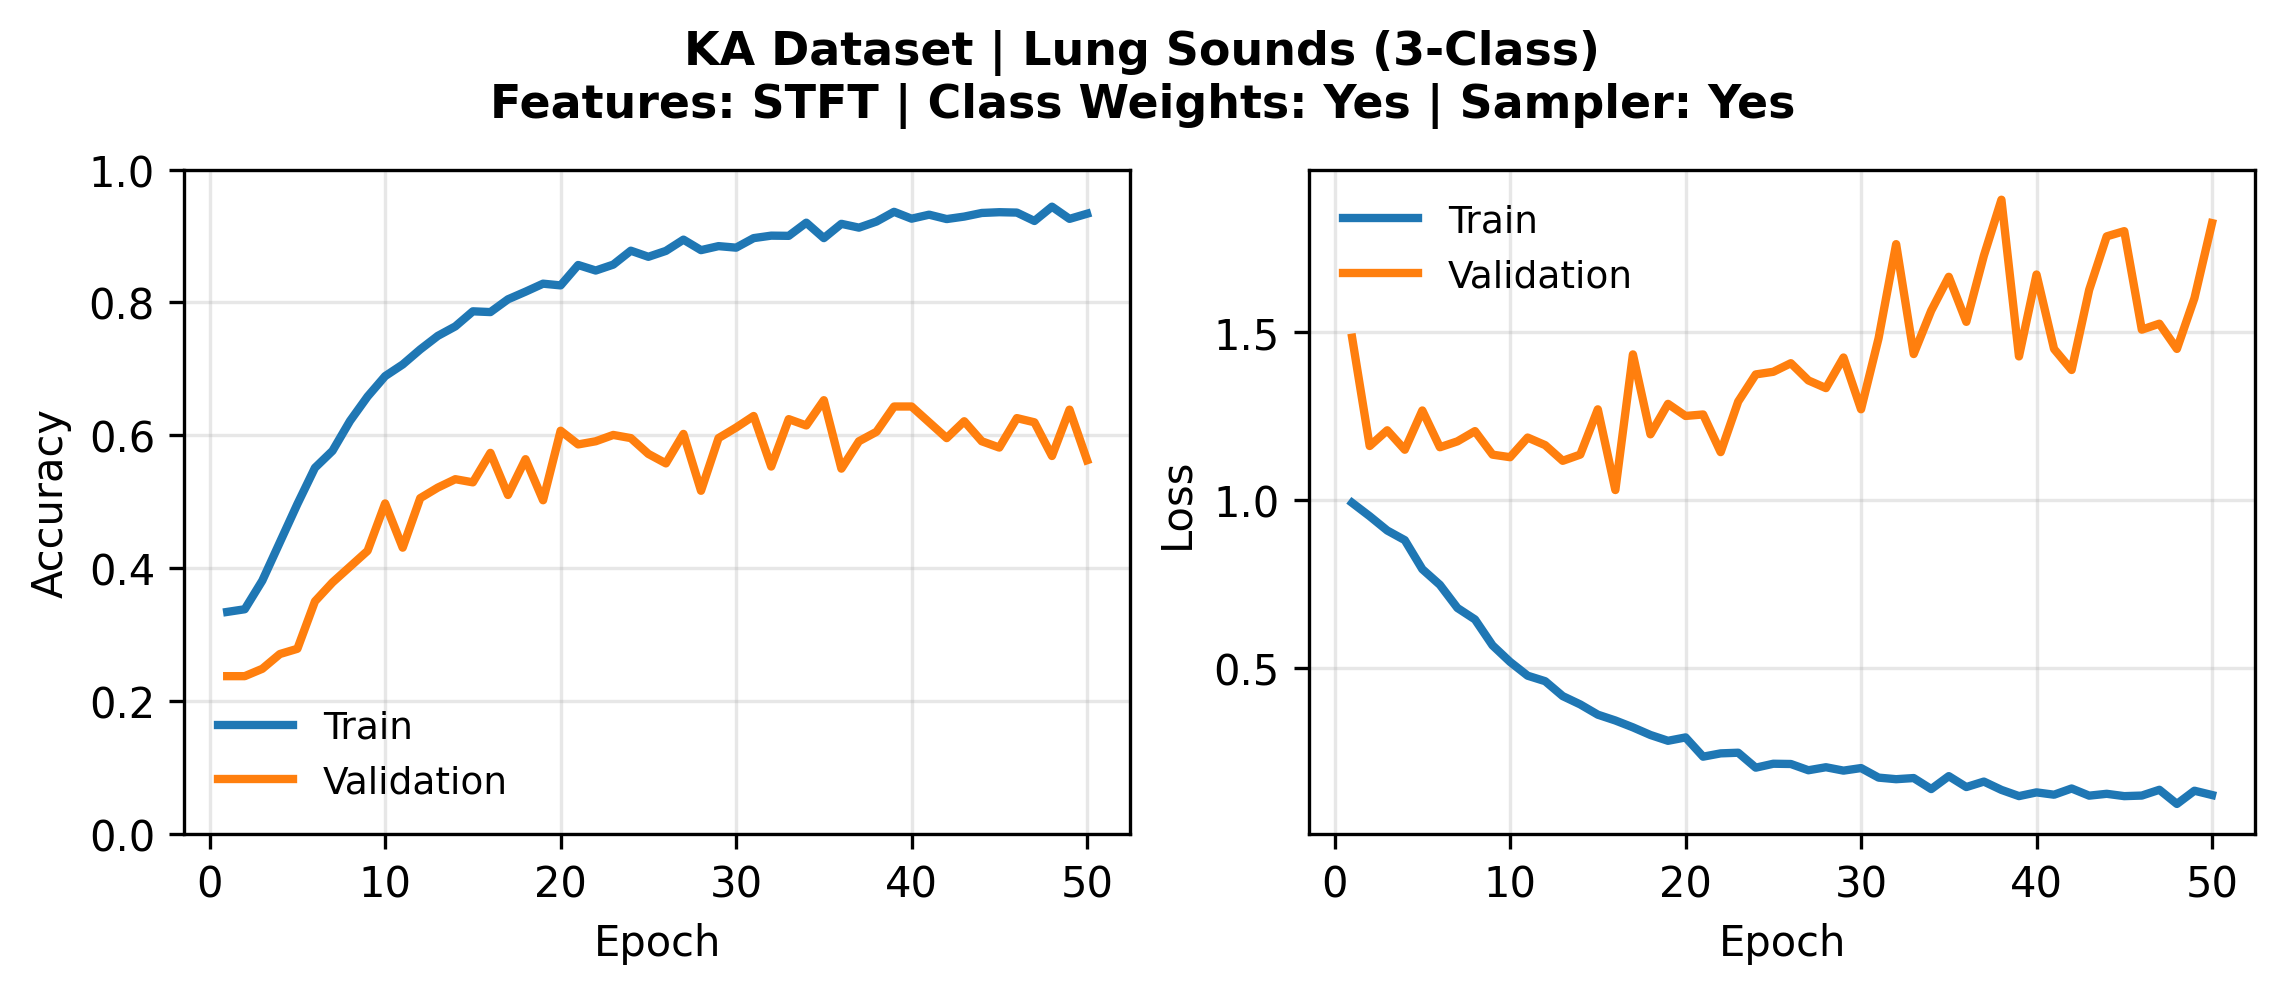

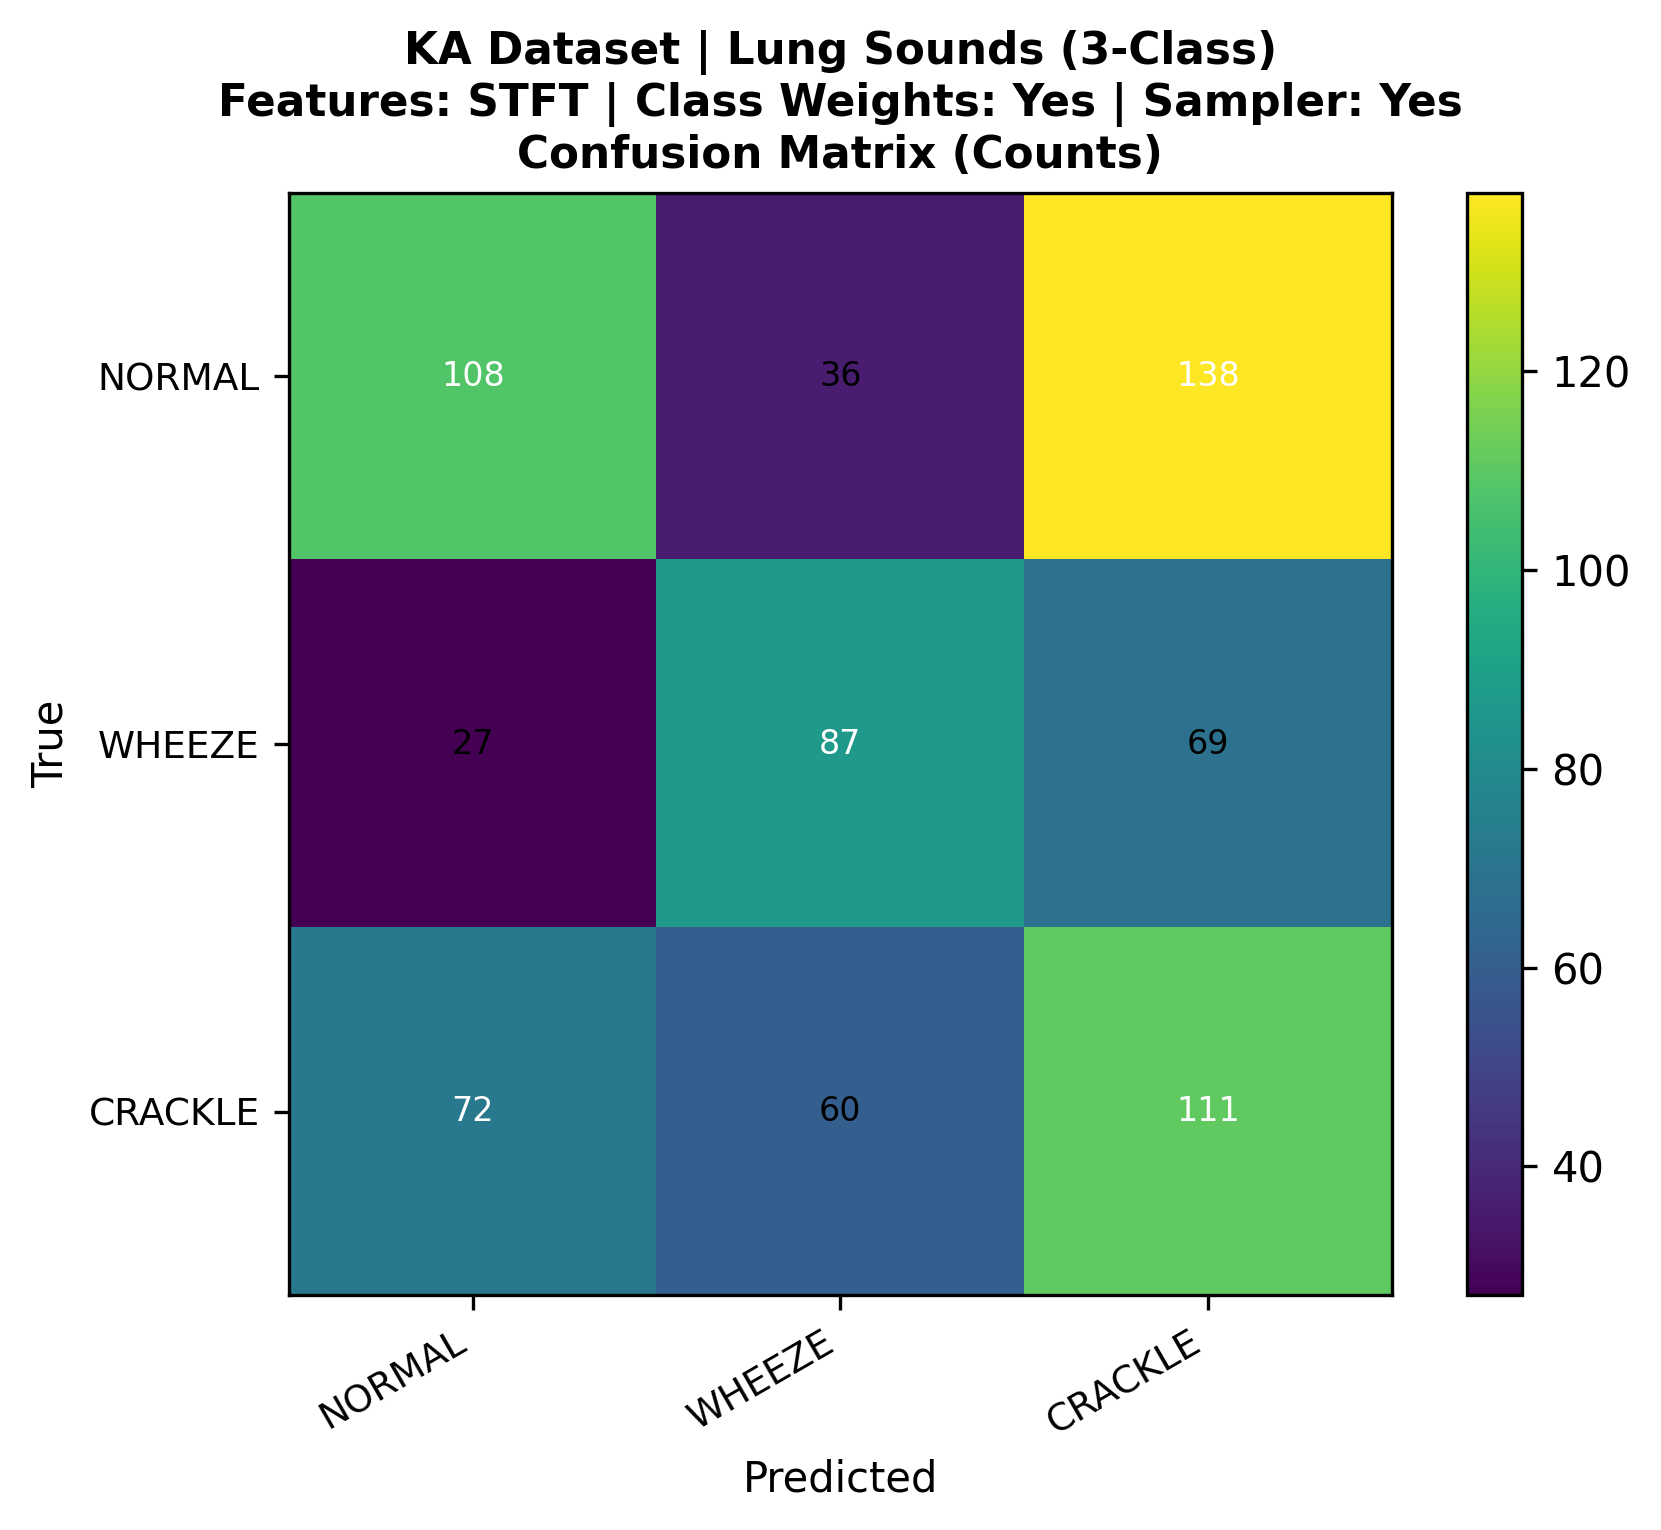

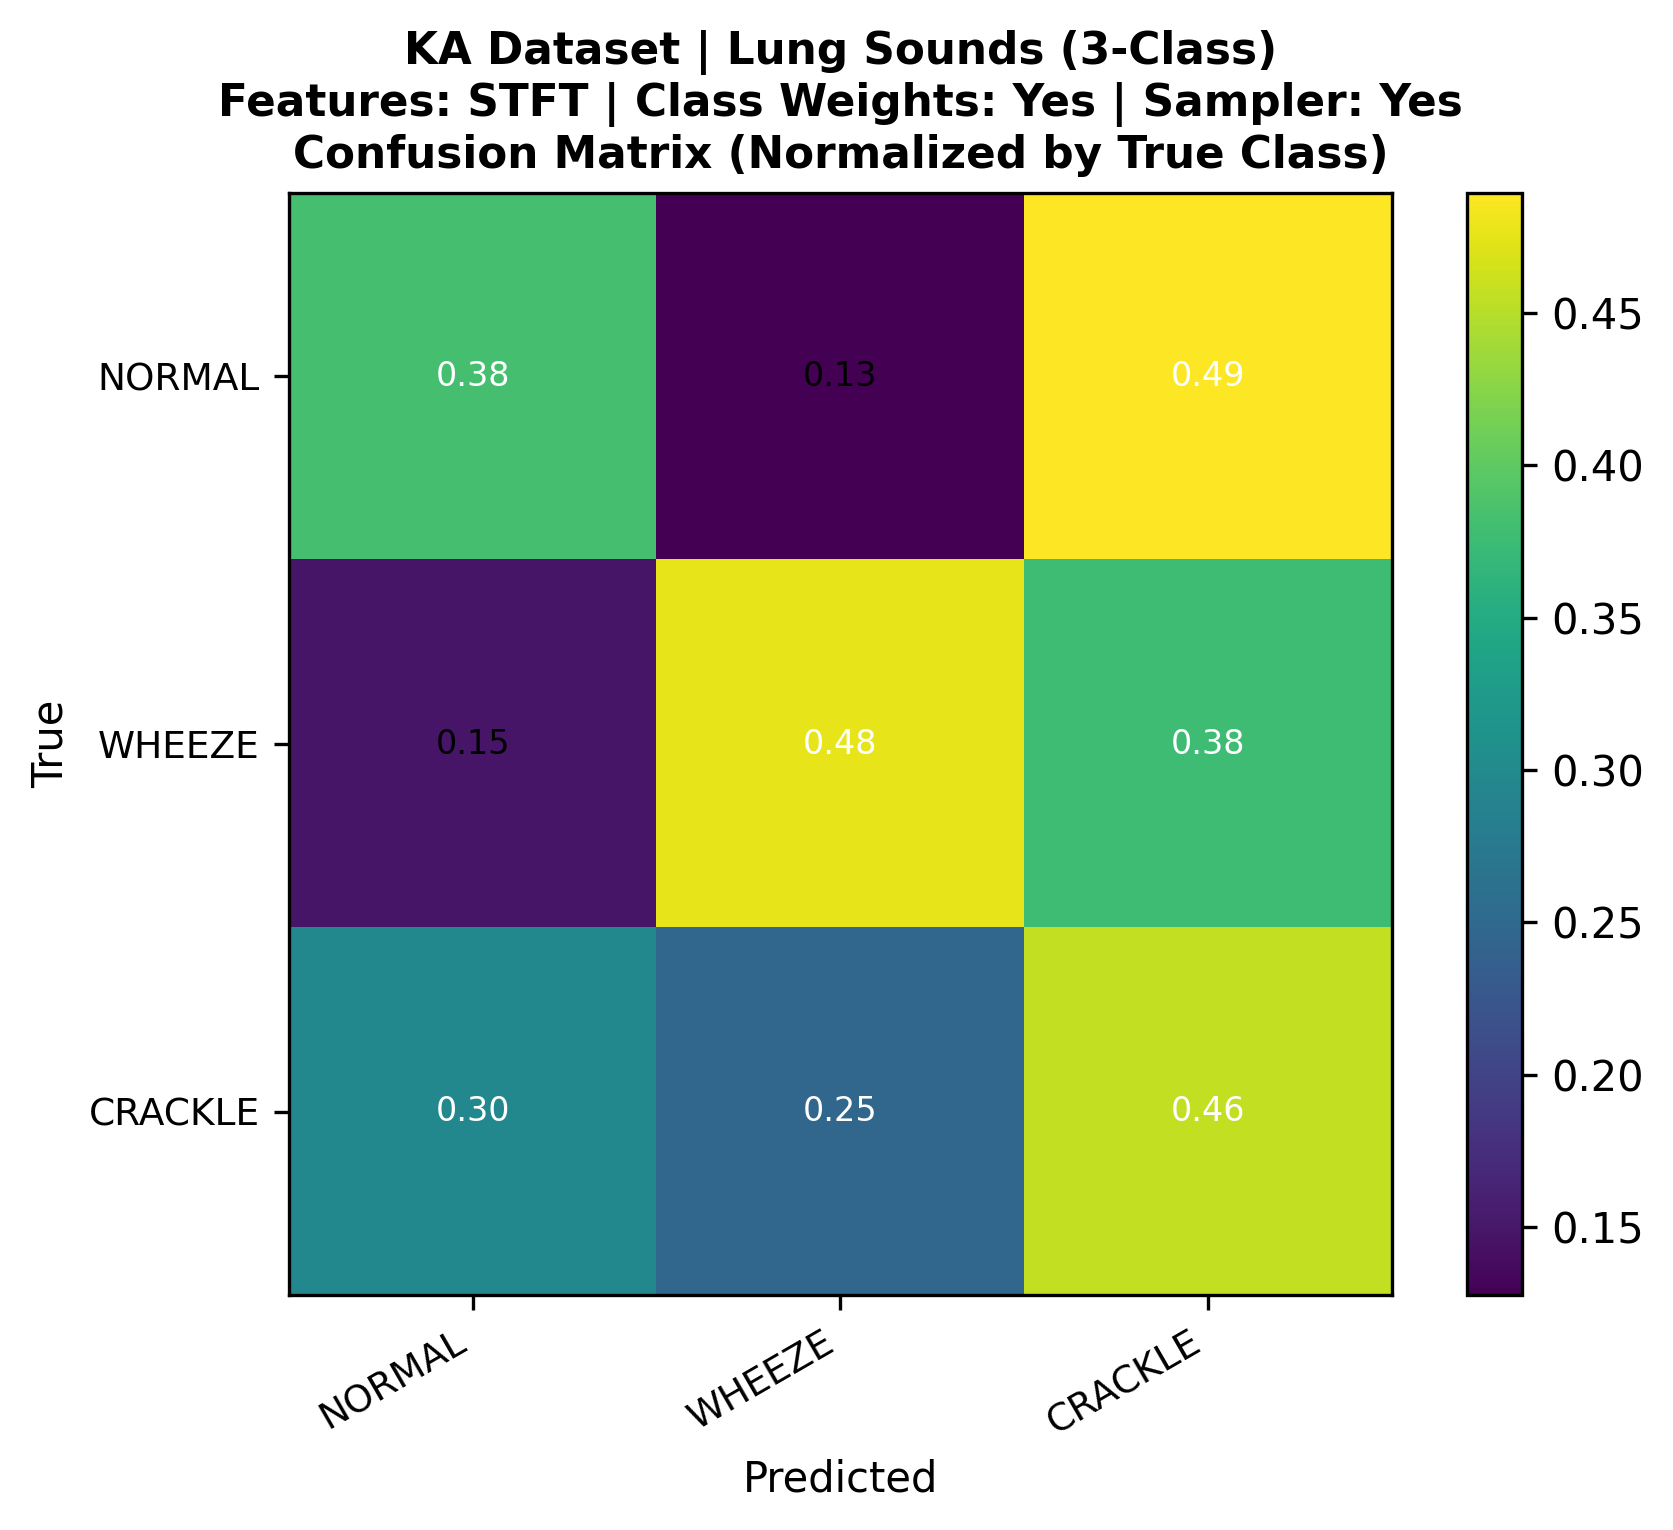

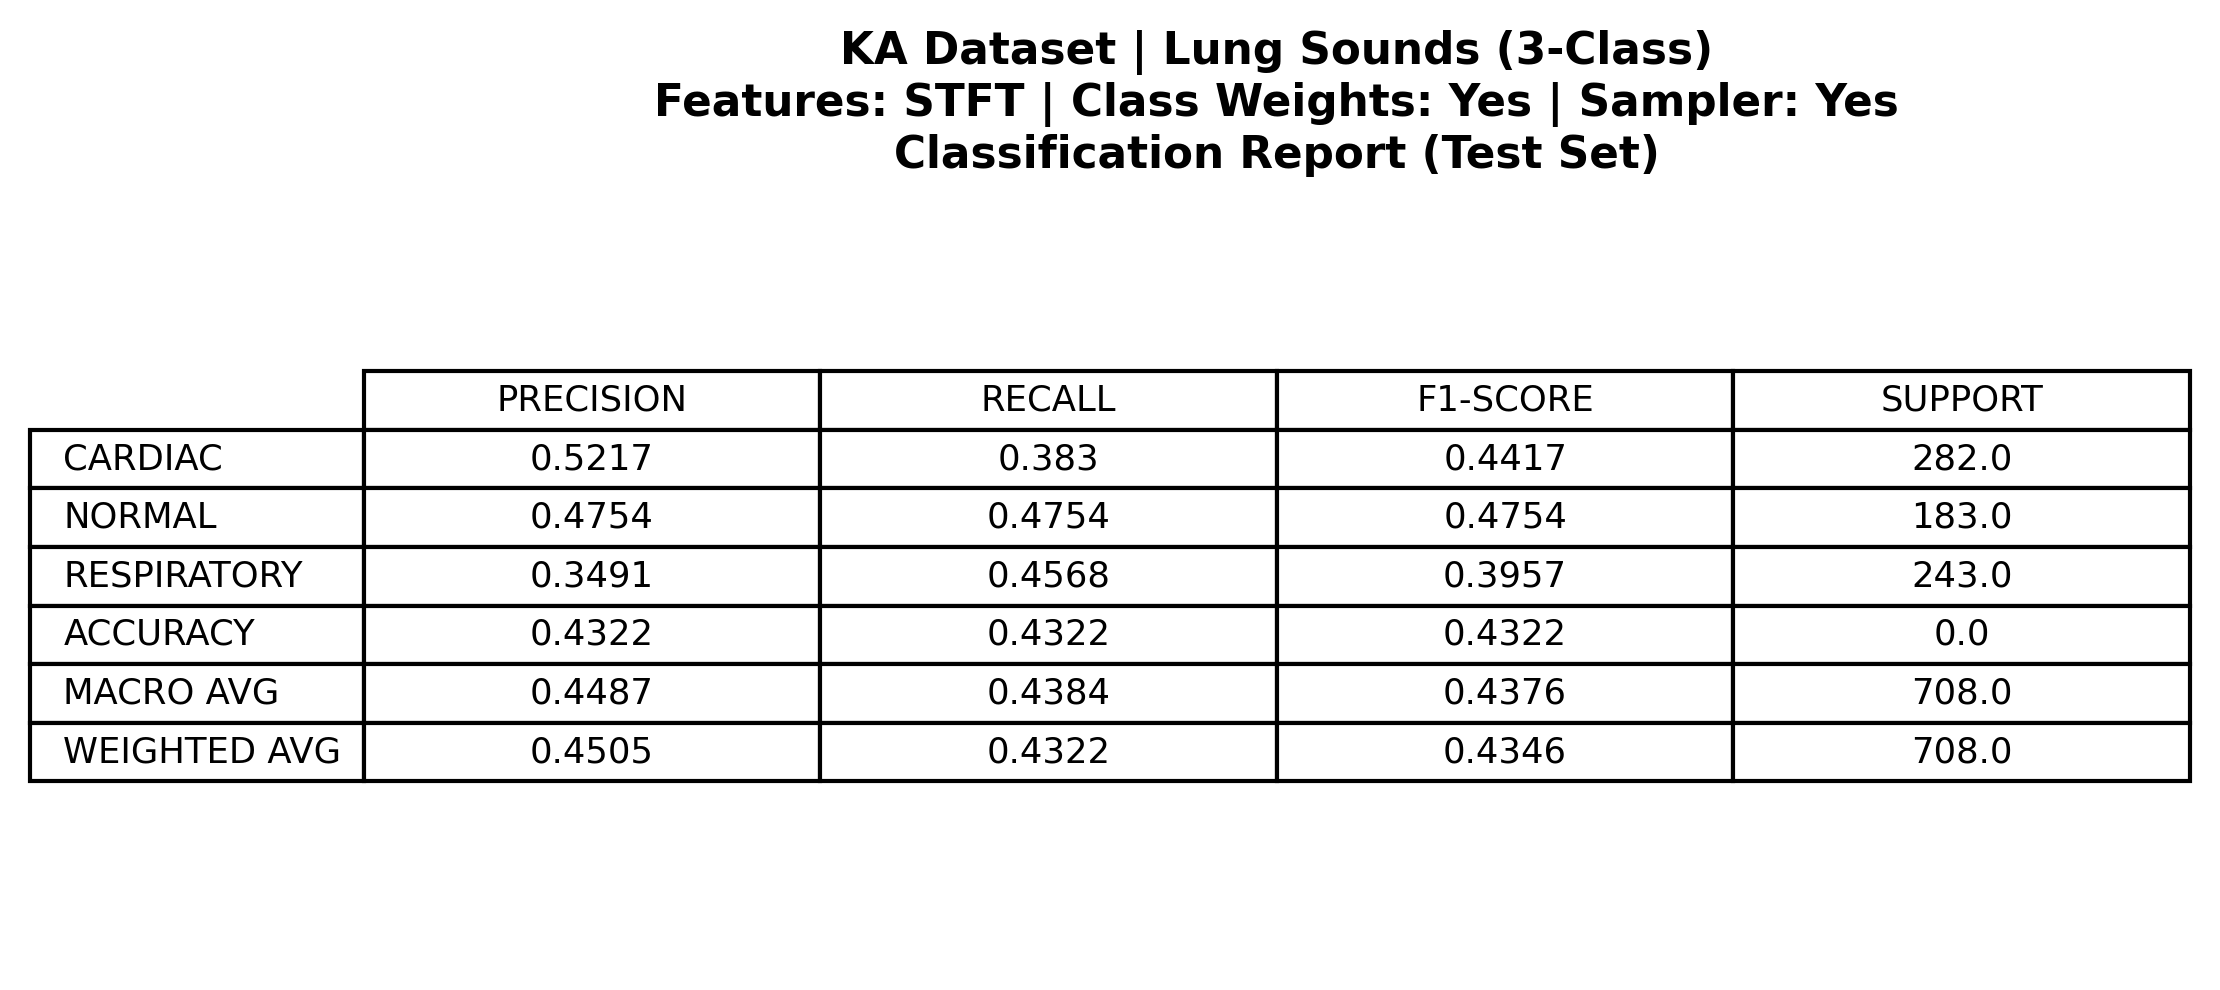

In [22]:
KA_3CLASS_LABELS = ["NORMAL", "WHEEZE", "CRACKLE"]
plot_all_runs(OUT_DIR, labels=KA_3CLASS_LABELS)